In [ ]:
!pip install wandb

In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m013 (ma23m013-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Question-1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split


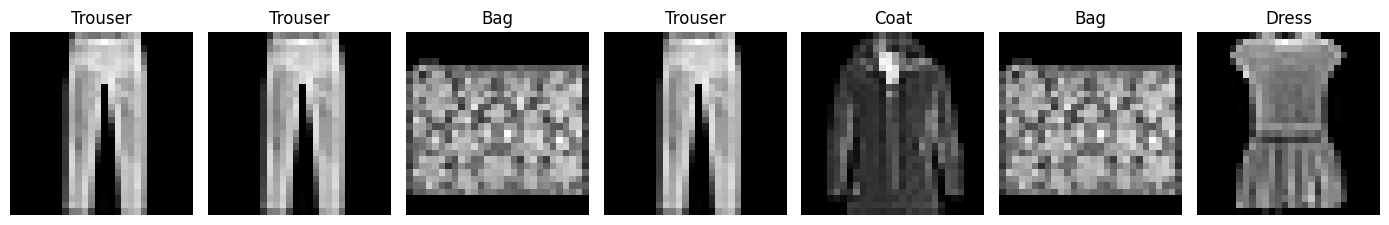

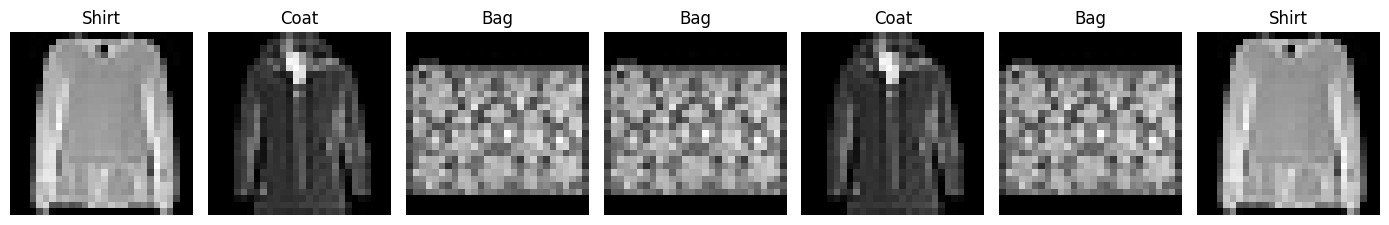

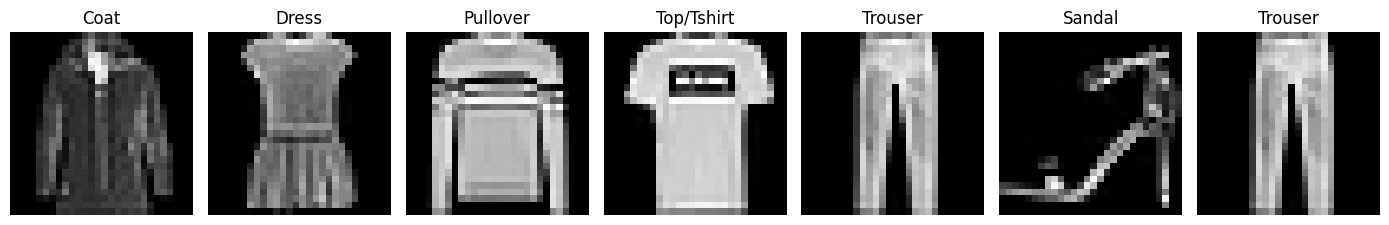

In [ ]:
# Initialize WandB project
wandb.init(project='DA6401_Assignment-1')

# Load Fashion-MNIST dataset (train and test sets)
(train_img, train_lbl), (test_img, test_lbl) = fashion_mnist.load_data()

# Define class names for labels
class_names = ['Top/Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-boot']

# Select one sample image for each class
samples = {}
for i in range(100):  # Loop through first 36 images
  lbl = train_lbl[i]  # Get label of current image
  if lbl not in samples:  # If label is not already added, add it
    samples[lbl] = train_img[i]
  if len(samples) == 10:  # Stop when all 10 classes have at least one image
    break

# Convert dictionary to lists for easy indexing
sample_lbl = list(samples.keys())
sample_img = list(samples.values())

# Function to plot 7 random sample images
def plot_sample(step):
  fig, axes = plt.subplots(1, 7, figsize=(14, 5))  # Create figure with 7 subplots
  chosen_indices = np.random.choice(len(sample_img), 7, replace=True)  # Randomly select 7 images

  for ax, idx in zip(axes.flatten(), chosen_indices):
    ax.imshow(sample_img[idx], cmap='gray')  # Display image
    ax.set_title(class_names[sample_lbl[idx]])  # Set title with class name
    ax.axis('off')  # Remove axis for cleaner view

  plt.tight_layout()
  plt.show()
  return fig

# Log images to WandB for visualization
wandb.log({"Examples": [wandb.Image(plot_sample(0), caption="Step 0"),
    wandb.Image(plot_sample(1), caption="Step 1"), wandb.Image(plot_sample(2), caption="Step 2")]})

# Finish WandB run
wandb.finish()


## Question-2 : Feedforward Neural Network


In [3]:
# Function to apply the chosen activation function
def activation_function(x, func_type):
    """Return the output of the specified activation function."""
    if func_type == 'sigmoid':
        return 1 / (1+np.exp(-x))
    elif func_type == 'relu':
        return np.maximum(0, x)
    else:
        return np.tanh(x)

# Function to apply the corresponding activation derivative
def activation_derivative(x, func_type):
    """Return the derivative of the specified activation function."""
    if func_type == 'sigmoid':
        return (1/(1+np.exp(-x))) * (1-(1/(1+np.exp(-x))))
    elif func_type == 'relu':
        return np.where(x<=0, 0, 1)
    else:
        return 1 - (np.tanh(x))**2

# Softmax function for multi-class classification
def softmax(x):
    """Compute the softmax function to convert logits into probabilities."""
    x = x - np.max(x)  # Normalize to prevent numerical instability
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# Initialize network weights and biases
def initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim):
    """ Initialize the network parameters (weights and biases) using the specified initialization method.
    Args:
        num_layers (int): Number of hidden layers.
        num_neurons (int): Number of neurons in each hidden layer.
        weight_init (str): Weight initialization method ('random' or 'xavier').
        input_dim (int): Number of input features.
        output_dim (int): Number of output classes.

    Returns:
        dict: Dictionary containing initialized weights and biases.
    """
    layer_sizes = [input_dim] + [num_neurons] * num_layers + [output_dim]  # Define layer sizes
    parameters = {}

    if weight_init == 'random':
        # Initialize weights and biases randomly
        for i in range(1, num_layers + 2):
            parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1])
            parameters[f'b{i}'] = np.random.randn(layer_sizes[i], 1)
    elif weight_init == 'xavier':
        # Initialize weights using Xavier initialization
        for i in range(1, num_layers + 2):
            parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(2 / layer_sizes[i-1])
            parameters[f'b{i}'] = np.random.randn(layer_sizes[i], 1) * np.sqrt(2 / layer_sizes[i-1])

    return parameters

# Forward propagation
def forward_propagation(inputs, params, activation, num_layers, input_dim):
    """ Perform forward propagation through the neural network.
    Args:
        inputs (numpy array): Input data.
        params (dict): Dictionary containing weights and biases.
        activation (str): Activation function to use.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.

    Returns:
        tuple: Activations, layer outputs, and final predictions.
    """
    activations, layer_outputs = {}, {}
    activations['a0'] = np.zeros((input_dim, 1))  # Initialize first activation (not used)
    layer_outputs['h0'] = inputs  # Input layer

    # Forward propagate through hidden layers
    for i in range(1, num_layers + 1):
        activations[f'a{i}'] = np.dot(params[f'W{i}'], layer_outputs[f'h{i-1}']) + params[f'b{i}']
        layer_outputs[f'h{i}'] = activation_function(activations[f'a{i}'], activation)

    # Compute final layer output (softmax for multi-class classification)
    activations[f'a{num_layers+1}'] = np.dot(params[f'W{num_layers+1}'], layer_outputs[f'h{num_layers}']) + params[f'b{num_layers+1}']
    predictions = softmax(activations[f'a{num_layers+1}'])

    return activations, layer_outputs, predictions


In [4]:
# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess data
x_train = x_train.reshape(x_train.shape[0], -1).T / 255.0  # Normalize and flatten
x_test = x_test.reshape(x_test.shape[0], -1).T / 255.0

# Convert labels to one-hot encoding
y_train_one_hot = np.eye(10)[y_train].T
y_test_one_hot = np.eye(10)[y_test].T

# Initialize neural network parameters
num_layers = 5
num_neurons = 128
weight_init = 'xavier'
input_dim = 784
output_dim = 10
activation = 'sigmoid'
params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)

# Run forward propagation on a sample
sample_input = x_train[:, :1]  # Use a single sample
target_output = y_train_one_hot[:, :1]
acts, out, pred = forward_propagation(sample_input, params, activation, num_layers, input_dim)

# Print predicted probabilities
print("Predicted probabilities:", pred.T)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Predicted probabilities: [[0.12889153 0.0879068  0.05081623 0.22052576 0.06979693 0.05006707
  0.12602327 0.05986993 0.08395421 0.12214827]]


## Question-3 : Backpropagation with Optimisation Algorithms

In [16]:
# Compute cross-entropy loss
def cross_entropy_loss(y_true, y_pred, params, lambda_reg, num_layers):
    """
    Compute the cross-entropy loss for multi-class classification.

    Args:
        y_true (numpy array): One-hot encoded true labels.
        y_pred (numpy array): Predicted probability distribution.
        lambda_reg (float): Regularization parameter
        num_layers (int): Number of hidden layers.

    Returns:
        float: Cross-entropy loss.
    """
    epsilon = 1e-15  # Prevents log(0)
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)  # Avoid numerical issues
    loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=0))
    reg_term = (lambda_reg / 2) * sum(np.sum(params[f'W{i}']**2) for i in range(1, num_layers+2)) # L2 regularization (weight decay)
    return loss + reg_term

# Backward propagation
def backward_propagation(inputs, labels, activation, num_layers, params, input_dim,lambda_reg):
    """
    Perform backward propagation to compute gradients for weight and bias updates.
    Args:
        inputs (numpy array): Input data.
        labels (numpy array): True labels in one-hot encoding.
        activation (str): Activation function used in hidden layers.
        num_layers (int): Number of hidden layers.
        params (dict): Dictionary containing weights and biases.
        input_dim (int): Number of input features.
        lambda_reg (float): Regularization parameter.

    Returns:
        dict: Gradients of weights and biases.
    """
    activations, layer_outputs, predictions = forward_propagation(inputs, params, activation, num_layers, input_dim)
    gradients, backprops = {}, {}

    # Compute loss gradient w.r.t final layer activation
    backprops[f'a{num_layers+1}'] = predictions-labels

    # Backpropagate through layers
    for i in range(num_layers+1, 0, -1):
        gradients[f'W{i}'] = np.dot(backprops[f'a{i}'], layer_outputs[f'h{i-1}'].T) + lambda_reg *params[f'W{i}']
        gradients[f'b{i}'] = backprops[f'a{i}']
        backprops[f'h{i-1}'] = np.dot(params[f'W{i}'].T, backprops[f'a{i}'])
        backprops[f'a{i-1}'] = backprops[f'h{i-1}'] * activation_derivative(activations[f'a{i-1}'], activation)

    return gradients

# Compute accuracy on test data
def compute_accuracy(X_test, Y_test, trained_params, activation, num_layers,input_dim):
    """
    Compute classification accuracy on test data.

    Args:
        X_test (numpy array): Test data.
        Y_test (numpy array): True labels in one-hot encoding.
        trained_params (dict): Trained weights and biases.
        activation (str): Activation function used in hidden layers.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.

    Returns:
        float: Accuracy of the model on test data.
    """
    num_samples = X_test.shape[0]
    correct = 0

    # Iterate over all test samples
    for i in range(num_samples):
        input_sample = X_test[i, :].reshape(-1, 1)
        act, out, pred = forward_propagation(input_sample,trained_params, activation, num_layers, input_dim)

        # Check if predicted class matches true label
        if np.argmax(Y_test[i, :].reshape(-1, 1)) == np.argmax(pred):
            correct += 1

    return correct/num_samples  # Return accuracy as a fraction


Stochastic Gradient Descent

In [17]:
def stochastic_gd(learning_rate, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_layers, num_neurons, weight_init, batch_size, input_dim, output_dim, weight_decay):
    """
    Perform stochastic gradient descent (SGD) to train a neural network.
    Args:
        learning_rate (float): Learning rate for weight updates.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        epochs (int): Number of training epochs.
        activation (str): Activation function used in hidden layers.
        num_layers (int): Number of hidden layers.
        num_neurons (int): Number of neurons per hidden layer.
        weight_init (str): Weight initialization method ('random' or 'xavier').
        batch_size (int): Number of samples per batch update.
        input_dim (int): Number of input features.
        output_dim (int): Number of output classes.
        weight_decay (float): L2 regularization strength.

    Returns:
        dict: Trained network parameters (weights and biases).
    """
    # Initialize the neural network parameters (weights and biases)
    params = initialize_network(num_layers, num_neurons,weight_init, input_dim, output_dim)

    # List to store loss values over epochs for visualization
    losses = []

    # Get the number of training samples
    num_samples = X_train.shape[0]

    for epoch in range(epochs):  # Loop over the number of epochs
        indices = np.arange(num_samples)  # Create an array of sample indices
        np.random.shuffle(indices)  # shuffle the indices for stochastic updates

        # Dictionary to accumulate gradients for batch updates
        batch_updates = {key: np.zeros_like(value) for key, value in params.items()}

        for idx in range(num_samples):  # Loop over each training sample
            # Select one sample and reshape it into a column vector
            input_sample = X_train[indices[idx], :].reshape(-1, 1)
            label_sample = Y_train[indices[idx], :].reshape(-1, 1)

            # Perform backward propagation to compute gradients
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients for batch update
            for k in range(1, num_layers + 2):
                batch_updates[f'W{k}'] += gradients[f'W{k}']
                batch_updates[f'b{k}'] += gradients[f'b{k}']

            # Perform parameter update after processing 'batch_size' samples
            if (idx + 1) % batch_size == 0:
                for i in range(1, num_layers + 2):
                    params[f'W{i}'] -= learning_rate * batch_updates[f'W{i}']
                    params[f'b{i}'] -= learning_rate * batch_updates[f'b{i}']

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        act, out, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds, params, weight_decay, num_layers)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'Train_loss': train_loss,
                   'Train_accuracy': train_acc * 100,
                   'Val_loss': val_loss,
                   'Val_accuracy': val_acc * 100,
                   'Epoch': epoch})

    # Plot training loss over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()

    return params  # Return the trained network parameters


Momentum Based Gradient Descent

In [18]:
def momentum_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, beta,weight_decay):
    """
    Implements the Momentum Optimizer for training a neural network.
        u_t = β * u_(t-1) + ∇w_t
        w_(t+1) = w_t - η * u_t

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        beta (float): Momentum coefficient.
        weight_decay (float): L2 regularization strength.

    Returns:
        dict: Updated network parameters after training.
    """

    losses = []  # List to store the training loss over epochs
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize velocity for momentum updates (same shape as parameters)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate over epochs
        num_processed = 0  # Counter for processed samples
        epoch_loss = 0  # Initialize loss for the current epoch
        num_batches = 0  # Count number of batches processed
        grad_accu = {key: np.zeros_like(value) for key, value in params.items()}  # Accumulate gradients

        for sample_idx in range(num_samples):  # Loop through all training samples
            num_processed += 1  # Increment processed sample counter

            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                grad_accu[f'W{layer}'] += gradients[f'W{layer}']
                grad_accu[f'b{layer}'] += gradients[f'b{layer}']

            # Update weights and biases once the batch is complete
            if num_processed % batch_size == 0:
                num_batches += 1  # Increment batch count

                for layer in range(1, num_layers + 2):
                    # Compute velocity update using momentum
                    velocity[f'W{layer}'] = beta * prev_v[f'W{layer}'] + grad_accu[f'W{layer}']
                    velocity[f'b{layer}'] = beta * prev_v[f'b{layer}'] + grad_accu[f'b{layer}']


                    # Apply momentum-based update to parameters
                    params[f'W{layer}'] -= learning_rate * velocity[f'W{layer}']
                    params[f'b{layer}'] -= learning_rate * velocity[f'b{layer}']

                # Store previous velocity values for the next batch update
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

        # Compute training accuracy at the end of the epoch
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_predictions = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_predictions, params, weight_decay, num_layers)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        act, out, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds, params, weight_decay, num_layers)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'Train_loss': train_loss,
                   'Train_accuracy': train_acc * 100,
                   'Val_loss': val_loss,
                   'Val_accuracy': val_acc * 100,
                   'Epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params  # Return the trained parameters


Nesterov Accelerated Gradient Descent

In [19]:
def nag_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, beta,weight_decay):
    """
    Implements Nesterov Accelerated Gradient (NAG) optimizer for training a neural network.
        u_t = β * u_(t-1) + ∇(w_t - η*β * u_(t-1))
        w_(t+1) = w_t - η*u_t

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        beta (float): Momentum coefficient.
        weight_decay (float): L2 regularization strength.

    Returns:
        dict: Updated network parameters after training.
    """

    losses = []  # List to store training loss for each epoch
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize velocity for momentum updates (same shape as parameters)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate over epochs
        grad_accu = {key: np.zeros_like(value) for key, value in params.items()}  # Accumulate gradients
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize loss for current epoch

        for sample_idx in range(num_samples):  # Iterate over all training samples
            num_processed += 1  # Increment processed sample counter

            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Look ahead by applying momentum before computing gradients
            for layer in range(1, num_layers + 2):
                params[f'W{layer}'] -= learning_rate * beta * prev_v[f'W{layer}']
                params[f'b{layer}'] -= learning_rate * beta * prev_v[f'b{layer}']

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                grad_accu[f'W{layer}'] += gradients[f'W{layer}']
                grad_accu[f'b{layer}'] += gradients[f'b{layer}']

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                num_batches += 1  # Increment batch count

                for layer in range(1, num_layers + 2):
                    # Compute velocity update using Nesterov's momentum
                    velocity[f'W{layer}'] = beta * prev_v[f'W{layer}'] + grad_accu[f'W{layer}']
                    velocity[f'b{layer}'] = beta * prev_v[f'b{layer}'] + grad_accu[f'b{layer}']


                    # Apply velocity-based update to parameters
                    params[f'W{layer}'] -= learning_rate * velocity[f'W{layer}']
                    params[f'b{layer}'] -= learning_rate * velocity[f'b{layer}']

                # Store previous velocity values for the next batch update
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        act, out, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds, params, weight_decay, num_layers)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'Train_loss': train_loss,
                   'Train_accuracy': train_acc * 100,
                   'Val_loss': val_loss,
                   'Val_accuracy': val_acc * 100,
                   'Epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params  # Return the trained parameters


RMSPROP

In [20]:
def rmsprop_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta,weight_decay):
    """
    Implements the RMSprop (Root Mean Square Propagation) optimizer for training a neural network.
        v_t = β * v_(t-1) + (1-β) * (∇w_t)^2
        w_(t+1) = w_t - η*(∇w_t / (√v_t + ε))

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        epsilon (float): Small constant to avoid division by zero.
        beta (float, optional): Decay rate for the moving average of squared gradients.
        weight_decay (float): L2 regularization strength.

    Returns:
        dict: Updated network parameters after training.
    """

    losses = []  # List to store training loss for each epoch
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize velocity (moving average of squared gradients) for each parameter
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate through epochs
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize loss for the current epoch

        # Initialize gradient accumulator for batch updates
        grad_accu = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):  # Iterate through all training samples
            num_processed += 1  # Increment processed sample counter

            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                grad_accu[f'W{layer}'] += gradients[f'W{layer}']
                grad_accu[f'b{layer}'] += gradients[f'b{layer}']

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                num_batches += 1  # Increment batch count

                for layer in range(1, num_layers + 2):
                    # Compute moving average of squared gradients (RMSprop update)
                    velocity[f'W{layer}'] = beta*prev_v[f'W{layer}'] + (1-beta)*(grad_accu[f'W{layer}']**2)
                    velocity[f'b{layer}'] = beta*prev_v[f'b{layer}'] + (1-beta)*(grad_accu[f'b{layer}']**2)


                    # Apply RMSprop update rule to parameters
                    params[f'W{layer}'] -= (learning_rate/(np.sqrt(velocity[f'W{layer}']+epsilon))) * grad_accu[f'W{layer}']
                    params[f'b{layer}'] -= (learning_rate/(np.sqrt(velocity[f'b{layer}']+epsilon))) * grad_accu[f'b{layer}']

                # Store previous velocity values for the next batch update
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        act, out, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds, params, weight_decay, num_layers)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'Train_loss': train_loss,
                   'Train_accuracy': train_acc * 100,
                   'Val_loss': val_loss,
                   'Val_accuracy': val_acc * 100,
                   'Epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params  # Return the trained parameters


ADAM

In [21]:
def adam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay):
    """
    Implements the Adam (Adaptive Moment Estimation) optimizer for training a neural network.
        m_t = β1*m_(t-1) + (1-β1)*∇w_t
        hat{m_t} = m_t / (1-β1^t)
        v_t = β2*v_(t-1) + (1-β2)*(∇w_t)^2
        hat{v_t} = v_t / (1-β2^t)
        w_(t+1) = w_t - η*(hat{m_t} / (√(hat{v_t}) +ε) )

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        epsilon (float): Small constant to avoid division by zero.
        beta1 (float): exponential decay rate for first moment estimates.
        beta2 (float): exponential decay rate for second moment estimates.
        weight_decay (float): L2 regularization strength.

    Returns:
        dict: Updated network parameters after training.
    """

    losses = []  # List to store loss values for each epoch
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize first moment vector (momentum)
    momentum = {key: np.zeros_like(value) for key, value in params.items()}
    prev_m = {key: np.zeros_like(value) for key, value in params.items()}
    m_hat = {key: np.zeros_like(value) for key, value in params.items()}

    # Initialize second moment vector (velocity - moving average of squared gradients)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}
    v_hat = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate over epochs
        time_step = 0  # Time step counter for bias correction
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize epoch loss

        # Initialize gradient accumulator for batch updates
        gradient_accumulator = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):  # Iterate through all training samples
            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                gradient_accumulator[f'W{layer}'] += gradients[f'W{layer}']
                gradient_accumulator[f'b{layer}'] += gradients[f'b{layer}']

            num_processed += 1  # Increment processed sample counter

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                time_step += 1  # Increment time step for bias correction
                num_batches += 1  # Increment batch count

                # Compute biased first moment estimate (momentum)
                for layer in range(1, num_layers + 2):
                    momentum[f'W{layer}'] = beta1*prev_m[f'W{layer}'] + (1-beta1)*gradient_accumulator[f'W{layer}']
                    momentum[f'b{layer}'] = beta1*prev_m[f'b{layer}'] + (1-beta1)*gradient_accumulator[f'b{layer}']

                # Compute bias-corrected first moment estimate
                    m_hat[f'W{layer}'] = momentum[f'W{layer}'] / (1 - np.power(beta1, time_step))
                    m_hat[f'b{layer}'] = momentum[f'b{layer}'] / (1 - np.power(beta1, time_step))

                    # Update previous momentum values
                    prev_m[f'W{layer}'] = momentum[f'W{layer}']
                    prev_m[f'b{layer}'] = momentum[f'b{layer}']

                # Compute biased second moment estimate (velocity)
                    velocity[f'W{layer}'] = beta2*prev_v[f'W{layer}'] + (1-beta2)*(gradient_accumulator[f'W{layer}']**2)
                    velocity[f'b{layer}'] = beta2*prev_v[f'b{layer}'] + (1-beta2)*(gradient_accumulator[f'b{layer}']**2)

                # Compute bias-corrected second moment estimate
                    v_hat[f'W{layer}'] = velocity[f'W{layer}']/(1 - np.power(beta2, time_step))
                    v_hat[f'b{layer}'] = velocity[f'b{layer}']/(1 - np.power(beta2, time_step))

                    # Update previous velocity values
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

                # Apply Adam update rule to parameters
                    params[f'W{layer}'] -= (learning_rate/(np.sqrt(v_hat[f'W{layer}']) + epsilon)) *m_hat[f'W{layer}']
                    params[f'b{layer}'] -= (learning_rate/(np.sqrt(v_hat[f'b{layer}']) + epsilon)) *m_hat[f'b{layer}']

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        act, out, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds, params, weight_decay, num_layers)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'Train_loss': train_loss,
                   'Train_accuracy': train_acc * 100,
                   'Val_loss': val_loss,
                   'Val_accuracy': val_acc * 100,
                   'Epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params  # Return the trained parameters


NADAM

In [22]:
def nadam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay):
    """
    Implements the Nadam (Nesterov-accelerated Adaptive Moment Estimation) optimization algorithm.

    Args:
        learning_rate: The step size for parameter updates.
        params: Dictionary containing the neural network parameters.
        X_train, Y_train: Training data and corresponding labels.
        X_valid, Y_valid: Validation data and corresponding labels.
        activation: Activation function used in the network.
        epochs: Number of training iterations.
        num_layers: Number of hidden layers.
        input_dim: Input dimension of the data.
        batch_size: Number of samples per batch update.
        epsilon: Small value to avoid division by zero.
        beta1: Decay rate for the first moment estimate (momentum term).
        beta2: Decay rate for the second moment estimate (velocity term).
        weight_decay (float): L2 regularization strength.

    Returns:
        Updated parameters after training.
    """
    losses = []
    num_samples = X_train.shape[0]

    # Initialize velocity and momentum terms for all parameters
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}
    v_hat = {key: np.zeros_like(value) for key, value in params.items()}

    momentum = {key: np.zeros_like(value) for key, value in params.items()}
    prev_m = {key: np.zeros_like(value) for key, value in params.items()}
    m_hat = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):
        time_step = 0
        num_processed = 0
        num_batches = 0
        epoch_loss = 0
        grad_accu = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):
            # Forward pass for a single training sample
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients over the batch
            for layer in range(num_layers + 1, 0, -1):
                grad_accu[f'W{layer}'] += gradients[f'W{layer}']
                grad_accu[f'b{layer}'] += gradients[f'b{layer}']

            num_processed += 1
            if num_processed % batch_size == 0:
                time_step += 1
                num_batches += 1

                # Compute momentum estimates
                for layer in range(1, num_layers + 2):
                    momentum[f'W{layer}'] = beta1 *prev_m[f'W{layer}'] + (1-beta1)*grad_accu[f'W{layer}']
                    momentum[f'b{layer}'] = beta1 *prev_m[f'b{layer}'] + (1-beta1)*grad_accu[f'b{layer}']

                # Bias-corrected momentum
                    m_hat[f'W{layer}'] = momentum[f'W{layer}']/(1-np.power(beta1, time_step))
                    m_hat[f'b{layer}'] = momentum[f'b{layer}']/(1-np.power(beta1, time_step))
                    prev_m[f'W{layer}'] = momentum[f'W{layer}']
                    prev_m[f'b{layer}'] = momentum[f'b{layer}']

                # Compute velocity estimates
                    velocity[f'W{layer}'] = beta2 * prev_v[f'W{layer}'] + (1-beta2) * (grad_accu[f'W{layer}']**2)
                    velocity[f'b{layer}'] = beta2 * prev_v[f'b{layer}'] + (1-beta2) * (grad_accu[f'b{layer}']**2)

                # Bias-corrected velocity
                    v_hat[f'W{layer}'] = velocity[f'W{layer}'] /(1-np.power(beta2, time_step))
                    v_hat[f'b{layer}'] = velocity[f'b{layer}'] /(1-np.power(beta2, time_step))
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

                # Update parameters using Nadam update rule
                    params[f'W{layer}'] -= (learning_rate/(np.sqrt(v_hat[f'W{layer}'])+epsilon)) * (beta1*m_hat[f'W{layer}'] + (1-beta1)*grad_accu[f'W{layer}']/(1-np.power(beta1, time_step)))
                    params[f'b{layer}'] -= (learning_rate/(np.sqrt(v_hat[f'b{layer}'])+epsilon)) * (beta1*m_hat[f'b{layer}'] + (1-beta1)*grad_accu[f'b{layer}']/(1-np.power(beta1, time_step)))

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        act, out, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds, params, weight_decay, num_layers)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'Train_loss': train_loss,
                   'Train_accuracy': train_acc * 100,
                   'Val_loss': val_loss,
                   'Val_accuracy': val_acc * 100,
                   'Epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params


## Question-4

In [27]:
# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Split the training data into training and validation sets (90% train, 10% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Flatten the images (convert 28x28 matrices into 1D arrays of size 784)
# Normalize pixel values to the range [0,1] by dividing by 255
X_train = X_train.reshape(X_train.shape[0], -1) / 255
X_valid = X_valid.reshape(X_valid.shape[0], -1) / 255
X_test = X_test.reshape(X_test.shape[0], -1) / 255

def one_hot_encod(arr):
    """ Convert class labels to one-hot encoded vectors.
    Args: arr (numpy array): Array of class labels (e.g, [0, 1, 2, ..., 9])

    Returns: numpy array: One-hot encoded matrix of shape (len(arr), 10)
    """
    mat = np.zeros((len(arr), 10))  # Create a matrix of zeros with shape (num_samples, num_classes)
    for i in range(len(arr)):
        mat[i, arr[i]] = 1  # Set the corresponding class index to 1
    return mat

# Convert labels to one-hot encoding for training, validation, and test sets
Y_train = one_hot_encod(y_train)
Y_valid = one_hot_encod(y_valid)
Y_test = one_hot_encod(y_test)


In [28]:
def train_model(X_train,Y_train, X_valid, Y_valid, input_dim,output_dim, learning_rate=0.1, optimizer='sgd', regularization=0.0, epochs=1, activation='sigmoid',
                num_layers=1, num_neurons=4, weight_init='random', batch_size=4, epsilon=0.000001, beta=0.5, beta1=0.5, beta2=0.5):
    """
    Train a neural network model using the specified optimizer.

    Parameters:
    - X_train, Y_train: Training data and labels.
    - X_valid, Y_valid: Validation data and labels.
    - input_dim: Input feature dimension.
    - output_dim: Output dimension (number of classes for classification).
    - learning_rate: The learning rate for optimization.
    - optimizer: The optimization algorithm to use ('sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam').
    - regularization (weight_decay): L2 Regularization term.
    - epochs: Number of training epochs.
    - activation: Activation function to use.
    - num_layers: Number of hidden layers in the network.
    - num_neurons: Number of neurons in each hidden layer.
    - weight_init: Weight initialization method.
    - batch_size: Number of samples per training batch.
    - epsilon: Small constant to prevent division by zero.
    - beta, beta1, beta2: Hyperparameters for momentum-based optimizers.

    Returns:
    - params: The trained model parameters.
    """

    # Initialize the network with random weights based on the chosen weight initialization method
    params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)

    # Select the appropriate optimizer and train the model
    if optimizer == 'sgd':
        # Stochastic Gradient Descent
        params = stochastic_gd(learning_rate, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_layers, num_neurons, weight_init, batch_size, input_dim, output_dim,regularization)
    elif optimizer == 'momentum':
        # Momentum based Gradient Descent
        params = momentum_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, beta,regularization)
    elif optimizer == 'nesterov':
        # Nesterov Accelerated Gradient Descent (NAG)
        params = nag_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, beta,regularization)
    elif optimizer == 'rmsprop':
        # RMSprop optimizer
        params = rmsprop_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta,regularization)
    elif optimizer == 'adam':
        # Adam optimizer (Adaptive Moment Estimation)
        params = adam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,regularization)
    elif optimizer == 'nadam':
        # Nadam optimizer (Adam with Nesterov momentum)
        params = nadam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,regularization)

    return params


In [29]:
# Define the hyperparameter sweep configuration
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization for efficient hyperparameter tuning
    'name': 'sweep cross entropy now',  # Name of the sweep for tracking
    'metric': {'name': 'Val_accuracy',  # The metric to optimize
               'goal': 'maximize'},  # The objective is to maximize Training accuracy
    'parameters': {
        'epochs': {'values': [5, 10]},  # Number of training epochs
        'num_layers': {'values': [3, 4, 5]},  # Number of hidden layers
        'num_neurons': {'values': [32, 64, 128]},  # Neurons per layer
        'regularization': {'values': [0, 0.0005, 0.5]},  # L2 regularization strength
        'learning_rate': {'values': [1e-3, 1e-4]},  # Learning rate values
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},  # Optimizers to test
        'batch_size': {'values': [16, 32, 64]},  # Batch sizes for training
        'weight_init': {'values': ['random', 'xavier']},  # Weight initialization methods
        'activation': {'values': ['sigmoid', 'relu', 'tanh']}  # Activation functions to test
    }
}

# Initialize the sweep and get the sweep ID
sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_Assignment-1')
# Creates a new sweep in the project 'DA6401_Assignment-1' and returns a sweep ID


Create sweep with ID: m3fcowlz
Sweep URL: https://wandb.ai/ma23m013-iit-madras/DA6401_Assignment-1/sweeps/m3fcowlz


wandb: Agent Starting Run: sr31te2i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0.5
wandb: 	weight_init: random


Epoch 1, Train_Loss: 12152.2771, Train_Accuracy: 8.61%, Val_Loss: 12152.2862, Val_Accuracy: 8.50%
Epoch 2, Train_Loss: 9266.9832, Train_Accuracy: 11.57%, Val_Loss: 9266.9869, Val_Accuracy: 11.75%
Epoch 3, Train_Loss: 6962.2976, Train_Accuracy: 10.31%, Val_Loss: 6962.3025, Val_Accuracy: 10.13%
Epoch 4, Train_Loss: 5152.5668, Train_Accuracy: 10.92%, Val_Loss: 5152.5680, Val_Accuracy: 10.82%
Epoch 5, Train_Loss: 3753.2143, Train_Accuracy: 12.46%, Val_Loss: 3753.2162, Val_Accuracy: 12.48%
Epoch 6, Train_Loss: 2689.0231, Train_Accuracy: 11.59%, Val_Loss: 2689.0246, Val_Accuracy: 11.12%
Epoch 7, Train_Loss: 1893.7569, Train_Accuracy: 10.03%, Val_Loss: 1893.7574, Val_Accuracy: 9.83%
Epoch 8, Train_Loss: 1310.4186, Train_Accuracy: 10.02%, Val_Loss: 1310.4196, Val_Accuracy: 9.83%
Epoch 9, Train_Loss: 890.4883, Train_Accuracy: 10.02%, Val_Loss: 890.4888, Val_Accuracy: 9.83%
Epoch 10, Train_Loss: 594.0717, Train_Accuracy: 10.02%, Val_Loss: 594.0718, Val_Accuracy: 9.83%


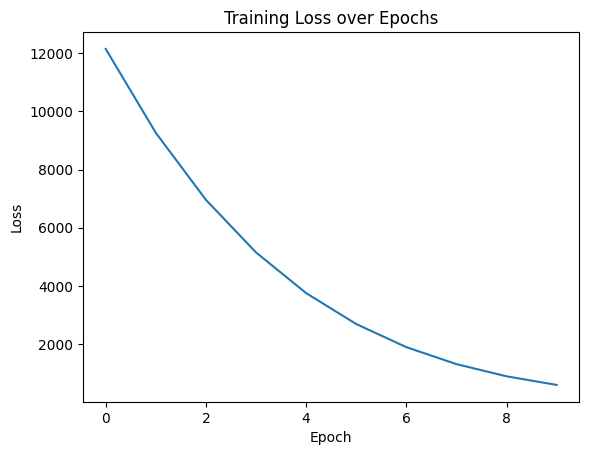

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▆▄▅█▆▄▄▄▄
Train_loss,█▆▅▄▃▂▂▁▁▁
Val_accuracy,▁▇▄▅█▆▃▃▃▃
Val_loss,█▆▅▄▃▂▂▁▁▁
Epoch,9
Train_accuracy,10.01852
Train_loss,594.07174
Val_accuracy,9.83333
Val_loss,594.07181


wandb: Agent Starting Run: y4a4gu4s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 11.3105, Train_Accuracy: 9.96%, Val_Loss: 11.2559, Val_Accuracy: 10.32%


wandb: Ctrl + C detected. Stopping sweep.


Epoch,▁
Train_accuracy,▁
Train_loss,▁
Val_accuracy,▁
Val_loss,▁
Epoch,0
Train_accuracy,9.96481
Train_loss,11.31049
Val_accuracy,10.31667
Val_loss,11.25588


In [30]:
def main():
    '''
    WandB calls the main function each time with a different combination of hyperparameters.

    We retrieve these values using `wandb.config` and use them to train the model.
    '''

    with wandb.init() as run:
        # Generate a unique run name based on the hyperparameter values
        run_name = "ac-" + (wandb.config.activation) + \
                   "_nn-" + str(wandb.config.num_neurons) + \
                   "_epc-" + str(wandb.config.epochs) + \
                   "_nl-" + str(wandb.config.num_layers) + \
                   "_wd-" + str(wandb.config.regularization) + \
                   "_lr-" + str(wandb.config.learning_rate) + \
                   "_opt-" + str(wandb.config.optimizer) + \
                   "_bs-" + str(wandb.config.batch_size) + \
                   "_wi-" + str(wandb.config.weight_init)

        # Assign the generated name to the WandB run
        wandb.run.name = run_name

        # Train the model with the current hyperparameter configuration
        train_model(
            X_train, Y_train,            # Training data
            X_valid, Y_valid,            # Validation data
            784, 10,                     # Input and output dimensions (Fashion MNIST: 784 input features, 10 classes)
            wandb.config.learning_rate,  # Learning rate
            wandb.config.optimizer,      # Optimizer
            wandb.config.regularization, # Regularization term
            wandb.config.epochs,         # Number of epochs
            wandb.config.activation,     # Activation function
            wandb.config.num_layers,     # Number of hidden layers
            wandb.config.num_neurons,    # Neurons per layer
            wandb.config.weight_init,    # Weight initialization method
            wandb.config.batch_size,     # Batch size
            epsilon=0.0001,                # Small constant for numerical stability
            beta=0.9, beta1=0.9, beta2=0.99  # Hyperparameters for momentum-based optimizers
        )

# Run the sweep agent to execute `main` function multiple times
wandb.agent(sweep_id, function=main, count=100)  # Calls `main` function 100 times with different hyperparameter sets

# Mark the end of the WandB run
wandb.finish()


In [ ]:
# Define the hyperparameter sweep configuration
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization for efficient hyperparameter tuning
    'name': 'sweep cross entropy later',  # Name of the sweep for tracking
    'metric': {'name': 'Val_accuracy',  # The metric to optimize
               'goal': 'maximize'},  # The objective is to maximize validation accuracy
    'parameters': {
        'epochs': {'values': [10]},  # Number of training epochs
        'num_layers': {'values': [4,5]},  # Number of hidden layers
        'num_neurons': {'values': [64,128]},  # Neurons per layer
        'regularization': {'values': [0,0.0005]},  # L2 regularization strength
        'learning_rate': {'values': [1e-3,1e-4]},  # Learning rate values
        'optimizer': {'values': ['rmsprop', 'adam', 'nadam']},  # Optimizers to test
        'batch_size': {'values': [32,64]},  # Batch sizes for training
        'weight_init': {'values': ['xavier']},  # Weight initialization methods
        'activation': {'values': ['sigmoid', 'relu']}  # Activation functions to test
    }
}

# Initialize the sweep and get the sweep ID
sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_Assignment-1')
# Creates a new sweep in the project 'DA6401_Assignment-1' and returns a sweep ID


Create sweep with ID: kuc52muf
Sweep URL: https://wandb.ai/ma23m013-iit-madras/DA6401_Assignment-1/sweeps/kuc52muf


wandb: Agent Starting Run: lcbpxetm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.1478, Train_Accuracy: 51.31%, Val_Loss: 1.1537, Val_Accuracy: 51.13%
Epoch 2, Train_Loss: 1.2041, Train_Accuracy: 41.18%, Val_Loss: 1.1894, Val_Accuracy: 41.92%
Epoch 3, Train_Loss: 1.0035, Train_Accuracy: 57.82%, Val_Loss: 1.0150, Val_Accuracy: 57.48%
Epoch 4, Train_Loss: 1.0327, Train_Accuracy: 59.73%, Val_Loss: 1.0591, Val_Accuracy: 58.95%
Epoch 5, Train_Loss: 1.0356, Train_Accuracy: 58.54%, Val_Loss: 1.0378, Val_Accuracy: 57.55%
Epoch 6, Train_Loss: 0.9594, Train_Accuracy: 60.03%, Val_Loss: 0.9773, Val_Accuracy: 59.67%
Epoch 7, Train_Loss: 1.0796, Train_Accuracy: 58.41%, Val_Loss: 1.0850, Val_Accuracy: 57.92%


<ipython-input-8-3f07a7944026>:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 8, Train_Loss: 1.0507, Train_Accuracy: 59.31%, Val_Loss: 1.0783, Val_Accuracy: 58.20%
Epoch 9, Train_Loss: 1.0165, Train_Accuracy: 55.55%, Val_Loss: 1.0366, Val_Accuracy: 55.15%
Epoch 10, Train_Loss: 1.0123, Train_Accuracy: 62.28%, Val_Loss: 1.0194, Val_Accuracy: 61.83%


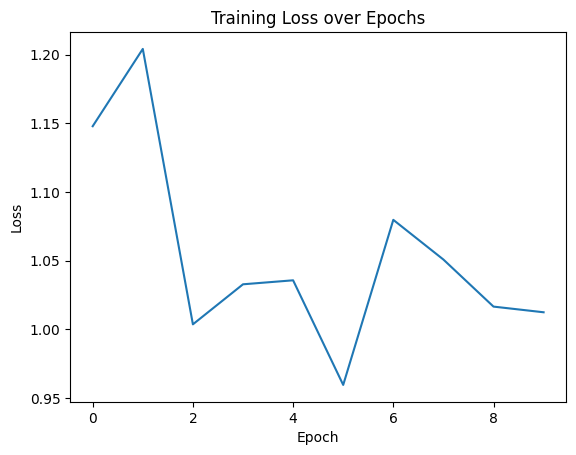

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▄▁▇▇▇▇▇▇▆█
Train_loss,▆█▂▃▃▁▄▄▃▃
Val_accuracy,▄▁▆▇▆▇▇▇▆█
Val_loss,▇█▂▄▃▁▅▄▃▂
Epoch,9
Train_accuracy,62.27778
Train_loss,1.01232
Val_accuracy,61.83333
Val_loss,1.01942


wandb: Agent Starting Run: 7l192a6y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


<ipython-input-8-3f07a7944026>:31: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x), axis=0)


Epoch 1, Train_Loss: nan, Train_Accuracy: 61.91%, Val_Loss: nan, Val_Accuracy: 61.50%
Epoch 2, Train_Loss: nan, Train_Accuracy: 34.49%, Val_Loss: nan, Val_Accuracy: 34.17%
Epoch 3, Train_Loss: nan, Train_Accuracy: 10.39%, Val_Loss: nan, Val_Accuracy: 10.52%
Epoch 4, Train_Loss: nan, Train_Accuracy: 10.39%, Val_Loss: nan, Val_Accuracy: 10.93%
Epoch 5, Train_Loss: 2.3052, Train_Accuracy: 9.96%, Val_Loss: 2.3050, Val_Accuracy: 10.32%
Epoch 6, Train_Loss: 2.3078, Train_Accuracy: 9.96%, Val_Loss: 2.3069, Val_Accuracy: 10.35%
Epoch 7, Train_Loss: 2.3062, Train_Accuracy: 9.96%, Val_Loss: 2.3060, Val_Accuracy: 10.32%
Epoch 8, Train_Loss: 2.3058, Train_Accuracy: 10.09%, Val_Loss: 2.3072, Val_Accuracy: 9.17%
Epoch 9, Train_Loss: 2.3045, Train_Accuracy: 10.02%, Val_Loss: 2.3052, Val_Accuracy: 9.78%
Epoch 10, Train_Loss: 2.3046, Train_Accuracy: 10.09%, Val_Loss: 2.3065, Val_Accuracy: 9.17%


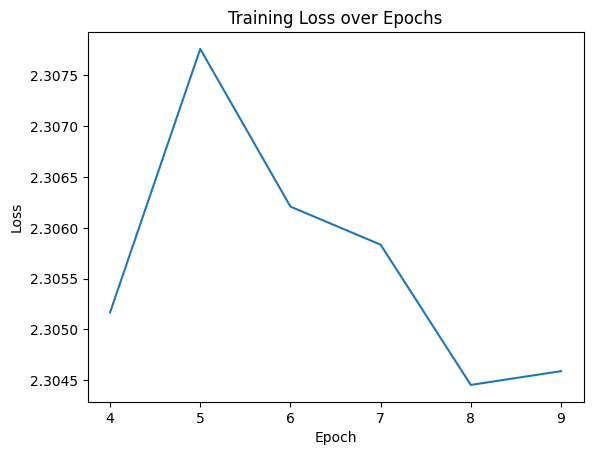

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,█▄▁▁▁▁▁▁▁▁
Train_loss,▃█▅▄▁▁
Val_accuracy,█▄▁▁▁▁▁▁▁▁
Val_loss,▁▇▄█▂▆
Epoch,9
Train_accuracy,10.09259
Train_loss,2.30459
Val_accuracy,9.16667
Val_loss,2.30647


wandb: Agent Starting Run: oehm97p3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.5740, Train_Accuracy: 43.76%, Val_Loss: 1.5802, Val_Accuracy: 44.12%
Epoch 2, Train_Loss: 0.9505, Train_Accuracy: 69.48%, Val_Loss: 0.9625, Val_Accuracy: 68.37%
Epoch 3, Train_Loss: 0.7571, Train_Accuracy: 73.37%, Val_Loss: 0.7739, Val_Accuracy: 72.73%
Epoch 4, Train_Loss: 0.6418, Train_Accuracy: 76.40%, Val_Loss: 0.6485, Val_Accuracy: 75.77%
Epoch 5, Train_Loss: 0.6492, Train_Accuracy: 75.50%, Val_Loss: 0.6709, Val_Accuracy: 74.77%
Epoch 6, Train_Loss: 0.5613, Train_Accuracy: 79.23%, Val_Loss: 0.5756, Val_Accuracy: 78.27%
Epoch 7, Train_Loss: 0.5844, Train_Accuracy: 78.87%, Val_Loss: 0.6084, Val_Accuracy: 78.18%
Epoch 8, Train_Loss: 0.5591, Train_Accuracy: 80.44%, Val_Loss: 0.5706, Val_Accuracy: 79.72%
Epoch 9, Train_Loss: 0.5855, Train_Accuracy: 78.07%, Val_Loss: 0.6025, Val_Accuracy: 77.93%
Epoch 10, Train_Loss: 0.5224, Train_Accuracy: 81.35%, Val_Loss: 0.5366, Val_Accuracy: 80.98%


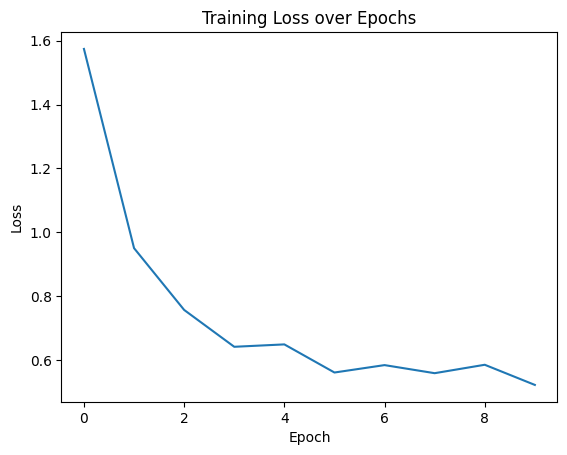

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▆▇▇▇███▇█
Train_loss,█▄▃▂▂▁▁▁▁▁
Val_accuracy,▁▆▆▇▇▇▇█▇█
Val_loss,█▄▃▂▂▁▁▁▁▁
Epoch,9
Train_accuracy,81.3463
Train_loss,0.52242
Val_accuracy,80.98333
Val_loss,0.53661


wandb: Agent Starting Run: uh5aa3nu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 2.0660, Train_Accuracy: 27.72%, Val_Loss: 2.0677, Val_Accuracy: 27.42%
Epoch 2, Train_Loss: 1.2924, Train_Accuracy: 51.47%, Val_Loss: 1.2983, Val_Accuracy: 51.17%
Epoch 3, Train_Loss: 0.9882, Train_Accuracy: 56.35%, Val_Loss: 1.0051, Val_Accuracy: 55.43%
Epoch 4, Train_Loss: 0.9268, Train_Accuracy: 60.10%, Val_Loss: 0.9446, Val_Accuracy: 59.30%
Epoch 5, Train_Loss: 0.7613, Train_Accuracy: 70.20%, Val_Loss: 0.7769, Val_Accuracy: 69.25%
Epoch 6, Train_Loss: 0.7037, Train_Accuracy: 72.34%, Val_Loss: 0.7219, Val_Accuracy: 71.10%
Epoch 7, Train_Loss: 0.6560, Train_Accuracy: 74.06%, Val_Loss: 0.6768, Val_Accuracy: 73.20%
Epoch 8, Train_Loss: 0.6177, Train_Accuracy: 76.66%, Val_Loss: 0.6399, Val_Accuracy: 75.83%
Epoch 9, Train_Loss: 0.5755, Train_Accuracy: 77.41%, Val_Loss: 0.5996, Val_Accuracy: 76.13%
Epoch 10, Train_Loss: 0.5730, Train_Accuracy: 75.74%, Val_Loss: 0.6024, Val_Accuracy: 74.43%


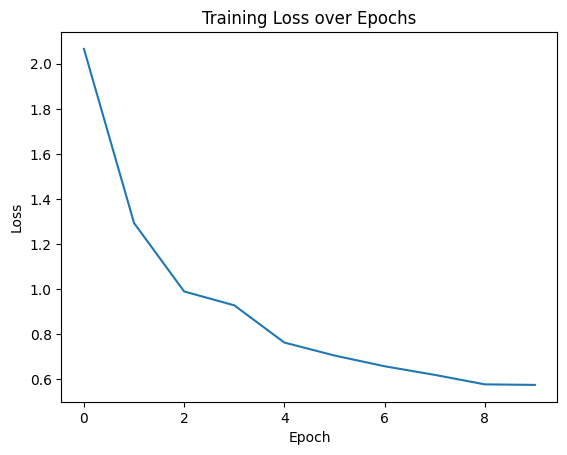

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▇▇████
Train_loss,█▄▃▃▂▂▁▁▁▁
Val_accuracy,▁▄▅▆▇▇████
Val_loss,█▄▃▃▂▂▁▁▁▁
Epoch,9
Train_accuracy,75.73889
Train_loss,0.57299
Val_accuracy,74.43333
Val_loss,0.60237


wandb: Agent Starting Run: fyoes1qo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7454, Train_Accuracy: 71.42%, Val_Loss: 0.7421, Val_Accuracy: 71.12%
Epoch 2, Train_Loss: 0.6090, Train_Accuracy: 78.06%, Val_Loss: 0.6256, Val_Accuracy: 77.58%
Epoch 3, Train_Loss: 0.6400, Train_Accuracy: 78.06%, Val_Loss: 0.6593, Val_Accuracy: 77.08%
Epoch 4, Train_Loss: 0.5672, Train_Accuracy: 78.54%, Val_Loss: 0.5867, Val_Accuracy: 78.08%
Epoch 5, Train_Loss: 0.5226, Train_Accuracy: 81.94%, Val_Loss: 0.5418, Val_Accuracy: 81.58%
Epoch 6, Train_Loss: 0.4753, Train_Accuracy: 82.66%, Val_Loss: 0.4908, Val_Accuracy: 82.08%
Epoch 7, Train_Loss: 0.5092, Train_Accuracy: 80.91%, Val_Loss: 0.5277, Val_Accuracy: 80.87%
Epoch 8, Train_Loss: 0.4459, Train_Accuracy: 84.03%, Val_Loss: 0.4639, Val_Accuracy: 83.15%
Epoch 9, Train_Loss: 0.4297, Train_Accuracy: 84.89%, Val_Loss: 0.4573, Val_Accuracy: 84.02%
Epoch 10, Train_Loss: 0.4437, Train_Accuracy: 83.51%, Val_Loss: 0.4717, Val_Accuracy: 82.63%


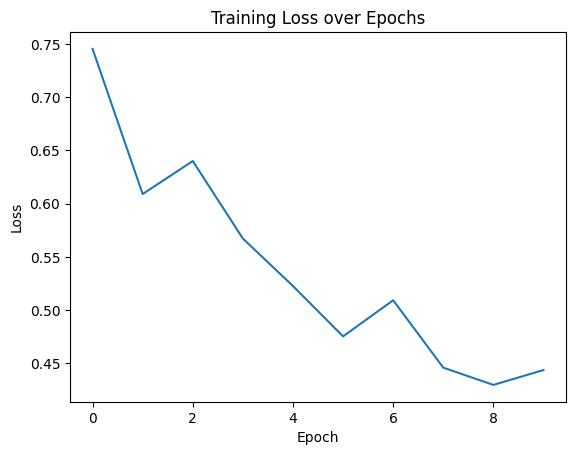

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▄▅▆▇▆██▇
Train_loss,█▅▆▄▃▂▃▁▁▁
Val_accuracy,▁▅▄▅▇▇▆██▇
Val_loss,█▅▆▄▃▂▃▁▁▁
Epoch,9
Train_accuracy,83.51111
Train_loss,0.44368
Val_accuracy,82.63333
Val_loss,0.47172


wandb: Agent Starting Run: qg2a9i4k with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7768, Train_Accuracy: 70.89%, Val_Loss: 0.7909, Val_Accuracy: 70.32%
Epoch 2, Train_Loss: 0.6019, Train_Accuracy: 77.79%, Val_Loss: 0.6134, Val_Accuracy: 76.73%
Epoch 3, Train_Loss: 0.6044, Train_Accuracy: 76.86%, Val_Loss: 0.6135, Val_Accuracy: 76.52%
Epoch 4, Train_Loss: 0.5427, Train_Accuracy: 79.69%, Val_Loss: 0.5508, Val_Accuracy: 79.28%
Epoch 5, Train_Loss: 0.4986, Train_Accuracy: 82.18%, Val_Loss: 0.5313, Val_Accuracy: 80.92%
Epoch 6, Train_Loss: 0.4904, Train_Accuracy: 82.67%, Val_Loss: 0.5135, Val_Accuracy: 82.00%
Epoch 7, Train_Loss: 0.4941, Train_Accuracy: 81.24%, Val_Loss: 0.5085, Val_Accuracy: 81.30%
Epoch 8, Train_Loss: 0.4503, Train_Accuracy: 83.92%, Val_Loss: 0.4732, Val_Accuracy: 83.32%
Epoch 9, Train_Loss: 0.4361, Train_Accuracy: 84.35%, Val_Loss: 0.4638, Val_Accuracy: 83.77%
Epoch 10, Train_Loss: 0.4226, Train_Accuracy: 84.63%, Val_Loss: 0.4545, Val_Accuracy: 83.93%


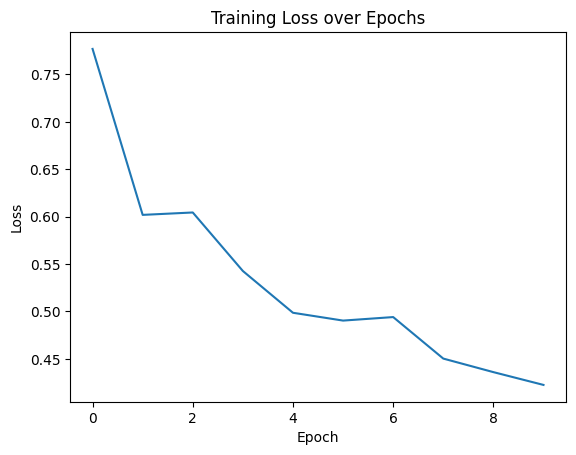

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▄▅▇▇▆███
Train_loss,█▅▅▃▃▂▂▂▁▁
Val_accuracy,▁▄▄▆▆▇▇███
Val_loss,█▄▄▃▃▂▂▁▁▁
Epoch,9
Train_accuracy,84.62778
Train_loss,0.42257
Val_accuracy,83.93333
Val_loss,0.45451


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g7u468dp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7193, Train_Accuracy: 70.96%, Val_Loss: 0.7306, Val_Accuracy: 69.92%
Epoch 2, Train_Loss: 0.6534, Train_Accuracy: 75.64%, Val_Loss: 0.6588, Val_Accuracy: 75.43%
Epoch 3, Train_Loss: 0.6095, Train_Accuracy: 76.96%, Val_Loss: 0.6249, Val_Accuracy: 76.20%
Epoch 4, Train_Loss: 0.5587, Train_Accuracy: 78.69%, Val_Loss: 0.5782, Val_Accuracy: 78.27%
Epoch 5, Train_Loss: 0.5151, Train_Accuracy: 81.58%, Val_Loss: 0.5373, Val_Accuracy: 80.78%
Epoch 6, Train_Loss: 0.4715, Train_Accuracy: 82.74%, Val_Loss: 0.4737, Val_Accuracy: 82.72%
Epoch 7, Train_Loss: 0.4608, Train_Accuracy: 82.92%, Val_Loss: 0.4874, Val_Accuracy: 82.03%
Epoch 8, Train_Loss: 0.4465, Train_Accuracy: 83.10%, Val_Loss: 0.4569, Val_Accuracy: 83.00%
Epoch 9, Train_Loss: 0.4375, Train_Accuracy: 83.80%, Val_Loss: 0.4739, Val_Accuracy: 82.78%
Epoch 10, Train_Loss: 0.4139, Train_Accuracy: 84.84%, Val_Loss: 0.4489, Val_Accuracy: 84.23%


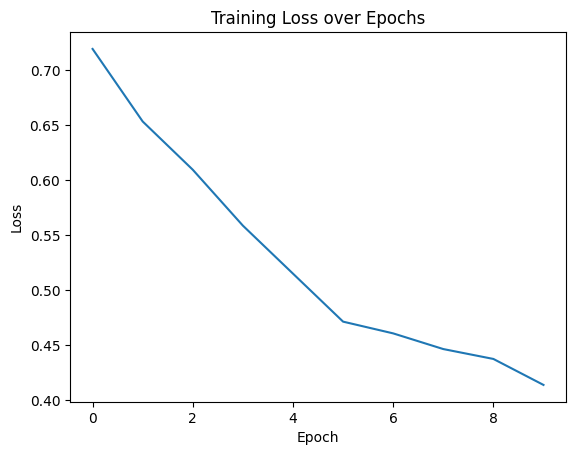

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▄▅▆▇▇▇▇█
Train_loss,█▆▅▄▃▂▂▂▂▁
Val_accuracy,▁▄▄▅▆▇▇▇▇█
Val_loss,█▆▅▄▃▂▂▁▂▁
Epoch,9
Train_accuracy,84.84074
Train_loss,0.41393
Val_accuracy,84.23333
Val_loss,0.44891


wandb: Agent Starting Run: ub0ahh3r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.4414, Train_Accuracy: 47.36%, Val_Loss: 1.4491, Val_Accuracy: 46.18%
Epoch 2, Train_Loss: 0.9369, Train_Accuracy: 64.38%, Val_Loss: 0.9509, Val_Accuracy: 63.07%
Epoch 3, Train_Loss: 0.8096, Train_Accuracy: 68.19%, Val_Loss: 0.8323, Val_Accuracy: 66.57%
Epoch 4, Train_Loss: 0.7337, Train_Accuracy: 70.36%, Val_Loss: 0.7492, Val_Accuracy: 69.55%
Epoch 5, Train_Loss: 0.6446, Train_Accuracy: 75.21%, Val_Loss: 0.6566, Val_Accuracy: 74.03%
Epoch 6, Train_Loss: 0.5956, Train_Accuracy: 77.07%, Val_Loss: 0.6067, Val_Accuracy: 76.38%
Epoch 7, Train_Loss: 0.6206, Train_Accuracy: 75.83%, Val_Loss: 0.6364, Val_Accuracy: 74.47%
Epoch 8, Train_Loss: 0.5723, Train_Accuracy: 79.46%, Val_Loss: 0.5833, Val_Accuracy: 78.45%
Epoch 9, Train_Loss: 0.5375, Train_Accuracy: 79.83%, Val_Loss: 0.5471, Val_Accuracy: 79.48%
Epoch 10, Train_Loss: 0.5042, Train_Accuracy: 81.60%, Val_Loss: 0.5187, Val_Accuracy: 80.47%


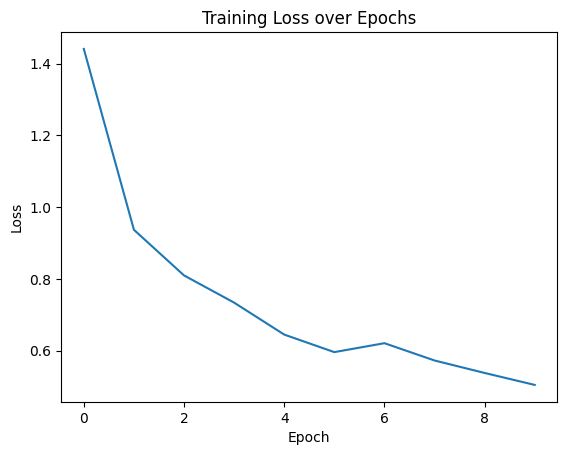

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▇▇▇███
Train_loss,█▄▃▃▂▂▂▂▁▁
Val_accuracy,▁▄▅▆▇▇▇███
Val_loss,█▄▃▃▂▂▂▁▁▁
Epoch,9
Train_accuracy,81.6
Train_loss,0.50416
Val_accuracy,80.46667
Val_loss,0.5187


wandb: Agent Starting Run: nhmbv39z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7912, Train_Accuracy: 70.77%, Val_Loss: 0.8098, Val_Accuracy: 70.33%
Epoch 2, Train_Loss: 0.6615, Train_Accuracy: 75.49%, Val_Loss: 0.6594, Val_Accuracy: 75.33%
Epoch 3, Train_Loss: 0.5955, Train_Accuracy: 77.93%, Val_Loss: 0.6123, Val_Accuracy: 77.65%
Epoch 4, Train_Loss: 0.5289, Train_Accuracy: 81.12%, Val_Loss: 0.5416, Val_Accuracy: 80.22%
Epoch 5, Train_Loss: 0.5232, Train_Accuracy: 81.10%, Val_Loss: 0.5340, Val_Accuracy: 80.63%
Epoch 6, Train_Loss: 0.4743, Train_Accuracy: 82.67%, Val_Loss: 0.4929, Val_Accuracy: 81.78%
Epoch 7, Train_Loss: 0.4611, Train_Accuracy: 83.44%, Val_Loss: 0.4856, Val_Accuracy: 82.73%
Epoch 8, Train_Loss: 0.4870, Train_Accuracy: 81.88%, Val_Loss: 0.5181, Val_Accuracy: 80.72%
Epoch 9, Train_Loss: 0.4558, Train_Accuracy: 82.76%, Val_Loss: 0.4732, Val_Accuracy: 82.57%
Epoch 10, Train_Loss: 0.3942, Train_Accuracy: 85.77%, Val_Loss: 0.4232, Val_Accuracy: 84.78%


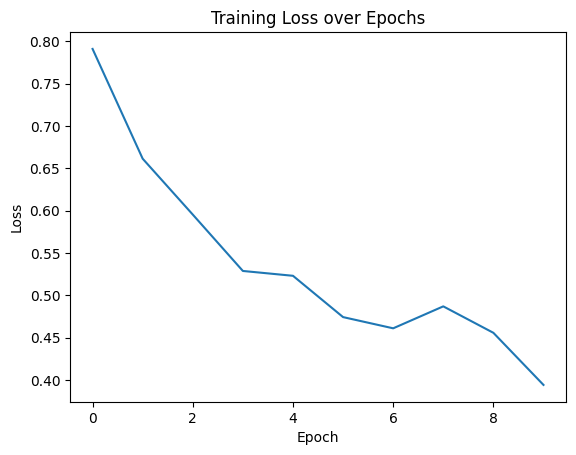

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▄▆▆▇▇▆▇█
Train_loss,█▆▅▃▃▂▂▃▂▁
Val_accuracy,▁▃▅▆▆▇▇▆▇█
Val_loss,█▅▄▃▃▂▂▃▂▁
Epoch,9
Train_accuracy,85.77407
Train_loss,0.39422
Val_accuracy,84.78333
Val_loss,0.42316


wandb: Agent Starting Run: q8qzlu92 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 2.0466, Train_Accuracy: 23.81%, Val_Loss: 2.0464, Val_Accuracy: 24.47%
Epoch 2, Train_Loss: 1.4669, Train_Accuracy: 38.41%, Val_Loss: 1.4710, Val_Accuracy: 38.78%
Epoch 3, Train_Loss: 1.1746, Train_Accuracy: 45.41%, Val_Loss: 1.1812, Val_Accuracy: 44.45%
Epoch 4, Train_Loss: 1.0597, Train_Accuracy: 49.00%, Val_Loss: 1.0676, Val_Accuracy: 48.40%
Epoch 5, Train_Loss: 0.9610, Train_Accuracy: 54.68%, Val_Loss: 0.9739, Val_Accuracy: 53.53%
Epoch 6, Train_Loss: 0.8332, Train_Accuracy: 60.96%, Val_Loss: 0.8435, Val_Accuracy: 60.40%
Epoch 7, Train_Loss: 0.8429, Train_Accuracy: 64.83%, Val_Loss: 0.8547, Val_Accuracy: 63.93%
Epoch 8, Train_Loss: 0.7811, Train_Accuracy: 69.44%, Val_Loss: 0.7956, Val_Accuracy: 68.32%
Epoch 9, Train_Loss: 0.7489, Train_Accuracy: 71.07%, Val_Loss: 0.7708, Val_Accuracy: 70.42%
Epoch 10, Train_Loss: 0.6746, Train_Accuracy: 73.88%, Val_Loss: 0.7005, Val_Accuracy: 72.52%


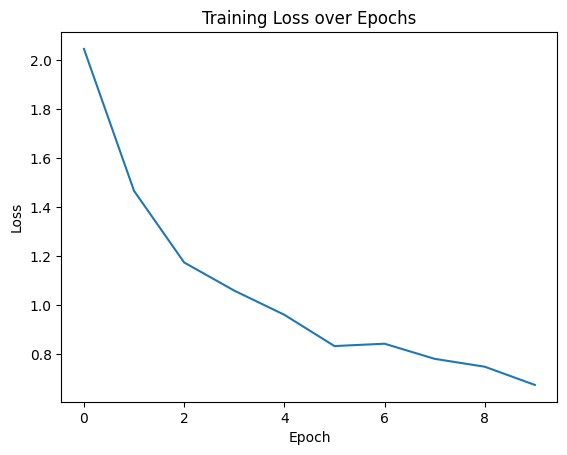

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▄▅▅▆▇▇██
Train_loss,█▅▄▃▂▂▂▂▁▁
Val_accuracy,▁▃▄▄▅▆▇▇██
Val_loss,█▅▄▃▂▂▂▁▁▁
Epoch,9
Train_accuracy,73.87778
Train_loss,0.67456
Val_accuracy,72.51667
Val_loss,0.70047


wandb: Agent Starting Run: 6cteslmq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.8196, Train_Accuracy: 69.59%, Val_Loss: 0.8317, Val_Accuracy: 69.50%
Epoch 2, Train_Loss: 0.5885, Train_Accuracy: 78.33%, Val_Loss: 0.5958, Val_Accuracy: 77.87%
Epoch 3, Train_Loss: 0.5669, Train_Accuracy: 78.82%, Val_Loss: 0.5747, Val_Accuracy: 78.37%
Epoch 4, Train_Loss: 0.5617, Train_Accuracy: 80.39%, Val_Loss: 0.5810, Val_Accuracy: 80.28%
Epoch 5, Train_Loss: 0.5163, Train_Accuracy: 80.78%, Val_Loss: 0.5206, Val_Accuracy: 80.68%
Epoch 6, Train_Loss: 0.4880, Train_Accuracy: 82.24%, Val_Loss: 0.5052, Val_Accuracy: 81.38%
Epoch 7, Train_Loss: 0.4541, Train_Accuracy: 83.43%, Val_Loss: 0.4783, Val_Accuracy: 82.32%
Epoch 8, Train_Loss: 0.4818, Train_Accuracy: 81.74%, Val_Loss: 0.5014, Val_Accuracy: 81.35%
Epoch 9, Train_Loss: 0.3968, Train_Accuracy: 85.73%, Val_Loss: 0.4243, Val_Accuracy: 84.75%
Epoch 10, Train_Loss: 0.3976, Train_Accuracy: 85.46%, Val_Loss: 0.4205, Val_Accuracy: 85.02%


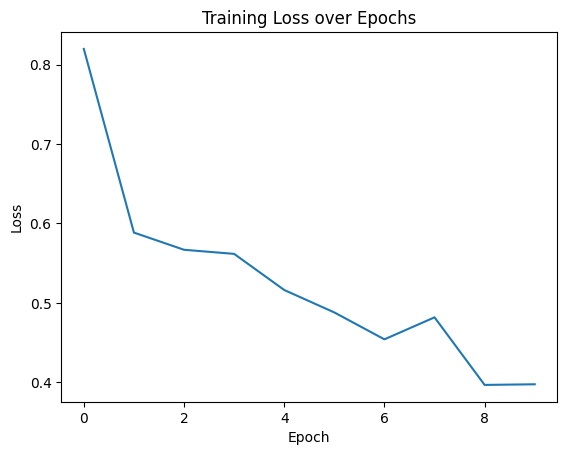

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▅▆▆▆▇▆██
Train_loss,█▄▄▄▃▃▂▂▁▁
Val_accuracy,▁▅▅▆▆▆▇▆██
Val_loss,█▄▄▄▃▂▂▂▁▁
Epoch,9
Train_accuracy,85.45926
Train_loss,0.3976
Val_accuracy,85.01667
Val_loss,0.42045


wandb: Agent Starting Run: ff1wceqs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.8720, Train_Accuracy: 66.07%, Val_Loss: 0.8934, Val_Accuracy: 65.37%
Epoch 2, Train_Loss: 0.5913, Train_Accuracy: 78.53%, Val_Loss: 0.6142, Val_Accuracy: 77.62%
Epoch 3, Train_Loss: 0.5634, Train_Accuracy: 78.91%, Val_Loss: 0.5870, Val_Accuracy: 78.38%
Epoch 4, Train_Loss: 0.5153, Train_Accuracy: 81.92%, Val_Loss: 0.5349, Val_Accuracy: 81.20%
Epoch 5, Train_Loss: 0.5186, Train_Accuracy: 81.80%, Val_Loss: 0.5345, Val_Accuracy: 81.75%
Epoch 6, Train_Loss: 0.5125, Train_Accuracy: 81.63%, Val_Loss: 0.5279, Val_Accuracy: 81.20%
Epoch 7, Train_Loss: 0.4753, Train_Accuracy: 82.73%, Val_Loss: 0.4920, Val_Accuracy: 81.97%
Epoch 8, Train_Loss: 0.4462, Train_Accuracy: 83.89%, Val_Loss: 0.4669, Val_Accuracy: 83.32%
Epoch 9, Train_Loss: 0.4286, Train_Accuracy: 84.74%, Val_Loss: 0.4579, Val_Accuracy: 83.93%
Epoch 10, Train_Loss: 0.4381, Train_Accuracy: 84.34%, Val_Loss: 0.4695, Val_Accuracy: 83.53%


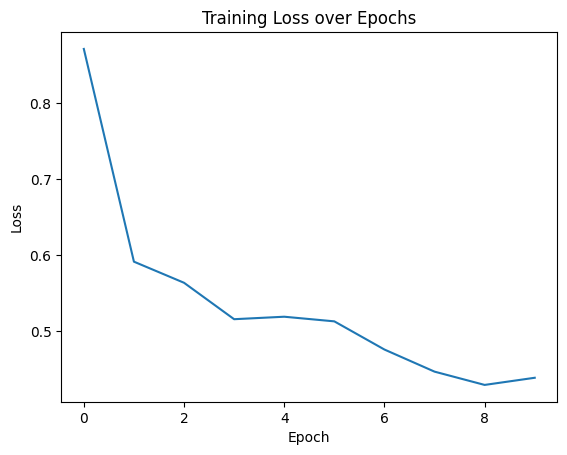

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▆▆▇▇▇▇███
Train_loss,█▄▃▂▂▂▂▁▁▁
Val_accuracy,▁▆▆▇▇▇▇███
Val_loss,█▄▃▂▂▂▂▁▁▁
Epoch,9
Train_accuracy,84.34444
Train_loss,0.43807
Val_accuracy,83.53333
Val_loss,0.46953


wandb: Agent Starting Run: qsjzfpk2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7610, Train_Accuracy: 70.90%, Val_Loss: 0.7855, Val_Accuracy: 70.08%
Epoch 2, Train_Loss: 0.6410, Train_Accuracy: 77.82%, Val_Loss: 0.6547, Val_Accuracy: 76.78%
Epoch 3, Train_Loss: 0.5524, Train_Accuracy: 79.84%, Val_Loss: 0.5701, Val_Accuracy: 78.65%
Epoch 4, Train_Loss: 0.5843, Train_Accuracy: 77.18%, Val_Loss: 0.6199, Val_Accuracy: 76.25%
Epoch 5, Train_Loss: 0.5346, Train_Accuracy: 80.51%, Val_Loss: 0.5534, Val_Accuracy: 80.08%
Epoch 6, Train_Loss: 0.4761, Train_Accuracy: 81.94%, Val_Loss: 0.4953, Val_Accuracy: 81.15%
Epoch 7, Train_Loss: 0.4651, Train_Accuracy: 82.75%, Val_Loss: 0.4872, Val_Accuracy: 82.08%
Epoch 8, Train_Loss: 0.4533, Train_Accuracy: 82.70%, Val_Loss: 0.4799, Val_Accuracy: 82.32%
Epoch 9, Train_Loss: 0.4280, Train_Accuracy: 84.06%, Val_Loss: 0.4509, Val_Accuracy: 82.95%
Epoch 10, Train_Loss: 0.4012, Train_Accuracy: 85.09%, Val_Loss: 0.4310, Val_Accuracy: 84.93%


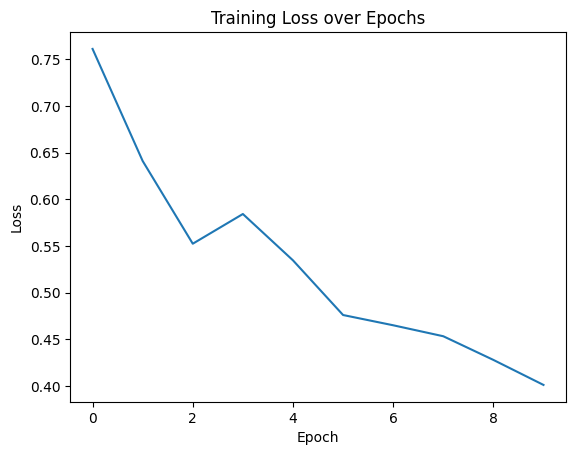

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▄▆▆▇▇▇█
Train_loss,█▆▄▅▄▂▂▂▂▁
Val_accuracy,▁▄▅▄▆▆▇▇▇█
Val_loss,█▅▄▅▃▂▂▂▁▁
Epoch,9
Train_accuracy,85.08704
Train_loss,0.40121
Val_accuracy,84.93333
Val_loss,0.43099


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ygd1eqbu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7676, Train_Accuracy: 72.02%, Val_Loss: 0.7760, Val_Accuracy: 71.13%
Epoch 2, Train_Loss: 0.6839, Train_Accuracy: 75.22%, Val_Loss: 0.6983, Val_Accuracy: 74.53%
Epoch 3, Train_Loss: 0.5861, Train_Accuracy: 78.67%, Val_Loss: 0.6057, Val_Accuracy: 77.87%
Epoch 4, Train_Loss: 0.5260, Train_Accuracy: 81.33%, Val_Loss: 0.5481, Val_Accuracy: 80.32%
Epoch 5, Train_Loss: 0.4927, Train_Accuracy: 82.53%, Val_Loss: 0.5218, Val_Accuracy: 81.58%
Epoch 6, Train_Loss: 0.4621, Train_Accuracy: 83.04%, Val_Loss: 0.4941, Val_Accuracy: 82.12%
Epoch 7, Train_Loss: 0.4211, Train_Accuracy: 84.94%, Val_Loss: 0.4418, Val_Accuracy: 84.07%
Epoch 8, Train_Loss: 0.4541, Train_Accuracy: 83.89%, Val_Loss: 0.4843, Val_Accuracy: 82.97%
Epoch 9, Train_Loss: 0.4586, Train_Accuracy: 83.17%, Val_Loss: 0.4873, Val_Accuracy: 82.35%
Epoch 10, Train_Loss: 0.4476, Train_Accuracy: 82.23%, Val_Loss: 0.4790, Val_Accuracy: 81.15%


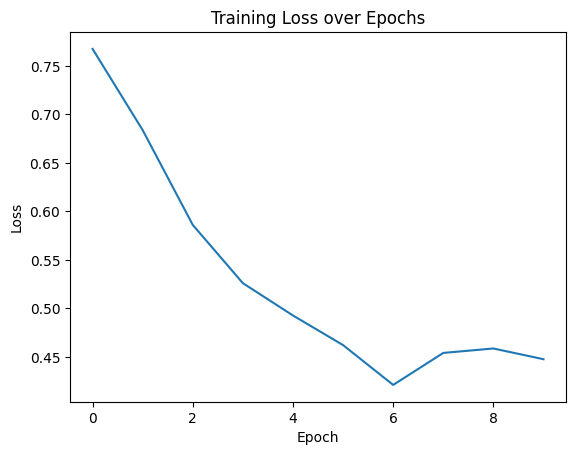

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▅▆▇▇█▇▇▇
Train_loss,█▆▄▃▂▂▁▂▂▂
Val_accuracy,▁▃▅▆▇▇█▇▇▆
Val_loss,█▆▄▃▃▂▁▂▂▂
Epoch,9
Train_accuracy,82.22963
Train_loss,0.44758
Val_accuracy,81.15
Val_loss,0.47898


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4nifehag with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7253, Train_Accuracy: 73.71%, Val_Loss: 0.7335, Val_Accuracy: 72.87%
Epoch 2, Train_Loss: 0.5960, Train_Accuracy: 78.12%, Val_Loss: 0.6171, Val_Accuracy: 77.18%
Epoch 3, Train_Loss: 0.5452, Train_Accuracy: 80.34%, Val_Loss: 0.5629, Val_Accuracy: 79.63%
Epoch 4, Train_Loss: 0.5302, Train_Accuracy: 80.74%, Val_Loss: 0.5467, Val_Accuracy: 81.00%
Epoch 5, Train_Loss: 0.5080, Train_Accuracy: 80.42%, Val_Loss: 0.5218, Val_Accuracy: 79.68%
Epoch 6, Train_Loss: 0.4850, Train_Accuracy: 82.16%, Val_Loss: 0.5104, Val_Accuracy: 81.52%
Epoch 7, Train_Loss: 0.4712, Train_Accuracy: 82.26%, Val_Loss: 0.4972, Val_Accuracy: 81.08%
Epoch 8, Train_Loss: 0.4589, Train_Accuracy: 83.31%, Val_Loss: 0.4757, Val_Accuracy: 82.75%
Epoch 9, Train_Loss: 0.4337, Train_Accuracy: 84.32%, Val_Loss: 0.4659, Val_Accuracy: 83.28%
Epoch 10, Train_Loss: 0.4203, Train_Accuracy: 84.51%, Val_Loss: 0.4373, Val_Accuracy: 83.88%


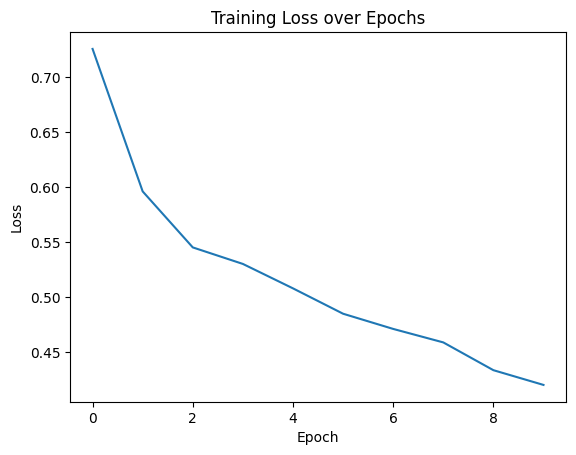

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▅▆▇▇██
Train_loss,█▅▄▄▃▂▂▂▁▁
Val_accuracy,▁▄▅▆▅▆▆▇██
Val_loss,█▅▄▄▃▃▂▂▂▁
Epoch,9
Train_accuracy,84.51296
Train_loss,0.42035
Val_accuracy,83.88333
Val_loss,0.43734


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qitg9vvl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.9355, Train_Accuracy: 66.76%, Val_Loss: 0.9387, Val_Accuracy: 66.43%
Epoch 2, Train_Loss: 0.6686, Train_Accuracy: 76.54%, Val_Loss: 0.6762, Val_Accuracy: 76.20%
Epoch 3, Train_Loss: 0.6366, Train_Accuracy: 78.02%, Val_Loss: 0.6411, Val_Accuracy: 78.10%
Epoch 4, Train_Loss: 0.5463, Train_Accuracy: 80.34%, Val_Loss: 0.5702, Val_Accuracy: 79.47%
Epoch 5, Train_Loss: 0.5183, Train_Accuracy: 81.31%, Val_Loss: 0.5303, Val_Accuracy: 81.23%
Epoch 6, Train_Loss: 0.5208, Train_Accuracy: 81.59%, Val_Loss: 0.5359, Val_Accuracy: 81.20%
Epoch 7, Train_Loss: 0.4770, Train_Accuracy: 82.89%, Val_Loss: 0.5025, Val_Accuracy: 82.03%
Epoch 8, Train_Loss: 0.4358, Train_Accuracy: 83.51%, Val_Loss: 0.4548, Val_Accuracy: 83.17%
Epoch 9, Train_Loss: 0.4375, Train_Accuracy: 84.31%, Val_Loss: 0.4719, Val_Accuracy: 83.47%
Epoch 10, Train_Loss: 0.4285, Train_Accuracy: 85.00%, Val_Loss: 0.4636, Val_Accuracy: 84.40%


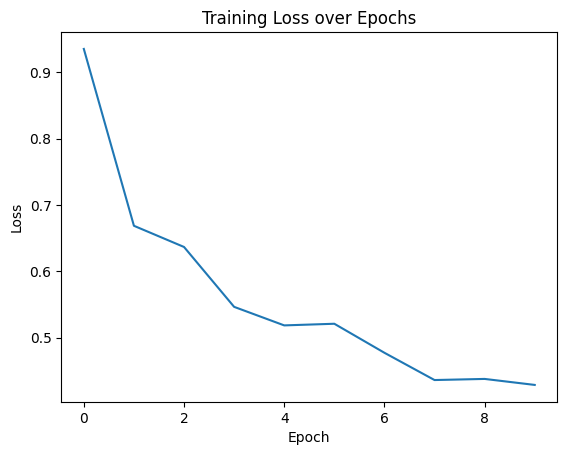

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▅▆▇▇▇▇██
Train_loss,█▄▄▃▂▂▂▁▁▁
Val_accuracy,▁▅▆▆▇▇▇███
Val_loss,█▄▄▃▂▂▂▁▁▁
Epoch,9
Train_accuracy,84.99815
Train_loss,0.42846
Val_accuracy,84.4
Val_loss,0.4636


wandb: Agent Starting Run: 9p429tx1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7712, Train_Accuracy: 70.91%, Val_Loss: 0.7770, Val_Accuracy: 70.13%
Epoch 2, Train_Loss: 0.6339, Train_Accuracy: 75.85%, Val_Loss: 0.6525, Val_Accuracy: 75.42%
Epoch 3, Train_Loss: 0.5512, Train_Accuracy: 79.74%, Val_Loss: 0.5543, Val_Accuracy: 79.12%
Epoch 4, Train_Loss: 0.5346, Train_Accuracy: 81.83%, Val_Loss: 0.5573, Val_Accuracy: 81.20%
Epoch 5, Train_Loss: 0.5026, Train_Accuracy: 81.67%, Val_Loss: 0.5322, Val_Accuracy: 80.85%
Epoch 6, Train_Loss: 0.4684, Train_Accuracy: 82.68%, Val_Loss: 0.4917, Val_Accuracy: 82.27%
Epoch 7, Train_Loss: 0.4510, Train_Accuracy: 83.38%, Val_Loss: 0.4861, Val_Accuracy: 82.45%
Epoch 8, Train_Loss: 0.4168, Train_Accuracy: 85.05%, Val_Loss: 0.4515, Val_Accuracy: 84.23%
Epoch 9, Train_Loss: 0.4636, Train_Accuracy: 82.91%, Val_Loss: 0.4926, Val_Accuracy: 82.00%
Epoch 10, Train_Loss: 0.4232, Train_Accuracy: 85.19%, Val_Loss: 0.4520, Val_Accuracy: 84.43%


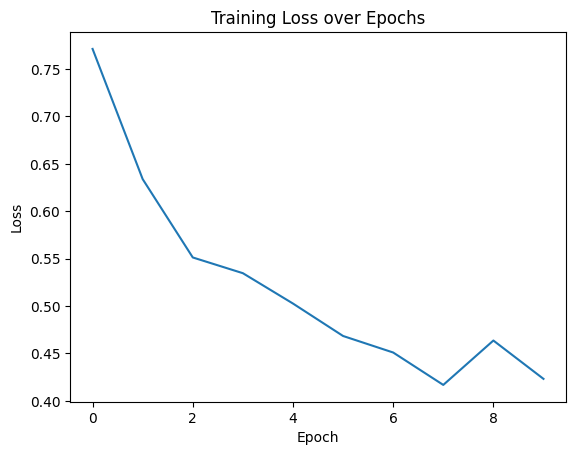

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▅▆▆▇▇█▇█
Train_loss,█▅▄▃▃▂▂▁▂▁
Val_accuracy,▁▄▅▆▆▇▇█▇█
Val_loss,█▅▃▃▃▂▂▁▂▁
Epoch,9
Train_accuracy,85.19259
Train_loss,0.42317
Val_accuracy,84.43333
Val_loss,0.45204


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dj03b2lv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.8692, Train_Accuracy: 68.65%, Val_Loss: 0.8862, Val_Accuracy: 67.37%
Epoch 2, Train_Loss: 0.7352, Train_Accuracy: 72.89%, Val_Loss: 0.7603, Val_Accuracy: 72.03%
Epoch 3, Train_Loss: 0.6134, Train_Accuracy: 75.88%, Val_Loss: 0.6348, Val_Accuracy: 74.87%
Epoch 4, Train_Loss: 0.5720, Train_Accuracy: 78.70%, Val_Loss: 0.5902, Val_Accuracy: 77.93%
Epoch 5, Train_Loss: 0.5354, Train_Accuracy: 80.38%, Val_Loss: 0.5564, Val_Accuracy: 79.60%
Epoch 6, Train_Loss: 0.5037, Train_Accuracy: 82.50%, Val_Loss: 0.5166, Val_Accuracy: 81.80%
Epoch 7, Train_Loss: 0.4756, Train_Accuracy: 83.42%, Val_Loss: 0.4977, Val_Accuracy: 82.17%
Epoch 8, Train_Loss: 0.4792, Train_Accuracy: 82.94%, Val_Loss: 0.4997, Val_Accuracy: 81.98%
Epoch 9, Train_Loss: 0.4897, Train_Accuracy: 81.48%, Val_Loss: 0.5133, Val_Accuracy: 80.98%
Epoch 10, Train_Loss: 0.4814, Train_Accuracy: 83.67%, Val_Loss: 0.5049, Val_Accuracy: 82.78%


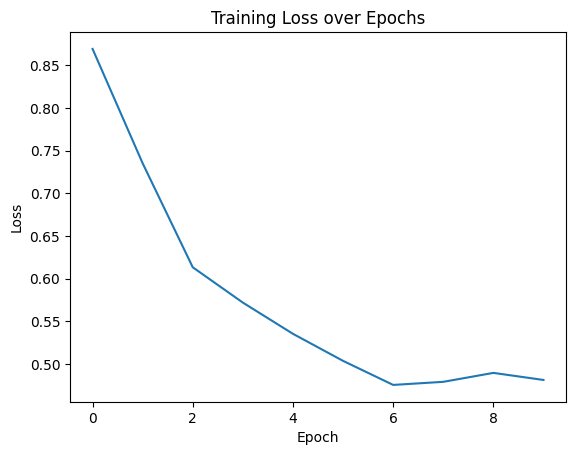

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▄▆▆▇██▇█
Train_loss,█▆▃▃▂▂▁▁▁▁
Val_accuracy,▁▃▄▆▇███▇█
Val_loss,█▆▃▃▂▁▁▁▁▁
Epoch,9
Train_accuracy,83.67037
Train_loss,0.4814
Val_accuracy,82.78333
Val_loss,0.50493


wandb: Agent Starting Run: 493ihp8r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.4473, Train_Accuracy: 47.97%, Val_Loss: 1.4521, Val_Accuracy: 47.68%
Epoch 2, Train_Loss: 0.9871, Train_Accuracy: 60.86%, Val_Loss: 0.9932, Val_Accuracy: 60.72%
Epoch 3, Train_Loss: 0.7893, Train_Accuracy: 70.46%, Val_Loss: 0.8000, Val_Accuracy: 69.18%
Epoch 4, Train_Loss: 0.6796, Train_Accuracy: 72.80%, Val_Loss: 0.6957, Val_Accuracy: 71.47%
Epoch 5, Train_Loss: 0.6337, Train_Accuracy: 76.35%, Val_Loss: 0.6484, Val_Accuracy: 74.88%
Epoch 6, Train_Loss: 0.6694, Train_Accuracy: 73.63%, Val_Loss: 0.6821, Val_Accuracy: 73.00%
Epoch 7, Train_Loss: 0.5989, Train_Accuracy: 78.59%, Val_Loss: 0.6256, Val_Accuracy: 77.67%
Epoch 8, Train_Loss: 0.5224, Train_Accuracy: 81.41%, Val_Loss: 0.5362, Val_Accuracy: 80.82%
Epoch 9, Train_Loss: 0.5437, Train_Accuracy: 80.34%, Val_Loss: 0.5586, Val_Accuracy: 79.88%
Epoch 10, Train_Loss: 0.5099, Train_Accuracy: 82.00%, Val_Loss: 0.5298, Val_Accuracy: 81.48%


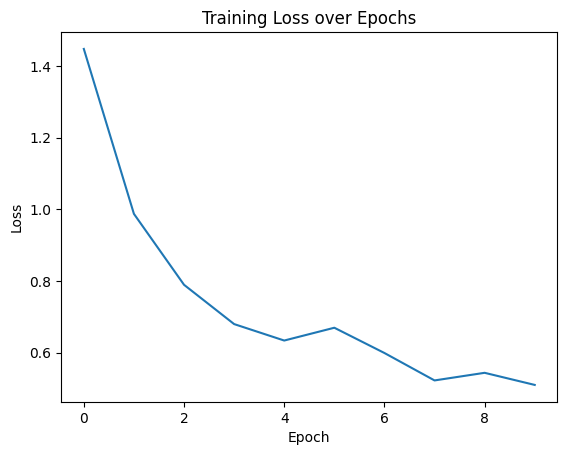

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▆▆▇▆▇███
Train_loss,█▅▃▂▂▂▂▁▁▁
Val_accuracy,▁▄▅▆▇▆▇███
Val_loss,█▅▃▂▂▂▂▁▁▁
Epoch,9
Train_accuracy,81.9963
Train_loss,0.50988
Val_accuracy,81.48333
Val_loss,0.52984


wandb: Agent Starting Run: n58hlg7e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.6497, Train_Accuracy: 42.25%, Val_Loss: 1.6562, Val_Accuracy: 41.82%
Epoch 2, Train_Loss: 1.1026, Train_Accuracy: 64.26%, Val_Loss: 1.1110, Val_Accuracy: 63.02%
Epoch 3, Train_Loss: 0.7883, Train_Accuracy: 70.73%, Val_Loss: 0.8003, Val_Accuracy: 69.52%
Epoch 4, Train_Loss: 0.6449, Train_Accuracy: 76.26%, Val_Loss: 0.6609, Val_Accuracy: 75.07%
Epoch 5, Train_Loss: 0.6171, Train_Accuracy: 76.96%, Val_Loss: 0.6267, Val_Accuracy: 76.03%
Epoch 6, Train_Loss: 0.6030, Train_Accuracy: 75.76%, Val_Loss: 0.6172, Val_Accuracy: 74.70%
Epoch 7, Train_Loss: 0.5772, Train_Accuracy: 77.90%, Val_Loss: 0.5922, Val_Accuracy: 77.22%
Epoch 8, Train_Loss: 0.5945, Train_Accuracy: 77.72%, Val_Loss: 0.6186, Val_Accuracy: 76.98%
Epoch 9, Train_Loss: 0.5239, Train_Accuracy: 81.22%, Val_Loss: 0.5400, Val_Accuracy: 80.22%
Epoch 10, Train_Loss: 0.5021, Train_Accuracy: 81.24%, Val_Loss: 0.5271, Val_Accuracy: 80.37%


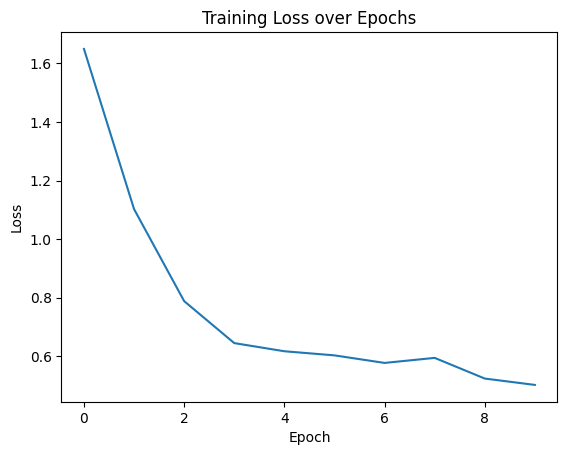

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▆▇▇▇▇▇██
Train_loss,█▅▃▂▂▂▁▂▁▁
Val_accuracy,▁▅▆▇▇▇▇▇██
Val_loss,█▅▃▂▂▂▁▂▁▁
Epoch,9
Train_accuracy,81.24444
Train_loss,0.5021
Val_accuracy,80.36667
Val_loss,0.52706


wandb: Agent Starting Run: aat8xl7t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.9286, Train_Accuracy: 67.88%, Val_Loss: 0.9667, Val_Accuracy: 66.72%
Epoch 2, Train_Loss: 0.7075, Train_Accuracy: 73.77%, Val_Loss: 0.7131, Val_Accuracy: 73.28%
Epoch 3, Train_Loss: 0.6025, Train_Accuracy: 78.44%, Val_Loss: 0.6180, Val_Accuracy: 77.98%
Epoch 4, Train_Loss: 0.5456, Train_Accuracy: 77.96%, Val_Loss: 0.5662, Val_Accuracy: 77.77%
Epoch 5, Train_Loss: 0.4880, Train_Accuracy: 83.20%, Val_Loss: 0.4936, Val_Accuracy: 82.72%
Epoch 6, Train_Loss: 0.4897, Train_Accuracy: 81.96%, Val_Loss: 0.5076, Val_Accuracy: 81.30%
Epoch 7, Train_Loss: 0.4823, Train_Accuracy: 82.25%, Val_Loss: 0.5031, Val_Accuracy: 81.47%
Epoch 8, Train_Loss: 0.4452, Train_Accuracy: 83.52%, Val_Loss: 0.4643, Val_Accuracy: 83.00%
Epoch 9, Train_Loss: 0.4311, Train_Accuracy: 83.78%, Val_Loss: 0.4471, Val_Accuracy: 83.58%
Epoch 10, Train_Loss: 0.4712, Train_Accuracy: 82.73%, Val_Loss: 0.4934, Val_Accuracy: 81.72%


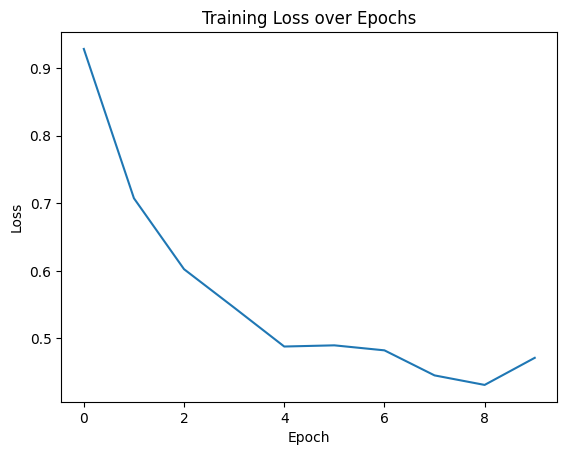

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▆▅█▇▇███
Train_loss,█▅▃▃▂▂▂▁▁▂
Val_accuracy,▁▄▆▆█▇▇██▇
Val_loss,█▅▃▃▂▂▂▁▁▂
Epoch,9
Train_accuracy,82.72593
Train_loss,0.47123
Val_accuracy,81.71667
Val_loss,0.49339


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2axheg26 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.8548, Train_Accuracy: 20.93%, Val_Loss: 1.8598, Val_Accuracy: 20.52%
Epoch 2, Train_Loss: 1.2687, Train_Accuracy: 50.35%, Val_Loss: 1.2728, Val_Accuracy: 50.13%
Epoch 3, Train_Loss: 0.9788, Train_Accuracy: 58.27%, Val_Loss: 0.9859, Val_Accuracy: 58.17%
Epoch 4, Train_Loss: 0.7964, Train_Accuracy: 65.91%, Val_Loss: 0.8087, Val_Accuracy: 64.83%
Epoch 5, Train_Loss: 0.8592, Train_Accuracy: 63.31%, Val_Loss: 0.8796, Val_Accuracy: 62.35%
Epoch 6, Train_Loss: 0.7296, Train_Accuracy: 71.41%, Val_Loss: 0.7403, Val_Accuracy: 71.25%
Epoch 7, Train_Loss: 0.6519, Train_Accuracy: 77.63%, Val_Loss: 0.6684, Val_Accuracy: 76.82%
Epoch 8, Train_Loss: 0.6647, Train_Accuracy: 74.37%, Val_Loss: 0.6794, Val_Accuracy: 73.72%
Epoch 9, Train_Loss: 0.6055, Train_Accuracy: 77.03%, Val_Loss: 0.6214, Val_Accuracy: 76.02%
Epoch 10, Train_Loss: 0.5232, Train_Accuracy: 81.10%, Val_Loss: 0.5462, Val_Accuracy: 80.03%


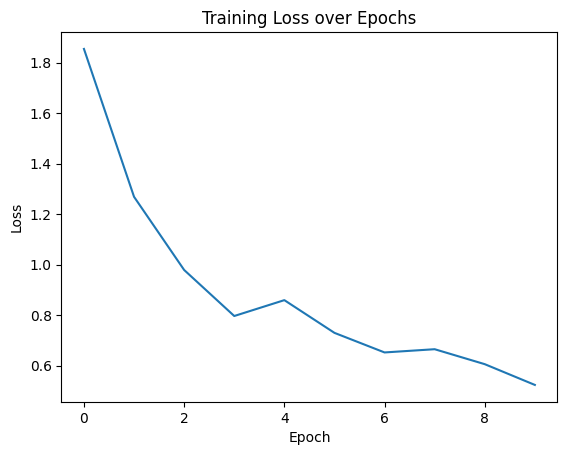

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▆▇█▇██
Train_loss,█▅▃▂▃▂▂▂▁▁
Val_accuracy,▁▄▅▆▆▇█▇██
Val_loss,█▅▃▂▃▂▂▂▁▁
Epoch,9
Train_accuracy,81.1
Train_loss,0.52324
Val_accuracy,80.03333
Val_loss,0.54623


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uiemv5fx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.0980, Train_Accuracy: 56.88%, Val_Loss: 1.1070, Val_Accuracy: 55.12%
Epoch 2, Train_Loss: 0.6540, Train_Accuracy: 76.10%, Val_Loss: 0.6609, Val_Accuracy: 75.52%
Epoch 3, Train_Loss: 0.5521, Train_Accuracy: 81.56%, Val_Loss: 0.5799, Val_Accuracy: 80.30%
Epoch 4, Train_Loss: 0.5623, Train_Accuracy: 79.74%, Val_Loss: 0.5763, Val_Accuracy: 78.68%
Epoch 5, Train_Loss: 0.4886, Train_Accuracy: 82.55%, Val_Loss: 0.5145, Val_Accuracy: 81.72%
Epoch 6, Train_Loss: 0.4483, Train_Accuracy: 84.07%, Val_Loss: 0.4728, Val_Accuracy: 82.98%
Epoch 7, Train_Loss: 0.4594, Train_Accuracy: 83.19%, Val_Loss: 0.4918, Val_Accuracy: 82.07%
Epoch 8, Train_Loss: 0.3974, Train_Accuracy: 85.93%, Val_Loss: 0.4219, Val_Accuracy: 85.13%
Epoch 9, Train_Loss: 0.4143, Train_Accuracy: 84.83%, Val_Loss: 0.4384, Val_Accuracy: 83.90%
Epoch 10, Train_Loss: 0.3807, Train_Accuracy: 86.55%, Val_Loss: 0.4130, Val_Accuracy: 85.62%


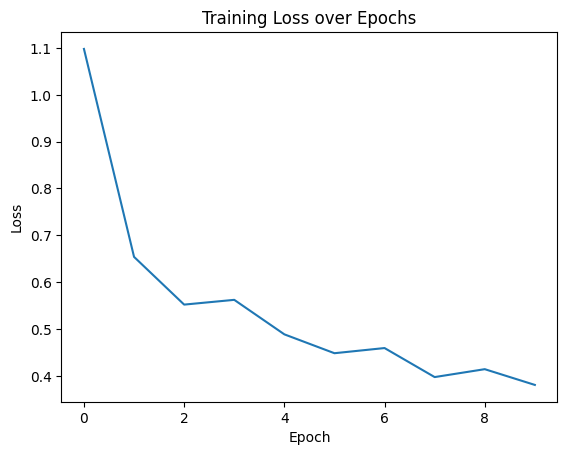

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▆▇▆▇▇▇███
Train_loss,█▄▃▃▂▂▂▁▁▁
Val_accuracy,▁▆▇▆▇▇▇███
Val_loss,█▄▃▃▂▂▂▁▁▁
Epoch,9
Train_accuracy,86.55
Train_loss,0.38066
Val_accuracy,85.61667
Val_loss,0.41302


wandb: Agent Starting Run: vkgsfl42 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.8075, Train_Accuracy: 20.66%, Val_Loss: 1.8115, Val_Accuracy: 20.55%
Epoch 2, Train_Loss: 1.3535, Train_Accuracy: 48.81%, Val_Loss: 1.3618, Val_Accuracy: 48.33%
Epoch 3, Train_Loss: 1.1000, Train_Accuracy: 55.51%, Val_Loss: 1.1049, Val_Accuracy: 54.73%
Epoch 4, Train_Loss: 0.9098, Train_Accuracy: 62.58%, Val_Loss: 0.9145, Val_Accuracy: 61.23%
Epoch 5, Train_Loss: 0.8118, Train_Accuracy: 66.42%, Val_Loss: 0.8226, Val_Accuracy: 65.42%
Epoch 6, Train_Loss: 0.7103, Train_Accuracy: 71.82%, Val_Loss: 0.7116, Val_Accuracy: 71.33%
Epoch 7, Train_Loss: 0.6220, Train_Accuracy: 77.80%, Val_Loss: 0.6271, Val_Accuracy: 77.22%
Epoch 8, Train_Loss: 0.6378, Train_Accuracy: 77.82%, Val_Loss: 0.6535, Val_Accuracy: 76.92%
Epoch 9, Train_Loss: 0.5500, Train_Accuracy: 80.83%, Val_Loss: 0.5697, Val_Accuracy: 80.30%
Epoch 10, Train_Loss: 0.5243, Train_Accuracy: 81.73%, Val_Loss: 0.5403, Val_Accuracy: 80.83%


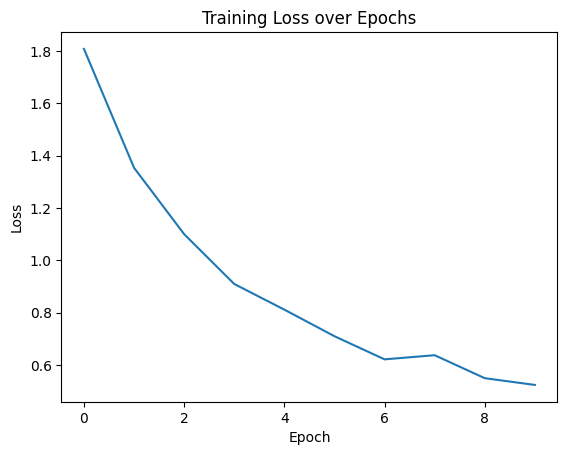

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▆▇████
Train_loss,█▆▄▃▃▂▂▂▁▁
Val_accuracy,▁▄▅▆▆▇████
Val_loss,█▆▄▃▃▂▁▂▁▁
Epoch,9
Train_accuracy,81.72778
Train_loss,0.52429
Val_accuracy,80.83333
Val_loss,0.5403


wandb: Agent Starting Run: f7cezbdg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.6962, Train_Accuracy: 23.52%, Val_Loss: 1.7003, Val_Accuracy: 22.47%
Epoch 2, Train_Loss: 1.2770, Train_Accuracy: 48.56%, Val_Loss: 1.2806, Val_Accuracy: 47.62%
Epoch 3, Train_Loss: 1.1131, Train_Accuracy: 54.90%, Val_Loss: 1.1245, Val_Accuracy: 54.07%
Epoch 4, Train_Loss: 0.9622, Train_Accuracy: 54.74%, Val_Loss: 0.9754, Val_Accuracy: 53.97%
Epoch 5, Train_Loss: 0.8596, Train_Accuracy: 65.71%, Val_Loss: 0.8723, Val_Accuracy: 64.87%
Epoch 6, Train_Loss: 0.7645, Train_Accuracy: 69.60%, Val_Loss: 0.7861, Val_Accuracy: 68.30%
Epoch 7, Train_Loss: 0.7808, Train_Accuracy: 68.52%, Val_Loss: 0.8063, Val_Accuracy: 67.38%
Epoch 8, Train_Loss: 0.7103, Train_Accuracy: 71.02%, Val_Loss: 0.7308, Val_Accuracy: 70.12%
Epoch 9, Train_Loss: 0.6777, Train_Accuracy: 72.50%, Val_Loss: 0.7030, Val_Accuracy: 71.47%
Epoch 10, Train_Loss: 0.6447, Train_Accuracy: 75.00%, Val_Loss: 0.6617, Val_Accuracy: 74.33%


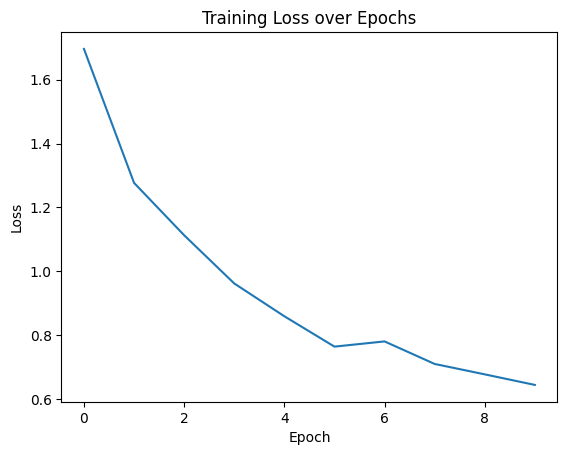

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▅▇▇▇▇██
Train_loss,█▅▄▃▂▂▂▁▁▁
Val_accuracy,▁▄▅▅▇▇▇▇██
Val_loss,█▅▄▃▂▂▂▁▁▁
Epoch,9
Train_accuracy,75
Train_loss,0.64467
Val_accuracy,74.33333
Val_loss,0.66169


wandb: Agent Starting Run: 6893acke with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.2475, Train_Accuracy: 50.42%, Val_Loss: 1.2592, Val_Accuracy: 49.38%
Epoch 2, Train_Loss: 0.8302, Train_Accuracy: 67.28%, Val_Loss: 0.8427, Val_Accuracy: 66.23%
Epoch 3, Train_Loss: 0.6300, Train_Accuracy: 76.73%, Val_Loss: 0.6433, Val_Accuracy: 76.00%
Epoch 4, Train_Loss: 0.5348, Train_Accuracy: 79.89%, Val_Loss: 0.5509, Val_Accuracy: 78.93%
Epoch 5, Train_Loss: 0.4738, Train_Accuracy: 82.76%, Val_Loss: 0.4959, Val_Accuracy: 81.97%
Epoch 6, Train_Loss: 0.4453, Train_Accuracy: 83.72%, Val_Loss: 0.4620, Val_Accuracy: 83.02%
Epoch 7, Train_Loss: 0.4294, Train_Accuracy: 84.84%, Val_Loss: 0.4557, Val_Accuracy: 83.65%
Epoch 8, Train_Loss: 0.4192, Train_Accuracy: 85.00%, Val_Loss: 0.4475, Val_Accuracy: 84.03%
Epoch 9, Train_Loss: 0.4283, Train_Accuracy: 84.40%, Val_Loss: 0.4576, Val_Accuracy: 83.15%
Epoch 10, Train_Loss: 0.4088, Train_Accuracy: 85.33%, Val_Loss: 0.4285, Val_Accuracy: 84.43%


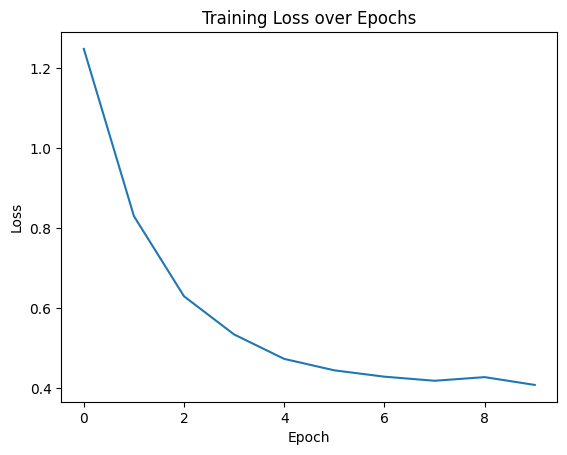

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▆▇▇█████
Train_loss,█▅▃▂▂▁▁▁▁▁
Val_accuracy,▁▄▆▇██████
Val_loss,█▄▃▂▂▁▁▁▁▁
Epoch,9
Train_accuracy,85.32963
Train_loss,0.40884
Val_accuracy,84.43333
Val_loss,0.42848


wandb: Agent Starting Run: lsrnces1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.9106, Train_Accuracy: 69.59%, Val_Loss: 0.9118, Val_Accuracy: 68.57%
Epoch 2, Train_Loss: 0.7389, Train_Accuracy: 71.99%, Val_Loss: 0.7508, Val_Accuracy: 71.37%
Epoch 3, Train_Loss: 0.6719, Train_Accuracy: 76.66%, Val_Loss: 0.6850, Val_Accuracy: 76.10%
Epoch 4, Train_Loss: 0.5509, Train_Accuracy: 80.52%, Val_Loss: 0.5701, Val_Accuracy: 79.95%
Epoch 5, Train_Loss: 0.5117, Train_Accuracy: 81.60%, Val_Loss: 0.5404, Val_Accuracy: 81.00%
Epoch 6, Train_Loss: 0.5185, Train_Accuracy: 81.16%, Val_Loss: 0.5387, Val_Accuracy: 81.02%
Epoch 7, Train_Loss: 0.5087, Train_Accuracy: 81.13%, Val_Loss: 0.5331, Val_Accuracy: 80.32%
Epoch 8, Train_Loss: 0.4593, Train_Accuracy: 83.49%, Val_Loss: 0.4805, Val_Accuracy: 83.05%
Epoch 9, Train_Loss: 0.4109, Train_Accuracy: 85.19%, Val_Loss: 0.4377, Val_Accuracy: 84.47%
Epoch 10, Train_Loss: 0.4222, Train_Accuracy: 83.94%, Val_Loss: 0.4447, Val_Accuracy: 83.50%


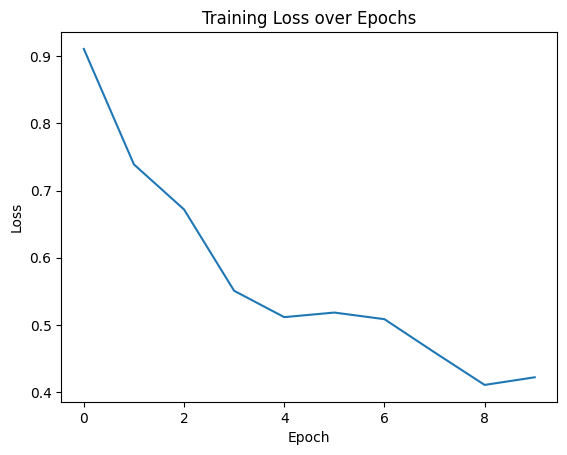

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▂▄▆▆▆▆▇█▇
Train_loss,█▆▅▃▂▃▂▂▁▁
Val_accuracy,▁▂▄▆▆▆▆▇██
Val_loss,█▆▅▃▃▂▂▂▁▁
Epoch,9
Train_accuracy,83.94444
Train_loss,0.42224
Val_accuracy,83.5
Val_loss,0.44468


wandb: Agent Starting Run: mc2ilct6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.1630, Train_Accuracy: 55.16%, Val_Loss: 1.1668, Val_Accuracy: 53.67%
Epoch 2, Train_Loss: 0.7478, Train_Accuracy: 69.75%, Val_Loss: 0.7554, Val_Accuracy: 68.18%
Epoch 3, Train_Loss: 0.6414, Train_Accuracy: 77.11%, Val_Loss: 0.6521, Val_Accuracy: 76.53%
Epoch 4, Train_Loss: 0.5877, Train_Accuracy: 78.96%, Val_Loss: 0.6127, Val_Accuracy: 78.08%
Epoch 5, Train_Loss: 0.5019, Train_Accuracy: 82.49%, Val_Loss: 0.5232, Val_Accuracy: 80.97%
Epoch 6, Train_Loss: 0.4825, Train_Accuracy: 83.68%, Val_Loss: 0.4960, Val_Accuracy: 83.12%
Epoch 7, Train_Loss: 0.4463, Train_Accuracy: 84.20%, Val_Loss: 0.4638, Val_Accuracy: 83.33%
Epoch 8, Train_Loss: 0.4056, Train_Accuracy: 85.94%, Val_Loss: 0.4260, Val_Accuracy: 84.75%
Epoch 9, Train_Loss: 0.4081, Train_Accuracy: 85.56%, Val_Loss: 0.4326, Val_Accuracy: 84.90%
Epoch 10, Train_Loss: 0.3970, Train_Accuracy: 86.28%, Val_Loss: 0.4176, Val_Accuracy: 84.82%


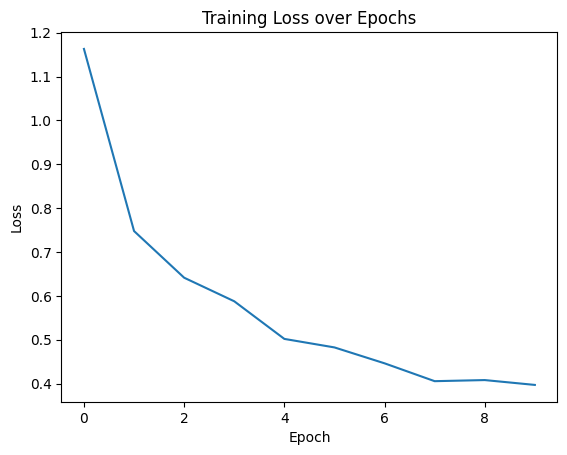

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▆▆▇▇████
Train_loss,█▄▃▃▂▂▁▁▁▁
Val_accuracy,▁▄▆▆▇█████
Val_loss,█▄▃▃▂▂▁▁▁▁
Epoch,9
Train_accuracy,86.27778
Train_loss,0.39703
Val_accuracy,84.81667
Val_loss,0.41761


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4v9ywwxb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.2235, Train_Accuracy: 38.30%, Val_Loss: 1.2330, Val_Accuracy: 38.42%
Epoch 2, Train_Loss: 0.7872, Train_Accuracy: 69.63%, Val_Loss: 0.7928, Val_Accuracy: 69.15%
Epoch 3, Train_Loss: 0.6070, Train_Accuracy: 76.37%, Val_Loss: 0.6160, Val_Accuracy: 75.60%
Epoch 4, Train_Loss: 0.5448, Train_Accuracy: 78.21%, Val_Loss: 0.5652, Val_Accuracy: 77.22%
Epoch 5, Train_Loss: 0.5043, Train_Accuracy: 81.87%, Val_Loss: 0.5245, Val_Accuracy: 80.82%
Epoch 6, Train_Loss: 0.4609, Train_Accuracy: 83.65%, Val_Loss: 0.4827, Val_Accuracy: 83.00%
Epoch 7, Train_Loss: 0.4439, Train_Accuracy: 84.49%, Val_Loss: 0.4689, Val_Accuracy: 83.18%
Epoch 8, Train_Loss: 0.4182, Train_Accuracy: 85.74%, Val_Loss: 0.4491, Val_Accuracy: 84.57%
Epoch 9, Train_Loss: 0.4107, Train_Accuracy: 85.76%, Val_Loss: 0.4272, Val_Accuracy: 84.95%
Epoch 10, Train_Loss: 0.4020, Train_Accuracy: 85.69%, Val_Loss: 0.4239, Val_Accuracy: 84.78%


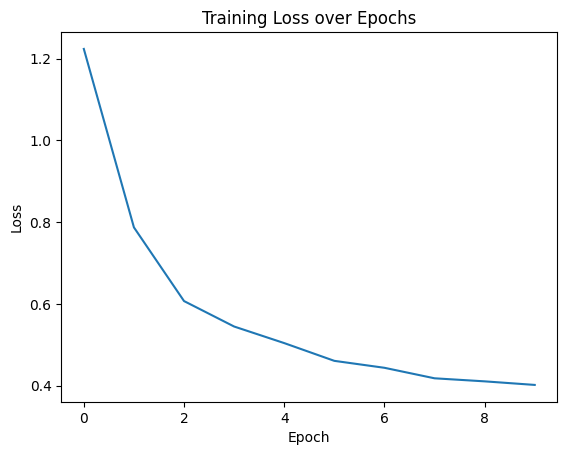

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▆▇▇▇█████
Train_loss,█▄▃▂▂▂▁▁▁▁
Val_accuracy,▁▆▇▇▇█████
Val_loss,█▄▃▂▂▂▁▁▁▁
Epoch,9
Train_accuracy,85.68704
Train_loss,0.40201
Val_accuracy,84.78333
Val_loss,0.42386


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: do1x292r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7376, Train_Accuracy: 69.83%, Val_Loss: 0.7524, Val_Accuracy: 68.95%
Epoch 2, Train_Loss: 0.7162, Train_Accuracy: 70.83%, Val_Loss: 0.7220, Val_Accuracy: 70.50%
Epoch 3, Train_Loss: 0.5870, Train_Accuracy: 78.45%, Val_Loss: 0.6013, Val_Accuracy: 78.03%
Epoch 4, Train_Loss: 0.5457, Train_Accuracy: 80.41%, Val_Loss: 0.5643, Val_Accuracy: 79.70%
Epoch 5, Train_Loss: 0.4913, Train_Accuracy: 82.21%, Val_Loss: 0.5050, Val_Accuracy: 81.85%
Epoch 6, Train_Loss: 0.4575, Train_Accuracy: 83.42%, Val_Loss: 0.4842, Val_Accuracy: 82.48%
Epoch 7, Train_Loss: 0.4736, Train_Accuracy: 83.06%, Val_Loss: 0.4965, Val_Accuracy: 82.37%
Epoch 8, Train_Loss: 0.4466, Train_Accuracy: 83.21%, Val_Loss: 0.4733, Val_Accuracy: 82.92%
Epoch 9, Train_Loss: 0.4448, Train_Accuracy: 84.02%, Val_Loss: 0.4690, Val_Accuracy: 83.15%
Epoch 10, Train_Loss: 0.4148, Train_Accuracy: 84.25%, Val_Loss: 0.4388, Val_Accuracy: 83.83%


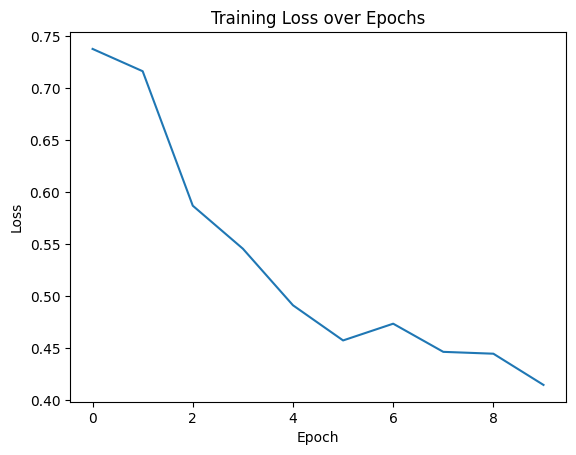

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▁▅▆▇█▇▇██
Train_loss,██▅▄▃▂▂▂▂▁
Val_accuracy,▁▂▅▆▇▇▇███
Val_loss,█▇▅▄▂▂▂▂▂▁
Epoch,9
Train_accuracy,84.25
Train_loss,0.41478
Val_accuracy,83.83333
Val_loss,0.43878


wandb: Agent Starting Run: 531ta1h1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7202, Train_Accuracy: 73.04%, Val_Loss: 0.7346, Val_Accuracy: 72.50%
Epoch 2, Train_Loss: 0.6188, Train_Accuracy: 78.84%, Val_Loss: 0.6298, Val_Accuracy: 78.13%
Epoch 3, Train_Loss: 0.5843, Train_Accuracy: 79.66%, Val_Loss: 0.5983, Val_Accuracy: 78.85%
Epoch 4, Train_Loss: 0.5472, Train_Accuracy: 80.66%, Val_Loss: 0.5589, Val_Accuracy: 80.60%
Epoch 5, Train_Loss: 0.5483, Train_Accuracy: 79.86%, Val_Loss: 0.5661, Val_Accuracy: 79.32%
Epoch 6, Train_Loss: 0.4308, Train_Accuracy: 84.67%, Val_Loss: 0.4524, Val_Accuracy: 84.10%
Epoch 7, Train_Loss: 0.4696, Train_Accuracy: 83.10%, Val_Loss: 0.5042, Val_Accuracy: 82.35%
Epoch 8, Train_Loss: 0.4674, Train_Accuracy: 82.57%, Val_Loss: 0.4843, Val_Accuracy: 82.22%
Epoch 9, Train_Loss: 0.4583, Train_Accuracy: 83.86%, Val_Loss: 0.4830, Val_Accuracy: 82.95%
Epoch 10, Train_Loss: 0.4411, Train_Accuracy: 83.95%, Val_Loss: 0.4709, Val_Accuracy: 83.27%


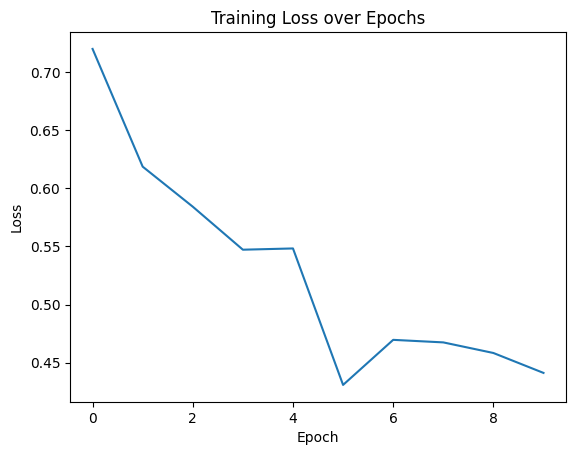

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▅█▇▇██
Train_loss,█▆▅▄▄▁▂▂▂▁
Val_accuracy,▁▄▅▆▅█▇▇▇▇
Val_loss,█▅▅▄▄▁▂▂▂▁
Epoch,9
Train_accuracy,83.95
Train_loss,0.44113
Val_accuracy,83.26667
Val_loss,0.47087


wandb: Agent Starting Run: bx710d3r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 2.0494, Train_Accuracy: 26.15%, Val_Loss: 2.0571, Val_Accuracy: 25.17%
Epoch 2, Train_Loss: 1.5350, Train_Accuracy: 47.58%, Val_Loss: 1.5425, Val_Accuracy: 46.85%
Epoch 3, Train_Loss: 1.1266, Train_Accuracy: 58.19%, Val_Loss: 1.1363, Val_Accuracy: 56.80%
Epoch 4, Train_Loss: 0.8752, Train_Accuracy: 66.16%, Val_Loss: 0.8898, Val_Accuracy: 64.25%
Epoch 5, Train_Loss: 0.7790, Train_Accuracy: 67.59%, Val_Loss: 0.8019, Val_Accuracy: 66.02%
Epoch 6, Train_Loss: 0.6561, Train_Accuracy: 74.59%, Val_Loss: 0.6758, Val_Accuracy: 73.37%
Epoch 7, Train_Loss: 0.5942, Train_Accuracy: 76.52%, Val_Loss: 0.6198, Val_Accuracy: 75.38%
Epoch 8, Train_Loss: 0.5755, Train_Accuracy: 76.35%, Val_Loss: 0.5906, Val_Accuracy: 76.10%
Epoch 9, Train_Loss: 0.6030, Train_Accuracy: 76.78%, Val_Loss: 0.6244, Val_Accuracy: 76.03%
Epoch 10, Train_Loss: 0.5581, Train_Accuracy: 80.31%, Val_Loss: 0.5781, Val_Accuracy: 79.22%


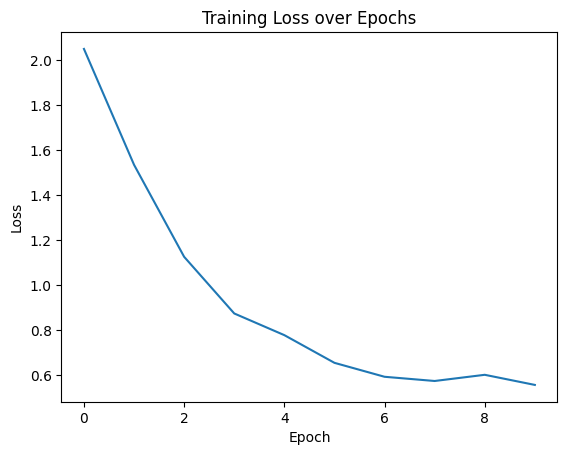

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▆▇█▇██
Train_loss,█▆▄▂▂▁▁▁▁▁
Val_accuracy,▁▄▅▆▆▇████
Val_loss,█▆▄▂▂▁▁▁▁▁
Epoch,9
Train_accuracy,80.30741
Train_loss,0.55805
Val_accuracy,79.21667
Val_loss,0.57806


wandb: Agent Starting Run: iw5v0drb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.6115, Train_Accuracy: 35.17%, Val_Loss: 1.6191, Val_Accuracy: 34.20%
Epoch 2, Train_Loss: 0.9615, Train_Accuracy: 62.54%, Val_Loss: 0.9738, Val_Accuracy: 62.50%
Epoch 3, Train_Loss: 0.6137, Train_Accuracy: 78.51%, Val_Loss: 0.6309, Val_Accuracy: 77.58%
Epoch 4, Train_Loss: 0.5479, Train_Accuracy: 80.55%, Val_Loss: 0.5709, Val_Accuracy: 80.00%
Epoch 5, Train_Loss: 0.4779, Train_Accuracy: 83.15%, Val_Loss: 0.4901, Val_Accuracy: 82.27%
Epoch 6, Train_Loss: 0.4687, Train_Accuracy: 83.55%, Val_Loss: 0.4803, Val_Accuracy: 82.78%
Epoch 7, Train_Loss: 0.4258, Train_Accuracy: 84.94%, Val_Loss: 0.4420, Val_Accuracy: 84.02%
Epoch 8, Train_Loss: 0.4269, Train_Accuracy: 84.51%, Val_Loss: 0.4482, Val_Accuracy: 83.42%
Epoch 9, Train_Loss: 0.3980, Train_Accuracy: 85.90%, Val_Loss: 0.4139, Val_Accuracy: 85.18%
Epoch 10, Train_Loss: 0.4017, Train_Accuracy: 85.67%, Val_Loss: 0.4298, Val_Accuracy: 84.70%


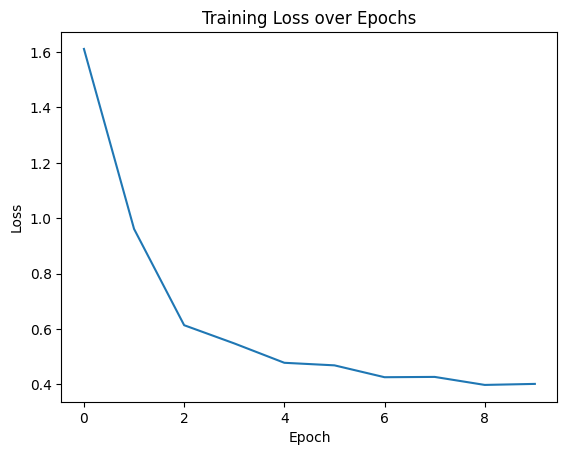

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▇▇██████
Train_loss,█▄▂▂▁▁▁▁▁▁
Val_accuracy,▁▅▇▇██████
Val_loss,█▄▂▂▁▁▁▁▁▁
Epoch,9
Train_accuracy,85.66852
Train_loss,0.40167
Val_accuracy,84.7
Val_loss,0.4298


wandb: Agent Starting Run: 7tu0cd8t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.6853, Train_Accuracy: 75.09%, Val_Loss: 0.7169, Val_Accuracy: 73.98%
Epoch 2, Train_Loss: 0.5991, Train_Accuracy: 79.52%, Val_Loss: 0.6178, Val_Accuracy: 79.20%
Epoch 3, Train_Loss: 0.5869, Train_Accuracy: 79.23%, Val_Loss: 0.6000, Val_Accuracy: 78.70%
Epoch 4, Train_Loss: 0.5598, Train_Accuracy: 80.59%, Val_Loss: 0.5607, Val_Accuracy: 80.85%
Epoch 5, Train_Loss: 0.4746, Train_Accuracy: 83.33%, Val_Loss: 0.4899, Val_Accuracy: 82.73%
Epoch 6, Train_Loss: 0.5149, Train_Accuracy: 80.45%, Val_Loss: 0.5345, Val_Accuracy: 79.98%
Epoch 7, Train_Loss: 0.4490, Train_Accuracy: 84.04%, Val_Loss: 0.4700, Val_Accuracy: 83.23%
Epoch 8, Train_Loss: 0.4277, Train_Accuracy: 84.53%, Val_Loss: 0.4432, Val_Accuracy: 84.10%
Epoch 9, Train_Loss: 0.4153, Train_Accuracy: 84.97%, Val_Loss: 0.4448, Val_Accuracy: 84.43%
Epoch 10, Train_Loss: 0.4008, Train_Accuracy: 85.33%, Val_Loss: 0.4308, Val_Accuracy: 84.75%


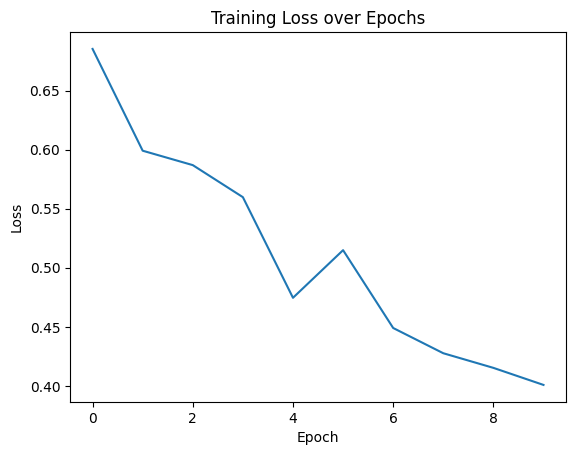

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▄▅▇▅▇▇██
Train_loss,█▆▆▅▃▄▂▂▁▁
Val_accuracy,▁▄▄▅▇▅▇███
Val_loss,█▆▅▄▂▄▂▁▁▁
Epoch,9
Train_accuracy,85.32593
Train_loss,0.40084
Val_accuracy,84.75
Val_loss,0.43078


wandb: Agent Starting Run: zssut92q with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7571, Train_Accuracy: 70.47%, Val_Loss: 0.7666, Val_Accuracy: 69.12%
Epoch 2, Train_Loss: 0.5917, Train_Accuracy: 78.37%, Val_Loss: 0.6078, Val_Accuracy: 77.45%
Epoch 3, Train_Loss: 0.6035, Train_Accuracy: 77.32%, Val_Loss: 0.6246, Val_Accuracy: 76.72%
Epoch 4, Train_Loss: 0.5312, Train_Accuracy: 80.99%, Val_Loss: 0.5500, Val_Accuracy: 80.48%
Epoch 5, Train_Loss: 0.5204, Train_Accuracy: 81.70%, Val_Loss: 0.5480, Val_Accuracy: 81.13%
Epoch 6, Train_Loss: 0.5201, Train_Accuracy: 81.70%, Val_Loss: 0.5327, Val_Accuracy: 80.98%
Epoch 7, Train_Loss: 0.4833, Train_Accuracy: 82.54%, Val_Loss: 0.4956, Val_Accuracy: 82.37%
Epoch 8, Train_Loss: 0.4546, Train_Accuracy: 83.47%, Val_Loss: 0.4747, Val_Accuracy: 82.87%
Epoch 9, Train_Loss: 0.4506, Train_Accuracy: 83.07%, Val_Loss: 0.4816, Val_Accuracy: 82.23%
Epoch 10, Train_Loss: 0.4551, Train_Accuracy: 83.32%, Val_Loss: 0.4901, Val_Accuracy: 82.42%


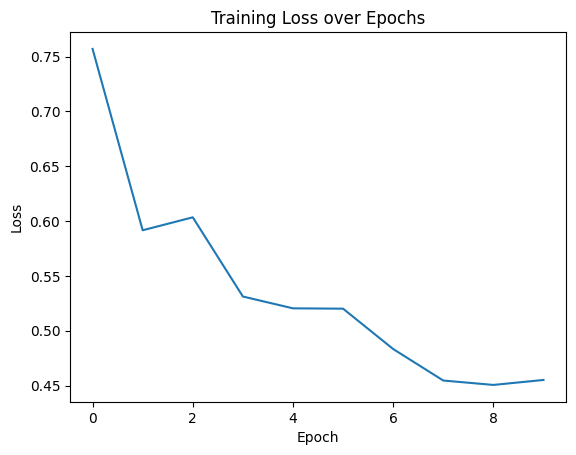

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▅▇▇▇▇███
Train_loss,█▄▄▃▃▃▂▁▁▁
Val_accuracy,▁▅▅▇▇▇████
Val_loss,█▄▅▃▃▂▁▁▁▁
Epoch,9
Train_accuracy,83.32407
Train_loss,0.4551
Val_accuracy,82.41667
Val_loss,0.49013


wandb: Agent Starting Run: pzqzwuuj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.5494, Train_Accuracy: 52.15%, Val_Loss: 1.5555, Val_Accuracy: 52.03%
Epoch 2, Train_Loss: 0.9870, Train_Accuracy: 62.24%, Val_Loss: 0.9990, Val_Accuracy: 61.17%
Epoch 3, Train_Loss: 0.8572, Train_Accuracy: 67.47%, Val_Loss: 0.8756, Val_Accuracy: 66.05%
Epoch 4, Train_Loss: 0.7539, Train_Accuracy: 68.84%, Val_Loss: 0.7762, Val_Accuracy: 67.78%
Epoch 5, Train_Loss: 0.6391, Train_Accuracy: 72.98%, Val_Loss: 0.6516, Val_Accuracy: 71.78%
Epoch 6, Train_Loss: 0.6801, Train_Accuracy: 69.77%, Val_Loss: 0.6962, Val_Accuracy: 69.00%
Epoch 7, Train_Loss: 0.6050, Train_Accuracy: 76.86%, Val_Loss: 0.6211, Val_Accuracy: 76.02%
Epoch 8, Train_Loss: 0.5307, Train_Accuracy: 80.95%, Val_Loss: 0.5470, Val_Accuracy: 80.20%
Epoch 9, Train_Loss: 0.5292, Train_Accuracy: 80.76%, Val_Loss: 0.5440, Val_Accuracy: 79.73%
Epoch 10, Train_Loss: 0.5227, Train_Accuracy: 81.07%, Val_Loss: 0.5383, Val_Accuracy: 80.90%


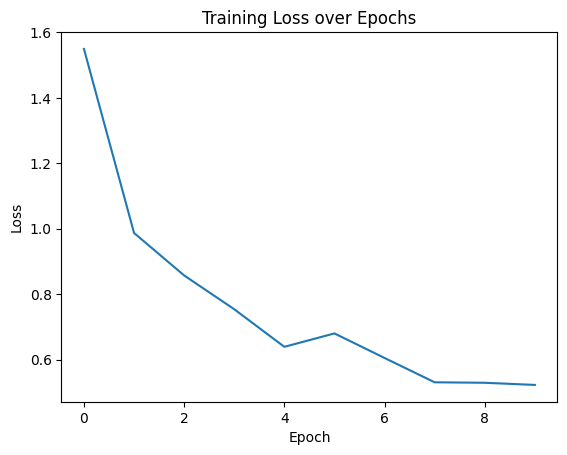

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▅▅▆▅▇███
Train_loss,█▄▃▃▂▂▂▁▁▁
Val_accuracy,▁▃▄▅▆▅▇███
Val_loss,█▄▃▃▂▂▂▁▁▁
Epoch,9
Train_accuracy,81.07222
Train_loss,0.52266
Val_accuracy,80.9
Val_loss,0.53832


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ocb6feoh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7839, Train_Accuracy: 68.86%, Val_Loss: 0.8090, Val_Accuracy: 68.05%
Epoch 2, Train_Loss: 0.6693, Train_Accuracy: 75.61%, Val_Loss: 0.6805, Val_Accuracy: 75.17%
Epoch 3, Train_Loss: 0.5917, Train_Accuracy: 78.12%, Val_Loss: 0.6035, Val_Accuracy: 78.03%
Epoch 4, Train_Loss: 0.5625, Train_Accuracy: 80.06%, Val_Loss: 0.5702, Val_Accuracy: 80.15%
Epoch 5, Train_Loss: 0.4722, Train_Accuracy: 83.13%, Val_Loss: 0.4825, Val_Accuracy: 82.73%
Epoch 6, Train_Loss: 0.5016, Train_Accuracy: 81.94%, Val_Loss: 0.5225, Val_Accuracy: 81.25%
Epoch 7, Train_Loss: 0.4598, Train_Accuracy: 83.46%, Val_Loss: 0.4760, Val_Accuracy: 82.30%
Epoch 8, Train_Loss: 0.4526, Train_Accuracy: 83.33%, Val_Loss: 0.4727, Val_Accuracy: 82.57%
Epoch 9, Train_Loss: 0.4646, Train_Accuracy: 84.12%, Val_Loss: 0.4864, Val_Accuracy: 83.42%
Epoch 10, Train_Loss: 0.4050, Train_Accuracy: 85.37%, Val_Loss: 0.4356, Val_Accuracy: 84.70%


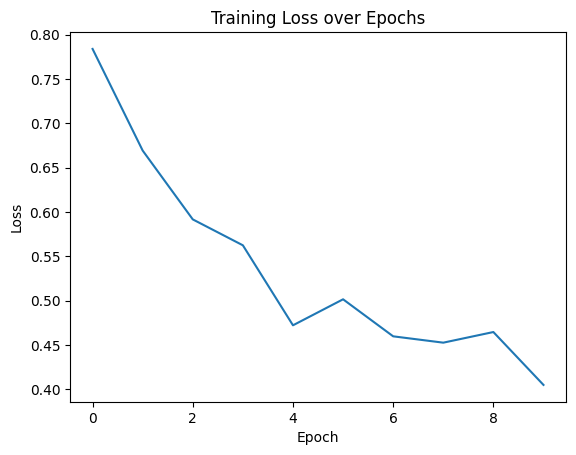

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▇▇▇▇▇█
Train_loss,█▆▄▄▂▃▂▂▂▁
Val_accuracy,▁▄▅▆▇▇▇▇▇█
Val_loss,█▆▄▄▂▃▂▂▂▁
Epoch,9
Train_accuracy,85.36667
Train_loss,0.40499
Val_accuracy,84.7
Val_loss,0.43563


wandb: Agent Starting Run: lffrwvao with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.8071, Train_Accuracy: 69.75%, Val_Loss: 0.8171, Val_Accuracy: 68.90%
Epoch 2, Train_Loss: 0.7948, Train_Accuracy: 67.79%, Val_Loss: 0.8062, Val_Accuracy: 67.47%
Epoch 3, Train_Loss: 0.5366, Train_Accuracy: 79.81%, Val_Loss: 0.5408, Val_Accuracy: 79.15%
Epoch 4, Train_Loss: 0.5795, Train_Accuracy: 77.84%, Val_Loss: 0.6033, Val_Accuracy: 77.13%
Epoch 5, Train_Loss: 0.5267, Train_Accuracy: 81.19%, Val_Loss: 0.5495, Val_Accuracy: 80.30%
Epoch 6, Train_Loss: 0.5189, Train_Accuracy: 82.36%, Val_Loss: 0.5403, Val_Accuracy: 81.72%
Epoch 7, Train_Loss: 0.4697, Train_Accuracy: 83.53%, Val_Loss: 0.4958, Val_Accuracy: 82.60%
Epoch 8, Train_Loss: 0.4343, Train_Accuracy: 84.41%, Val_Loss: 0.4630, Val_Accuracy: 83.80%
Epoch 9, Train_Loss: 0.4795, Train_Accuracy: 82.74%, Val_Loss: 0.5067, Val_Accuracy: 81.80%
Epoch 10, Train_Loss: 0.4365, Train_Accuracy: 84.64%, Val_Loss: 0.4578, Val_Accuracy: 83.97%


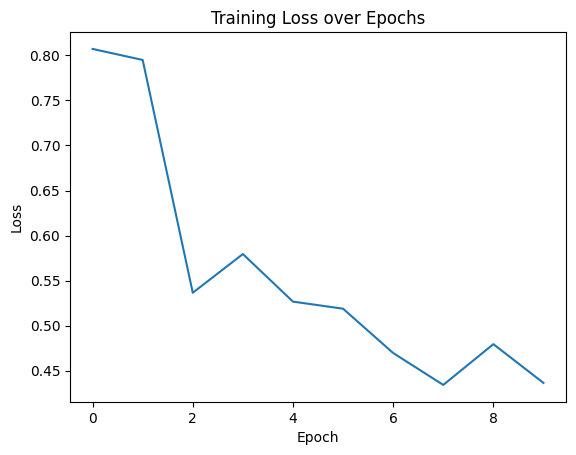

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▂▁▆▅▇▇██▇█
Train_loss,██▃▄▃▃▂▁▂▁
Val_accuracy,▂▁▆▅▆▇▇█▇█
Val_loss,██▃▄▃▃▂▁▂▁
Epoch,9
Train_accuracy,84.64444
Train_loss,0.43652
Val_accuracy,83.96667
Val_loss,0.45779


wandb: Agent Starting Run: otb3p3n9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.3820, Train_Accuracy: 46.99%, Val_Loss: 1.3908, Val_Accuracy: 45.92%
Epoch 2, Train_Loss: 0.9282, Train_Accuracy: 66.11%, Val_Loss: 0.9399, Val_Accuracy: 64.68%
Epoch 3, Train_Loss: 0.7724, Train_Accuracy: 69.81%, Val_Loss: 0.7921, Val_Accuracy: 68.75%
Epoch 4, Train_Loss: 0.6921, Train_Accuracy: 73.33%, Val_Loss: 0.7109, Val_Accuracy: 72.27%
Epoch 5, Train_Loss: 0.6332, Train_Accuracy: 75.72%, Val_Loss: 0.6568, Val_Accuracy: 74.57%
Epoch 6, Train_Loss: 0.5904, Train_Accuracy: 77.19%, Val_Loss: 0.6057, Val_Accuracy: 76.27%
Epoch 7, Train_Loss: 0.5870, Train_Accuracy: 77.77%, Val_Loss: 0.5959, Val_Accuracy: 77.38%
Epoch 8, Train_Loss: 0.5589, Train_Accuracy: 80.10%, Val_Loss: 0.5730, Val_Accuracy: 79.35%
Epoch 9, Train_Loss: 0.5532, Train_Accuracy: 79.77%, Val_Loss: 0.5734, Val_Accuracy: 78.88%
Epoch 10, Train_Loss: 0.5328, Train_Accuracy: 80.73%, Val_Loss: 0.5493, Val_Accuracy: 80.27%


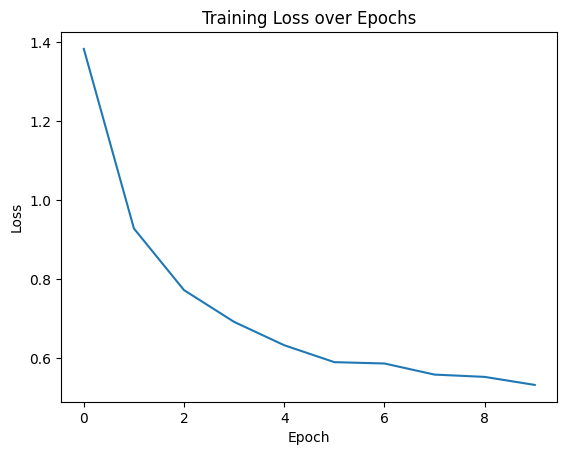

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▆▆▇▇▇███
Train_loss,█▄▃▂▂▁▁▁▁▁
Val_accuracy,▁▅▆▆▇▇▇███
Val_loss,█▄▃▂▂▁▁▁▁▁
Epoch,9
Train_accuracy,80.72778
Train_loss,0.53284
Val_accuracy,80.26667
Val_loss,0.54931


wandb: Agent Starting Run: 6qwzh0hf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.0946, Train_Accuracy: 58.79%, Val_Loss: 1.1088, Val_Accuracy: 57.63%
Epoch 2, Train_Loss: 0.6296, Train_Accuracy: 75.82%, Val_Loss: 0.6387, Val_Accuracy: 75.17%
Epoch 3, Train_Loss: 0.6138, Train_Accuracy: 77.48%, Val_Loss: 0.6281, Val_Accuracy: 76.25%
Epoch 4, Train_Loss: 0.4927, Train_Accuracy: 82.50%, Val_Loss: 0.5066, Val_Accuracy: 81.47%
Epoch 5, Train_Loss: 0.4618, Train_Accuracy: 83.76%, Val_Loss: 0.4714, Val_Accuracy: 83.35%
Epoch 6, Train_Loss: 0.4618, Train_Accuracy: 83.67%, Val_Loss: 0.4745, Val_Accuracy: 82.78%
Epoch 7, Train_Loss: 0.4272, Train_Accuracy: 84.99%, Val_Loss: 0.4440, Val_Accuracy: 84.08%
Epoch 8, Train_Loss: 0.4000, Train_Accuracy: 85.81%, Val_Loss: 0.4194, Val_Accuracy: 84.65%
Epoch 9, Train_Loss: 0.4026, Train_Accuracy: 85.75%, Val_Loss: 0.4276, Val_Accuracy: 84.17%
Epoch 10, Train_Loss: 0.3784, Train_Accuracy: 86.64%, Val_Loss: 0.4061, Val_Accuracy: 85.47%


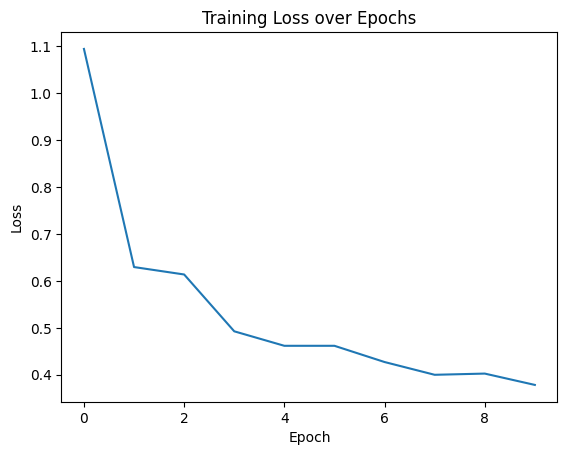

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▆▇▇▇████
Train_loss,█▃▃▂▂▂▁▁▁▁
Val_accuracy,▁▅▆▇▇▇████
Val_loss,█▃▃▂▂▂▁▁▁▁
Epoch,9
Train_accuracy,86.63889
Train_loss,0.37839
Val_accuracy,85.46667
Val_loss,0.40612


wandb: Agent Starting Run: m4ygfajh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7536, Train_Accuracy: 72.65%, Val_Loss: 0.7517, Val_Accuracy: 71.53%
Epoch 2, Train_Loss: 0.6358, Train_Accuracy: 77.02%, Val_Loss: 0.6460, Val_Accuracy: 76.42%
Epoch 3, Train_Loss: 0.5750, Train_Accuracy: 79.20%, Val_Loss: 0.5885, Val_Accuracy: 78.82%
Epoch 4, Train_Loss: 0.5348, Train_Accuracy: 80.74%, Val_Loss: 0.5545, Val_Accuracy: 80.10%
Epoch 5, Train_Loss: 0.5202, Train_Accuracy: 81.23%, Val_Loss: 0.5304, Val_Accuracy: 80.78%
Epoch 6, Train_Loss: 0.4533, Train_Accuracy: 83.51%, Val_Loss: 0.4685, Val_Accuracy: 82.95%
Epoch 7, Train_Loss: 0.4238, Train_Accuracy: 84.70%, Val_Loss: 0.4414, Val_Accuracy: 84.05%
Epoch 8, Train_Loss: 0.4516, Train_Accuracy: 83.58%, Val_Loss: 0.4833, Val_Accuracy: 83.10%
Epoch 9, Train_Loss: 0.4344, Train_Accuracy: 84.78%, Val_Loss: 0.4588, Val_Accuracy: 84.37%
Epoch 10, Train_Loss: 0.4254, Train_Accuracy: 84.75%, Val_Loss: 0.4592, Val_Accuracy: 83.93%


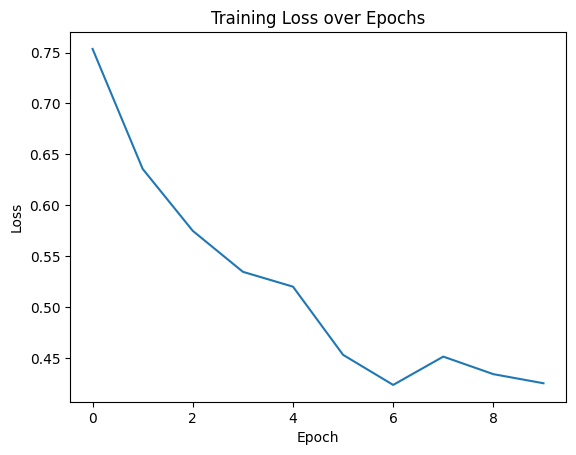

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▆▆▇█▇██
Train_loss,█▆▄▃▃▂▁▂▁▁
Val_accuracy,▁▄▅▆▆▇█▇██
Val_loss,█▆▄▄▃▂▁▂▁▁
Epoch,9
Train_accuracy,84.7463
Train_loss,0.42543
Val_accuracy,83.93333
Val_loss,0.4592


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w4ng619u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7547, Train_Accuracy: 73.60%, Val_Loss: 0.7717, Val_Accuracy: 72.60%
Epoch 2, Train_Loss: 0.6391, Train_Accuracy: 77.15%, Val_Loss: 0.6580, Val_Accuracy: 76.35%
Epoch 3, Train_Loss: 0.5601, Train_Accuracy: 79.24%, Val_Loss: 0.5763, Val_Accuracy: 78.88%
Epoch 4, Train_Loss: 0.6336, Train_Accuracy: 75.45%, Val_Loss: 0.6556, Val_Accuracy: 74.73%
Epoch 5, Train_Loss: 0.4961, Train_Accuracy: 81.79%, Val_Loss: 0.5199, Val_Accuracy: 81.28%
Epoch 6, Train_Loss: 0.4834, Train_Accuracy: 81.66%, Val_Loss: 0.4954, Val_Accuracy: 81.43%
Epoch 7, Train_Loss: 0.4401, Train_Accuracy: 84.31%, Val_Loss: 0.4722, Val_Accuracy: 83.38%
Epoch 8, Train_Loss: 0.4605, Train_Accuracy: 83.28%, Val_Loss: 0.4843, Val_Accuracy: 82.93%
Epoch 9, Train_Loss: 0.4384, Train_Accuracy: 83.93%, Val_Loss: 0.4629, Val_Accuracy: 83.23%
Epoch 10, Train_Loss: 0.4390, Train_Accuracy: 83.85%, Val_Loss: 0.4621, Val_Accuracy: 83.08%


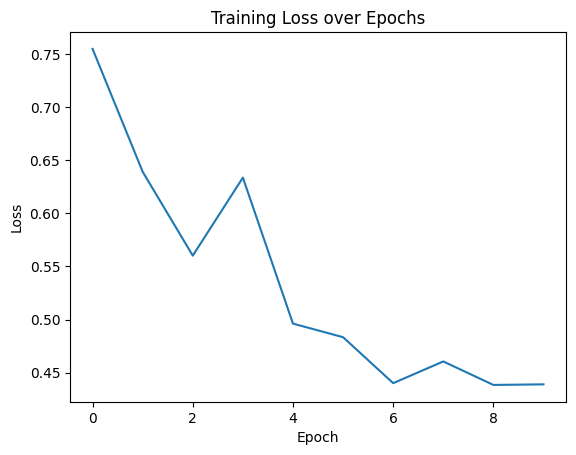

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▅▂▆▆█▇██
Train_loss,█▅▄▅▂▂▁▁▁▁
Val_accuracy,▁▃▅▂▇▇████
Val_loss,█▅▄▅▂▂▁▂▁▁
Epoch,9
Train_accuracy,83.8537
Train_loss,0.43897
Val_accuracy,83.08333
Val_loss,0.46214


wandb: Agent Starting Run: um4endxz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.5641, Train_Accuracy: 79.59%, Val_Loss: 0.5797, Val_Accuracy: 79.12%
Epoch 2, Train_Loss: 0.5271, Train_Accuracy: 80.96%, Val_Loss: 0.5417, Val_Accuracy: 80.35%
Epoch 3, Train_Loss: 0.4716, Train_Accuracy: 83.41%, Val_Loss: 0.4899, Val_Accuracy: 82.98%
Epoch 4, Train_Loss: 0.4339, Train_Accuracy: 83.99%, Val_Loss: 0.4558, Val_Accuracy: 83.15%
Epoch 5, Train_Loss: 0.3958, Train_Accuracy: 85.81%, Val_Loss: 0.4215, Val_Accuracy: 85.22%
Epoch 6, Train_Loss: 0.4114, Train_Accuracy: 85.65%, Val_Loss: 0.4453, Val_Accuracy: 85.08%
Epoch 7, Train_Loss: 0.4303, Train_Accuracy: 84.57%, Val_Loss: 0.4590, Val_Accuracy: 83.92%
Epoch 8, Train_Loss: 0.3946, Train_Accuracy: 85.46%, Val_Loss: 0.4309, Val_Accuracy: 84.32%
Epoch 9, Train_Loss: 0.3698, Train_Accuracy: 86.18%, Val_Loss: 0.4088, Val_Accuracy: 85.38%
Epoch 10, Train_Loss: 0.3747, Train_Accuracy: 86.24%, Val_Loss: 0.4131, Val_Accuracy: 85.28%


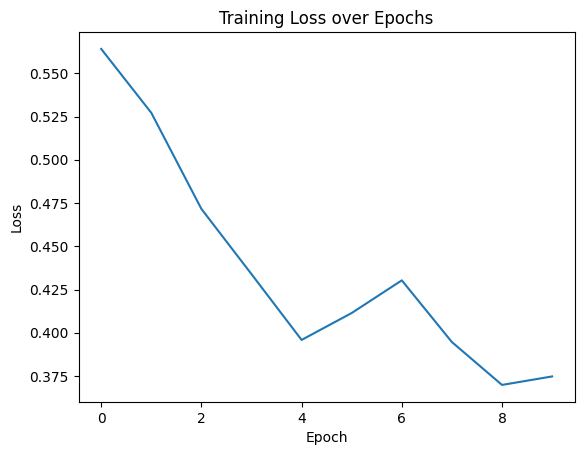

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▂▅▆█▇▆▇██
Train_loss,█▇▅▃▂▂▃▂▁▁
Val_accuracy,▁▂▅▆██▆▇██
Val_loss,█▆▄▃▂▂▃▂▁▁
Epoch,9
Train_accuracy,86.23889
Train_loss,0.37475
Val_accuracy,85.28333
Val_loss,0.41314


wandb: Agent Starting Run: ffiourlk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7381, Train_Accuracy: 72.92%, Val_Loss: 0.7532, Val_Accuracy: 71.97%
Epoch 2, Train_Loss: 0.6419, Train_Accuracy: 76.64%, Val_Loss: 0.6501, Val_Accuracy: 76.55%
Epoch 3, Train_Loss: 0.5840, Train_Accuracy: 79.92%, Val_Loss: 0.5940, Val_Accuracy: 79.62%
Epoch 4, Train_Loss: 0.5435, Train_Accuracy: 81.13%, Val_Loss: 0.5597, Val_Accuracy: 80.15%
Epoch 5, Train_Loss: 0.5522, Train_Accuracy: 81.95%, Val_Loss: 0.5662, Val_Accuracy: 81.70%
Epoch 6, Train_Loss: 0.4771, Train_Accuracy: 83.14%, Val_Loss: 0.4805, Val_Accuracy: 82.48%
Epoch 7, Train_Loss: 0.4688, Train_Accuracy: 83.37%, Val_Loss: 0.4900, Val_Accuracy: 82.62%
Epoch 8, Train_Loss: 0.4553, Train_Accuracy: 83.89%, Val_Loss: 0.4826, Val_Accuracy: 82.85%
Epoch 9, Train_Loss: 0.4446, Train_Accuracy: 83.26%, Val_Loss: 0.4756, Val_Accuracy: 82.62%
Epoch 10, Train_Loss: 0.4252, Train_Accuracy: 84.36%, Val_Loss: 0.4483, Val_Accuracy: 83.88%


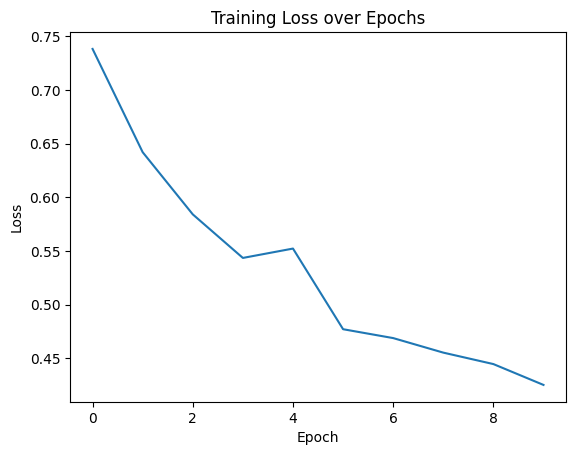

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▃▅▆▇▇▇█▇█
Train_loss,█▆▅▄▄▂▂▂▁▁
Val_accuracy,▁▄▅▆▇▇▇▇▇█
Val_loss,█▆▄▄▄▂▂▂▂▁
Epoch,9
Train_accuracy,84.35741
Train_loss,0.42521
Val_accuracy,83.88333
Val_loss,0.44827


wandb: Agent Starting Run: hdiqoz5j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7205, Train_Accuracy: 73.23%, Val_Loss: 0.7346, Val_Accuracy: 72.55%
Epoch 2, Train_Loss: 0.4872, Train_Accuracy: 81.93%, Val_Loss: 0.4974, Val_Accuracy: 81.73%
Epoch 3, Train_Loss: 0.4335, Train_Accuracy: 84.52%, Val_Loss: 0.4496, Val_Accuracy: 84.00%
Epoch 4, Train_Loss: 0.4593, Train_Accuracy: 83.23%, Val_Loss: 0.4950, Val_Accuracy: 82.78%
Epoch 5, Train_Loss: 0.4152, Train_Accuracy: 85.43%, Val_Loss: 0.4342, Val_Accuracy: 84.93%
Epoch 6, Train_Loss: 0.4065, Train_Accuracy: 85.54%, Val_Loss: 0.4370, Val_Accuracy: 84.47%
Epoch 7, Train_Loss: 0.4088, Train_Accuracy: 85.46%, Val_Loss: 0.4370, Val_Accuracy: 84.27%
Epoch 8, Train_Loss: 0.3744, Train_Accuracy: 86.38%, Val_Loss: 0.3944, Val_Accuracy: 85.83%
Epoch 9, Train_Loss: 0.3768, Train_Accuracy: 86.69%, Val_Loss: 0.4253, Val_Accuracy: 85.48%
Epoch 10, Train_Loss: 0.3656, Train_Accuracy: 86.75%, Val_Loss: 0.4097, Val_Accuracy: 85.82%


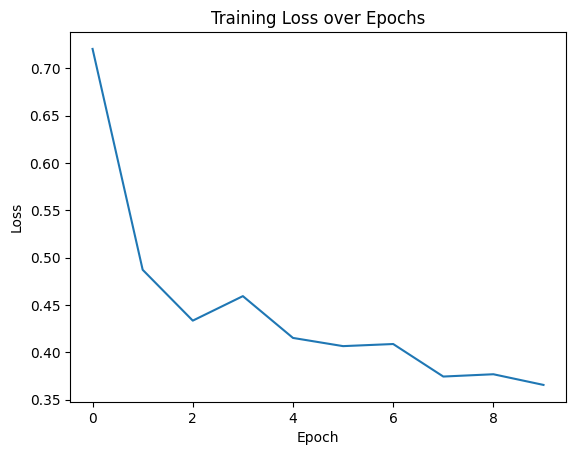

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▆▇▆▇▇▇███
Train_loss,█▃▂▃▂▂▂▁▁▁
Val_accuracy,▁▆▇▆█▇▇███
Val_loss,█▃▂▃▂▂▂▁▂▁
Epoch,9
Train_accuracy,86.75
Train_loss,0.36557
Val_accuracy,85.81667
Val_loss,0.40971


wandb: Agent Starting Run: kpore3fo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.5623, Train_Accuracy: 79.63%, Val_Loss: 0.5694, Val_Accuracy: 79.58%
Epoch 2, Train_Loss: 0.4920, Train_Accuracy: 82.56%, Val_Loss: 0.5097, Val_Accuracy: 82.03%
Epoch 3, Train_Loss: 0.4640, Train_Accuracy: 83.38%, Val_Loss: 0.4769, Val_Accuracy: 82.58%
Epoch 4, Train_Loss: 0.4739, Train_Accuracy: 83.02%, Val_Loss: 0.5045, Val_Accuracy: 82.35%
Epoch 5, Train_Loss: 0.4428, Train_Accuracy: 83.93%, Val_Loss: 0.4686, Val_Accuracy: 83.00%
Epoch 6, Train_Loss: 0.3963, Train_Accuracy: 85.60%, Val_Loss: 0.4334, Val_Accuracy: 84.68%
Epoch 7, Train_Loss: 0.4045, Train_Accuracy: 85.54%, Val_Loss: 0.4437, Val_Accuracy: 84.53%
Epoch 8, Train_Loss: 0.3957, Train_Accuracy: 85.66%, Val_Loss: 0.4271, Val_Accuracy: 84.78%
Epoch 9, Train_Loss: 0.3810, Train_Accuracy: 86.53%, Val_Loss: 0.4197, Val_Accuracy: 85.60%
Epoch 10, Train_Loss: 0.3641, Train_Accuracy: 87.37%, Val_Loss: 0.4113, Val_Accuracy: 86.37%


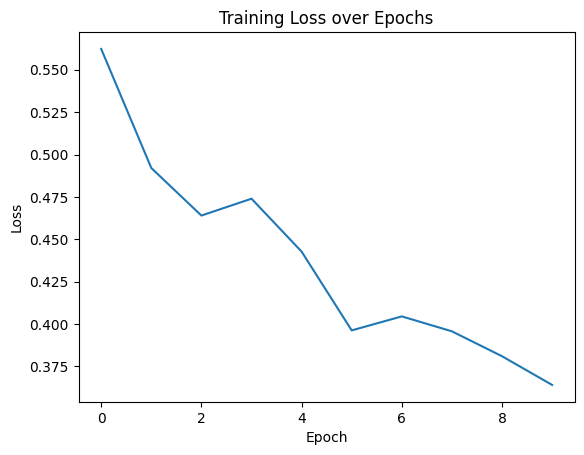

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▄▄▅▆▆▆▇█
Train_loss,█▆▅▅▄▂▂▂▂▁
Val_accuracy,▁▄▄▄▅▆▆▆▇█
Val_loss,█▅▄▅▄▂▂▂▁▁
Epoch,9
Train_accuracy,87.37222
Train_loss,0.36412
Val_accuracy,86.36667
Val_loss,0.41129


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h7tn06av with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.0881, Train_Accuracy: 56.36%, Val_Loss: 1.1058, Val_Accuracy: 55.30%
Epoch 2, Train_Loss: 0.7422, Train_Accuracy: 71.25%, Val_Loss: 0.7493, Val_Accuracy: 70.40%
Epoch 3, Train_Loss: 0.6445, Train_Accuracy: 77.42%, Val_Loss: 0.6621, Val_Accuracy: 76.30%
Epoch 4, Train_Loss: 0.5707, Train_Accuracy: 79.89%, Val_Loss: 0.5883, Val_Accuracy: 79.05%
Epoch 5, Train_Loss: 0.5408, Train_Accuracy: 80.57%, Val_Loss: 0.5571, Val_Accuracy: 79.65%
Epoch 6, Train_Loss: 0.4767, Train_Accuracy: 83.88%, Val_Loss: 0.4990, Val_Accuracy: 82.47%
Epoch 7, Train_Loss: 0.4613, Train_Accuracy: 83.66%, Val_Loss: 0.4768, Val_Accuracy: 83.23%
Epoch 8, Train_Loss: 0.4364, Train_Accuracy: 84.81%, Val_Loss: 0.4548, Val_Accuracy: 84.13%
Epoch 9, Train_Loss: 0.4534, Train_Accuracy: 83.97%, Val_Loss: 0.4748, Val_Accuracy: 82.83%
Epoch 10, Train_Loss: 0.4114, Train_Accuracy: 85.77%, Val_Loss: 0.4319, Val_Accuracy: 84.50%


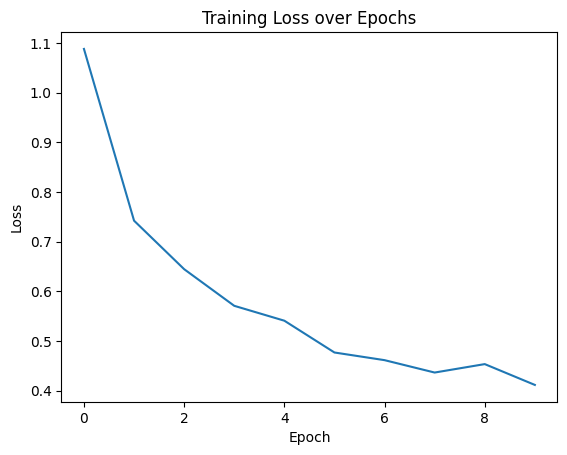

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▆▇▇█▇███
Train_loss,█▄▃▃▂▂▂▁▁▁
Val_accuracy,▁▅▆▇▇█████
Val_loss,█▄▃▃▂▂▁▁▁▁
Epoch,9
Train_accuracy,85.76852
Train_loss,0.41143
Val_accuracy,84.5
Val_loss,0.43186


wandb: Agent Starting Run: ilalgu99 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.6739, Train_Accuracy: 33.98%, Val_Loss: 1.6798, Val_Accuracy: 33.10%
Epoch 2, Train_Loss: 1.0674, Train_Accuracy: 62.79%, Val_Loss: 1.0753, Val_Accuracy: 61.42%
Epoch 3, Train_Loss: 0.8191, Train_Accuracy: 68.32%, Val_Loss: 0.8316, Val_Accuracy: 67.45%
Epoch 4, Train_Loss: 0.7179, Train_Accuracy: 74.48%, Val_Loss: 0.7261, Val_Accuracy: 74.02%
Epoch 5, Train_Loss: 0.6500, Train_Accuracy: 76.87%, Val_Loss: 0.6697, Val_Accuracy: 75.77%
Epoch 6, Train_Loss: 0.5870, Train_Accuracy: 79.06%, Val_Loss: 0.6051, Val_Accuracy: 78.48%
Epoch 7, Train_Loss: 0.6263, Train_Accuracy: 77.09%, Val_Loss: 0.6433, Val_Accuracy: 76.48%
Epoch 8, Train_Loss: 0.5709, Train_Accuracy: 80.47%, Val_Loss: 0.5948, Val_Accuracy: 79.18%
Epoch 9, Train_Loss: 0.5184, Train_Accuracy: 81.52%, Val_Loss: 0.5354, Val_Accuracy: 81.12%
Epoch 10, Train_Loss: 0.4948, Train_Accuracy: 82.32%, Val_Loss: 0.5053, Val_Accuracy: 81.75%


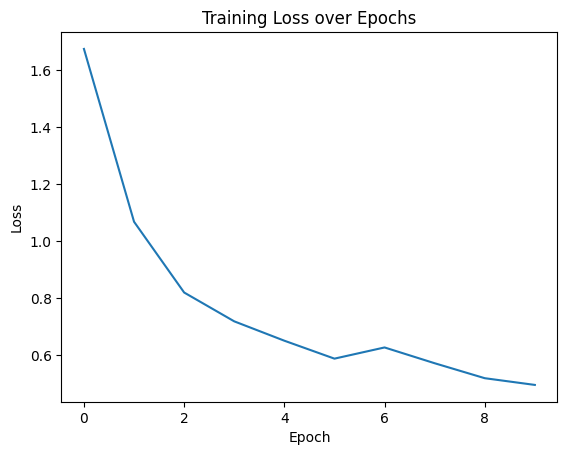

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▆▇▇█▇███
Train_loss,█▄▃▂▂▂▂▁▁▁
Val_accuracy,▁▅▆▇▇█▇███
Val_loss,█▄▃▂▂▂▂▂▁▁
Epoch,9
Train_accuracy,82.32222
Train_loss,0.49482
Val_accuracy,81.75
Val_loss,0.50531


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8w9e4qke with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.6028, Train_Accuracy: 77.66%, Val_Loss: 0.6165, Val_Accuracy: 77.53%
Epoch 2, Train_Loss: 0.4809, Train_Accuracy: 83.29%, Val_Loss: 0.5062, Val_Accuracy: 82.27%
Epoch 3, Train_Loss: 0.4662, Train_Accuracy: 83.24%, Val_Loss: 0.4932, Val_Accuracy: 82.62%
Epoch 4, Train_Loss: 0.4356, Train_Accuracy: 84.82%, Val_Loss: 0.4683, Val_Accuracy: 84.08%
Epoch 5, Train_Loss: 0.4182, Train_Accuracy: 85.01%, Val_Loss: 0.4522, Val_Accuracy: 84.28%
Epoch 6, Train_Loss: 0.4073, Train_Accuracy: 85.61%, Val_Loss: 0.4359, Val_Accuracy: 84.55%
Epoch 7, Train_Loss: 0.4077, Train_Accuracy: 85.42%, Val_Loss: 0.4513, Val_Accuracy: 84.33%
Epoch 8, Train_Loss: 0.3753, Train_Accuracy: 86.27%, Val_Loss: 0.4200, Val_Accuracy: 85.25%
Epoch 9, Train_Loss: 0.3864, Train_Accuracy: 85.87%, Val_Loss: 0.4317, Val_Accuracy: 84.83%
Epoch 10, Train_Loss: 0.3754, Train_Accuracy: 86.42%, Val_Loss: 0.4151, Val_Accuracy: 85.47%


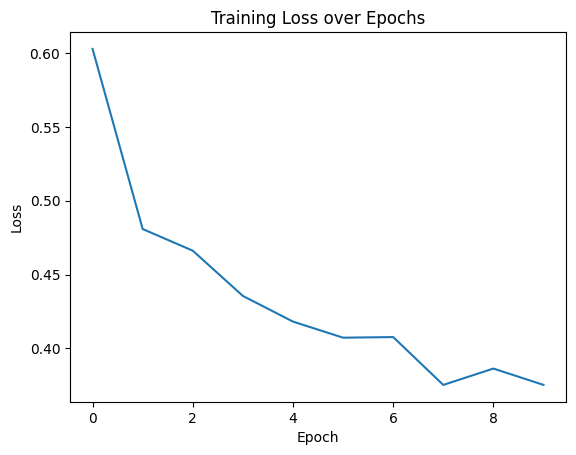

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▅▅▇▇▇▇███
Train_loss,█▄▄▃▂▂▂▁▁▁
Val_accuracy,▁▅▅▇▇▇▇█▇█
Val_loss,█▄▄▃▂▂▂▁▂▁
Epoch,9
Train_accuracy,86.42407
Train_loss,0.37537
Val_accuracy,85.46667
Val_loss,0.41505


wandb: Agent Starting Run: md9xsenh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.5989, Train_Accuracy: 77.84%, Val_Loss: 0.6145, Val_Accuracy: 77.02%
Epoch 2, Train_Loss: 0.5228, Train_Accuracy: 80.74%, Val_Loss: 0.5327, Val_Accuracy: 80.10%
Epoch 3, Train_Loss: 0.4894, Train_Accuracy: 82.19%, Val_Loss: 0.5088, Val_Accuracy: 82.20%
Epoch 4, Train_Loss: 0.4565, Train_Accuracy: 83.97%, Val_Loss: 0.4842, Val_Accuracy: 83.43%
Epoch 5, Train_Loss: 0.4099, Train_Accuracy: 85.18%, Val_Loss: 0.4346, Val_Accuracy: 84.45%
Epoch 6, Train_Loss: 0.4350, Train_Accuracy: 84.76%, Val_Loss: 0.4741, Val_Accuracy: 83.58%
Epoch 7, Train_Loss: 0.4001, Train_Accuracy: 85.37%, Val_Loss: 0.4342, Val_Accuracy: 84.63%
Epoch 8, Train_Loss: 0.4155, Train_Accuracy: 84.41%, Val_Loss: 0.4529, Val_Accuracy: 83.37%
Epoch 9, Train_Loss: 0.4179, Train_Accuracy: 84.69%, Val_Loss: 0.4488, Val_Accuracy: 83.63%
Epoch 10, Train_Loss: 0.3981, Train_Accuracy: 85.50%, Val_Loss: 0.4453, Val_Accuracy: 84.33%


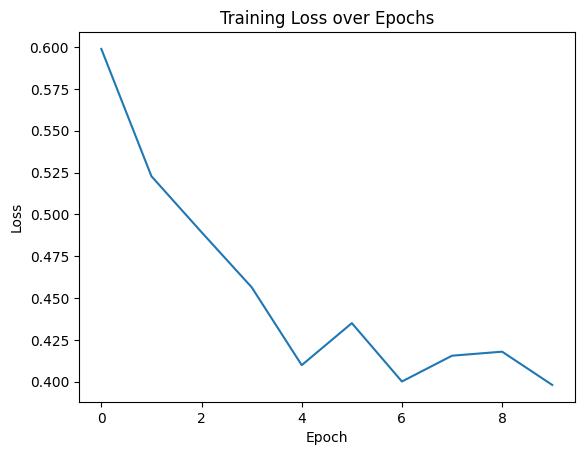

Epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,▁▄▅▇█▇█▇▇█
Train_loss,█▅▄▃▁▂▁▂▂▁
Val_accuracy,▁▄▆▇█▇█▇▇█
Val_loss,█▅▄▃▁▃▁▂▂▁
Epoch,9
Train_accuracy,85.49815
Train_loss,0.39807
Val_accuracy,84.33333
Val_loss,0.44531


In [ ]:
def main():
    '''
    WandB calls the main function each time with a different combination of hyperparameters.

    We retrieve these values using `wandb.config` and use them to train the model.
    '''

    with wandb.init() as run:
        # Generate a unique run name based on the hyperparameter values
        run_name = "ac-" + (wandb.config.activation) + \
                   "_nn-" + str(wandb.config.num_neurons) + \
                   "_epc-" + str(wandb.config.epochs) + \
                   "_nl-" + str(wandb.config.num_layers) + \
                   "_wd-" + str(wandb.config.regularization) + \
                   "_lr-" + str(wandb.config.learning_rate) + \
                   "_opt-" + str(wandb.config.optimizer) + \
                   "_bs-" + str(wandb.config.batch_size) + \
                   "_wi-" + str(wandb.config.weight_init)

        # Assign the generated name to the WandB run
        wandb.run.name = run_name

        # Train the model with the current hyperparameter configuration
        train_model(
            X_train, Y_train,            # Training data
            X_valid, Y_valid,            # Validation data
            784, 10,                     # Input and output dimensions (Fashion MNIST: 784 input features, 10 classes)
            wandb.config.learning_rate,  # Learning rate
            wandb.config.optimizer,      # Optimizer
            wandb.config.regularization,   # Regularization term
            wandb.config.epochs,         # Number of epochs
            wandb.config.activation,     # Activation function
            wandb.config.num_layers,     # Number of hidden layers
            wandb.config.num_neurons,    # Neurons per layer
            wandb.config.weight_init,    # Weight initialization method
            wandb.config.batch_size,     # Batch size
            epsilon=0.0001,                # Small constant for numerical stability
            beta=0.9, beta1=0.9, beta2=0.99  # Hyperparameters for momentum-based optimizers
        )

# Run the sweep agent to execute `main` function multiple times
wandb.agent(sweep_id, function=main, count=50)  # Calls `main` function 50 times with different hyperparameter sets

# Mark the end of the WandB run
wandb.finish()


## Question-7 : Test Accuracy and Confusion Matrix

I am getting higher accuracy with RMSPROP, ADAM and NADAM. So I am using these optimizers to find test accuracy.


In [31]:
def nadam_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay):
    """
    Implements the Nadam (Nesterov-accelerated Adaptive Moment Estimation) optimization algorithm.

    Args:
        learning_rate: The step size for parameter updates.
        params: Dictionary containing the neural network parameters.
        X_train, Y_train: Training data and corresponding labels.
        X_test, Y_test: Testing data and corresponding labels.
        activation: Activation function used in the network.
        epochs: Number of training iterations.
        num_layers: Number of hidden layers.
        input_dim: Input dimension of the data.
        batch_size: Number of samples per batch update.
        epsilon: Small value to avoid division by zero.
        beta1: Decay rate for the first moment estimate (momentum term).
        beta2: Decay rate for the second moment estimate (velocity term).
        weight_decay (float): L2 regularization strength.

    Returns:
        Updated parameters after training.
    """
    train_losses = []
    test_losses = []
    num_samples = X_train.shape[0]

    # Initialize velocity and momentum terms for all parameters
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}
    v_hat = {key: np.zeros_like(value) for key, value in params.items()}

    momentum = {key: np.zeros_like(value) for key, value in params.items()}
    prev_m = {key: np.zeros_like(value) for key, value in params.items()}
    m_hat = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):
        time_step = 0
        num_processed = 0
        num_batches = 0
        epoch_loss = 0
        grad_accu = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):
            # Forward pass for a single training sample
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients over the batch
            for layer in range(num_layers + 1, 0, -1):
                grad_accu[f'W{layer}'] += gradients[f'W{layer}']
                grad_accu[f'b{layer}'] += gradients[f'b{layer}']

            num_processed += 1
            if num_processed % batch_size == 0:
                time_step += 1
                num_batches += 1

                # Compute momentum estimates
                for layer in range(1, num_layers + 2):
                    momentum[f'W{layer}'] = beta1 *prev_m[f'W{layer}'] + (1-beta1)*grad_accu[f'W{layer}']
                    momentum[f'b{layer}'] = beta1 *prev_m[f'b{layer}'] + (1-beta1)*grad_accu[f'b{layer}']

                # Bias-corrected momentum
                    m_hat[f'W{layer}'] = momentum[f'W{layer}'] / (1-np.power(beta1, time_step))
                    m_hat[f'b{layer}'] = momentum[f'b{layer}'] / (1-np.power(beta1, time_step))
                    prev_m[f'W{layer}'] = momentum[f'W{layer}']
                    prev_m[f'b{layer}'] = momentum[f'b{layer}']

                # Compute velocity estimates
                    velocity[f'W{layer}'] = beta2 * prev_v[f'W{layer}'] + (1-beta2) * (grad_accu[f'W{layer}']**2)
                    velocity[f'b{layer}'] = beta2 * prev_v[f'b{layer}'] + (1-beta2) * (grad_accu[f'b{layer}']**2)

                # Bias-corrected velocity
                    v_hat[f'W{layer}'] = velocity[f'W{layer}'] / (1-np.power(beta2, time_step))
                    v_hat[f'b{layer}'] = velocity[f'b{layer}'] / (1-np.power(beta2, time_step))
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

                # Update parameters using Nadam update rule
                    params[f'W{layer}'] -= (learning_rate/(np.sqrt(v_hat[f'W{layer}'])+epsilon)) * (beta1*m_hat[f'W{layer}'] + (1-beta1)*grad_accu[f'W{layer}']/(1-np.power(beta1, time_step)))
                    params[f'b{layer}'] -= (learning_rate/(np.sqrt(v_hat[f'b{layer}'])+epsilon)) * (beta1*m_hat[f'b{layer}'] + (1-beta1)*grad_accu[f'b{layer}']/(1-np.power(beta1, time_step)))

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        train_losses.append(train_loss)  # Store loss for visualization

        # Compute test accuracy
        test_acc = compute_accuracy(X_test, Y_test, params, activation, num_layers, input_dim)

        # Compute test loss using cross-entropy
        act, out, test_preds = forward_propagation(X_test.T, params, activation, num_layers, input_dim)
        test_loss = cross_entropy_loss(Y_test.T, test_preds, params, weight_decay, num_layers)
        test_losses.append(test_loss)  # Store loss for visualization


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_loss: {train_loss:.4f}, Train_accuracy: {train_acc * 100:.2f}%, Test_loss: {test_loss:.4f}, Test_accuracy: {test_acc * 100:.2f}%")


    # Plot the loss function over epochs
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs')
    plt.show()

    return params


In [32]:
def adam_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay):
    """
    Implements the Adam (Adaptive Moment Estimation) optimizer for training a neural network.
        m_t = β1*m_(t-1) + (1-β1)*∇w_t
        hat{m_t} = m_t / (1-β1^t)
        v_t = β2*v_(t-1) + (1-β2)*(∇w_t)^2
        hat{v_t} = v_t / (1-β2^t)
        w_(t+1) = w_t - η*(hat{m_t} / (√(hat{v_t}) +ε) )

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_test (numpy array): Test input data.
        Y_test (numpy array): One-hot encoded test labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        epsilon (float): Small constant to avoid division by zero.
        beta1 (float): Exponential decay rate for first moment estimates.
        beta2 (float): Exponential decay rate for second moment estimates.
        weight_decay (float): L2 regularization strength.

    Returns:
        dict: Updated network parameters after training.
    """

    train_losses = []  # List to store loss values for each epoch
    test_losses = []
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize first moment vector (momentum)
    momentum = {key: np.zeros_like(value) for key, value in params.items()}
    prev_m = {key: np.zeros_like(value) for key, value in params.items()}
    m_hat = {key: np.zeros_like(value) for key, value in params.items()}

    # Initialize second moment vector (velocity - moving average of squared gradients)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}
    v_hat = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate over epochs
        time_step = 0  # Time step counter for bias correction
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize epoch loss

        # Initialize gradient accumulator for batch updates
        gradient_accumulator = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):  # Iterate through all training samples
            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                gradient_accumulator[f'W{layer}'] += gradients[f'W{layer}']
                gradient_accumulator[f'b{layer}'] += gradients[f'b{layer}']

            num_processed += 1  # Increment processed sample counter

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                time_step += 1  # Increment time step for bias correction
                num_batches += 1  # Increment batch count

                # Compute biased first moment estimate (momentum)
                for layer in range(1, num_layers + 2):
                    momentum[f'W{layer}'] = beta1*prev_m[f'W{layer}'] + (1-beta1)*gradient_accumulator[f'W{layer}']
                    momentum[f'b{layer}'] = beta1*prev_m[f'b{layer}'] + (1-beta1)*gradient_accumulator[f'b{layer}']

                # Compute bias-corrected first moment estimate
                    m_hat[f'W{layer}'] = momentum[f'W{layer}'] / (1 - np.power(beta1, time_step))
                    m_hat[f'b{layer}'] = momentum[f'b{layer}'] / (1 - np.power(beta1, time_step))

                    # Update previous momentum values
                    prev_m[f'W{layer}'] = momentum[f'W{layer}']
                    prev_m[f'b{layer}'] = momentum[f'b{layer}']

                # Compute biased second moment estimate (velocity)
                    velocity[f'W{layer}'] = beta2*prev_v[f'W{layer}'] + (1-beta2)*(gradient_accumulator[f'W{layer}']**2)
                    velocity[f'b{layer}'] = beta2*prev_v[f'b{layer}'] + (1-beta2)*(gradient_accumulator[f'b{layer}']**2)

                # Compute bias-corrected second moment estimate
                    v_hat[f'W{layer}'] = velocity[f'W{layer}'] / (1 - np.power(beta2, time_step))
                    v_hat[f'b{layer}'] = velocity[f'b{layer}'] / (1 - np.power(beta2, time_step))

                    # Update previous velocity values
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

                # Apply Adam update rule to parameters
                    params[f'W{layer}'] -= (learning_rate / (np.sqrt(v_hat[f'W{layer}']) + epsilon)) *m_hat[f'W{layer}']
                    params[f'b{layer}'] -= (learning_rate / (np.sqrt(v_hat[f'b{layer}']) + epsilon)) *m_hat[f'b{layer}']

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        train_losses.append(train_loss)  # Store loss for visualization

        # Compute test accuracy
        test_acc = compute_accuracy(X_test, Y_test, params, activation, num_layers, input_dim)

        # Compute test loss using cross-entropy
        act, out, test_preds = forward_propagation(X_test.T, params, activation, num_layers, input_dim)
        test_loss = cross_entropy_loss(Y_test.T, test_preds, params, weight_decay, num_layers)
        test_losses.append(test_loss)  # Store loss for visualization


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_loss: {train_loss:.4f}, Train_accuracy: {train_acc * 100:.2f}%, Test_loss: {test_loss:.4f}, Test_accuracy: {test_acc * 100:.2f}%")

    # Plot the loss function over epochs
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs')
    plt.show()

    return params


In [33]:
def rmsprop_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta,weight_decay):
    """
    Implements the RMSprop (Root Mean Square Propagation) optimizer for training a neural network.
        v_t = β * v_(t-1) + (1-β) * (∇w_t)^2
        w_(t+1) = w_t - η*(∇w_t / (√v_t + ε))

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_test (numpy array): Test input data.
        Y_test (numpy array): One-hot encoded test labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        epsilon (float): Small constant to avoid division by zero.
        beta (float): Decay rate for the moving average of squared gradients.
        weight_decay (float): L2 regularization strength.

    Returns:
        dict: Updated network parameters after training.
    """

    train_losses = []  # List to store training loss for each epoch
    test_losses = []
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize velocity (moving average of squared gradients) for each parameter
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate through epochs
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize loss for the current epoch

        # Initialize gradient accumulator for batch updates
        grad_accu = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):  # Iterate through all training samples
            num_processed += 1  # Increment processed sample counter

            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                grad_accu[f'W{layer}'] += gradients[f'W{layer}']
                grad_accu[f'b{layer}'] += gradients[f'b{layer}']

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                num_batches += 1  # Increment batch count

                for layer in range(1, num_layers + 2):
                    # Compute moving average of squared gradients (RMSprop update)
                    velocity[f'W{layer}'] = beta*prev_v[f'W{layer}'] + (1-beta)*(grad_accu[f'W{layer}']**2)
                    velocity[f'b{layer}'] = beta*prev_v[f'b{layer}'] + (1-beta)*(grad_accu[f'b{layer}']**2)


                    # Apply RMSprop update rule to parameters
                    params[f'W{layer}'] -= (learning_rate / (np.sqrt(velocity[f'W{layer}'] + epsilon))) * grad_accu[f'W{layer}']
                    params[f'b{layer}'] -= (learning_rate / (np.sqrt(velocity[f'b{layer}'] + epsilon))) * grad_accu[f'b{layer}']

                # Store previous velocity values for the next batch update
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        train_losses.append(train_loss)  # Store loss for visualization

        # Compute test accuracy
        test_acc = compute_accuracy(X_test, Y_test, params, activation, num_layers, input_dim)

        # Compute test loss using cross-entropy
        act, out, test_preds = forward_propagation(X_test.T, params, activation, num_layers, input_dim)
        test_loss = cross_entropy_loss(Y_test.T, test_preds, params, weight_decay, num_layers)
        test_losses.append(test_loss)  # Store loss for visualization


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_loss: {train_loss:.4f}, Train_accuracy: {train_acc * 100:.2f}%, Test_loss: {test_loss:.4f}, Test_accuracy: {test_acc * 100:.2f}%")


    # Plot the loss function over epochs
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs')
    plt.show()

    return params


Epoch 1, Train_loss: 0.8008, Train_accuracy: 72.88%, Test_loss: 0.8166, Test_accuracy: 72.06%
Epoch 2, Train_loss: 0.6883, Train_accuracy: 75.11%, Test_loss: 0.7093, Test_accuracy: 74.11%
Epoch 3, Train_loss: 0.5562, Train_accuracy: 79.62%, Test_loss: 0.5923, Test_accuracy: 78.69%
Epoch 4, Train_loss: 0.5221, Train_accuracy: 81.19%, Test_loss: 0.5613, Test_accuracy: 79.34%
Epoch 5, Train_loss: 0.4613, Train_accuracy: 83.72%, Test_loss: 0.4985, Test_accuracy: 82.83%
Epoch 6, Train_loss: 0.4508, Train_accuracy: 83.38%, Test_loss: 0.4964, Test_accuracy: 81.68%
Epoch 7, Train_loss: 0.4365, Train_accuracy: 84.49%, Test_loss: 0.4843, Test_accuracy: 83.30%
Epoch 8, Train_loss: 0.3886, Train_accuracy: 85.86%, Test_loss: 0.4414, Test_accuracy: 84.49%
Epoch 9, Train_loss: 0.4082, Train_accuracy: 85.14%, Test_loss: 0.4622, Test_accuracy: 83.85%
Epoch 10, Train_loss: 0.4196, Train_accuracy: 85.00%, Test_loss: 0.4722, Test_accuracy: 83.35%


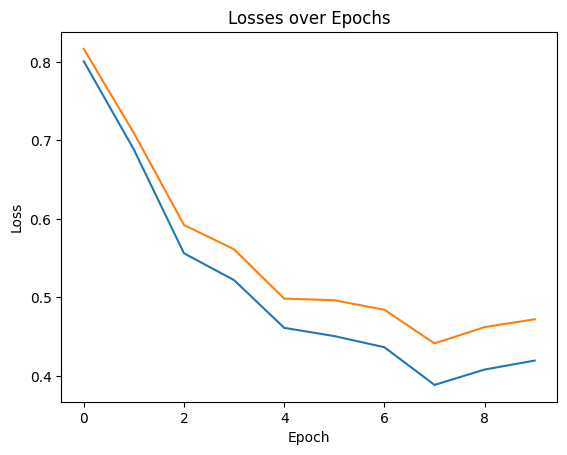

In [34]:
# Best hyperparameters after tuning with wandb
epochs=10
batch_size=64
learning_rate=0.0001
beta=0.9
beta1=0.9
beta2=0.99
epsilon=0.000001
num_layers=5
num_neurons=128
input_dim=784
output_dim=10
weight_decay=0.0
weight_init='xavier'
activation='relu'

# Initialize the network with random weights based on the chosen weight initialization method
params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)

# Nadam optimizer (Adam with Nesterov momentum)
parameters = nadam_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay)

Epoch 1, Train_loss: 0.3909, Train_accuracy: 85.68%, Test_loss: 0.4482, Test_accuracy: 83.65%
Epoch 2, Train_loss: 0.4009, Train_accuracy: 85.86%, Test_loss: 0.4652, Test_accuracy: 84.19%
Epoch 3, Train_loss: 0.3775, Train_accuracy: 85.80%, Test_loss: 0.4472, Test_accuracy: 83.81%
Epoch 4, Train_loss: 0.3564, Train_accuracy: 86.57%, Test_loss: 0.4130, Test_accuracy: 84.75%
Epoch 5, Train_loss: 0.3888, Train_accuracy: 86.50%, Test_loss: 0.4581, Test_accuracy: 84.54%
Epoch 6, Train_loss: 0.3614, Train_accuracy: 86.48%, Test_loss: 0.4243, Test_accuracy: 84.78%
Epoch 7, Train_loss: 0.3508, Train_accuracy: 87.61%, Test_loss: 0.4242, Test_accuracy: 86.06%
Epoch 8, Train_loss: 0.3504, Train_accuracy: 87.22%, Test_loss: 0.4121, Test_accuracy: 85.44%
Epoch 9, Train_loss: 0.3599, Train_accuracy: 87.28%, Test_loss: 0.4237, Test_accuracy: 85.13%
Epoch 10, Train_loss: 0.3536, Train_accuracy: 86.60%, Test_loss: 0.4240, Test_accuracy: 84.46%


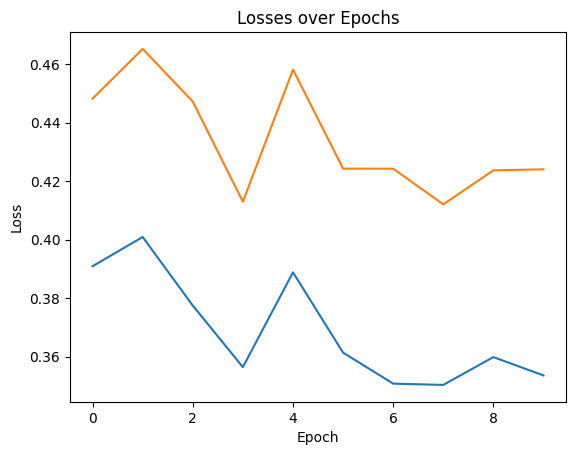

In [35]:
parameters = adam_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay)

Epoch 1, Train_loss: 0.3021, Train_accuracy: 89.16%, Test_loss: 0.3800, Test_accuracy: 86.72%
Epoch 2, Train_loss: 0.2973, Train_accuracy: 89.10%, Test_loss: 0.3791, Test_accuracy: 86.82%
Epoch 3, Train_loss: 0.2995, Train_accuracy: 89.21%, Test_loss: 0.3879, Test_accuracy: 86.81%
Epoch 4, Train_loss: 0.2861, Train_accuracy: 89.48%, Test_loss: 0.3797, Test_accuracy: 87.15%
Epoch 5, Train_loss: 0.2897, Train_accuracy: 89.34%, Test_loss: 0.3790, Test_accuracy: 86.91%
Epoch 6, Train_loss: 0.2888, Train_accuracy: 89.36%, Test_loss: 0.3970, Test_accuracy: 86.58%


<ipython-input-3-130d7ef32ec9>:25: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x), axis=0)


Epoch 7, Train_loss: nan, Train_accuracy: 89.57%, Test_loss: nan, Test_accuracy: 86.94%
Epoch 8, Train_loss: nan, Train_accuracy: 89.71%, Test_loss: nan, Test_accuracy: 86.88%
Epoch 9, Train_loss: nan, Train_accuracy: 90.06%, Test_loss: nan, Test_accuracy: 87.46%
Epoch 10, Train_loss: 0.2858, Train_accuracy: 89.57%, Test_loss: 0.3870, Test_accuracy: 86.51%


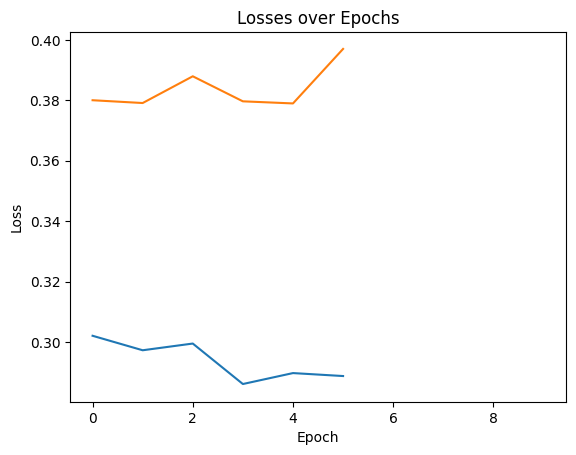

In [36]:
parameters = rmsprop_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta,weight_decay)

I found highest test accuracy with RMSprop, So I am using RMSprop optimizer for creating confusion matrix.

In [5]:
# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Split the training data into training and validation sets (90% train, 10% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Flatten the images (convert 28x28 matrices into 1D arrays of size 784)
# Normalize pixel values to the range [0,1] by dividing by 255
X_train = X_train.reshape(X_train.shape[0], -1) / 255
X_valid = X_valid.reshape(X_valid.shape[0], -1) / 255
X_test = X_test.reshape(X_test.shape[0], -1) / 255

def one_hot_encod(arr):
    """ Convert class labels to one-hot encoded vectors.
    Args: arr (numpy array): Array of class labels (e.g., [0, 1, 2, ..., 9])

    Returns: numpy array: One-hot encoded matrix of shape (len(arr), 10)
    """
    mat = np.zeros((len(arr), 10))  # Create a matrix of zeros with shape (num_samples, num_classes)
    for i in range(len(arr)):
        mat[i, arr[i]] = 1  # Set the corresponding class index to 1
    return mat

# Convert labels to one-hot encoding for training, validation, and test sets
Y_train = one_hot_encod(y_train)
Y_valid = one_hot_encod(y_valid)
Y_test = one_hot_encod(y_test)


Epoch 1, Train_loss: 0.4321, Train_accuracy: 84.27%, Test_loss: 0.4740, Test_accuracy: 82.75%
Epoch 2, Train_loss: 0.3580, Train_accuracy: 86.74%, Test_loss: 0.4098, Test_accuracy: 85.08%
Epoch 3, Train_loss: 0.3437, Train_accuracy: 87.38%, Test_loss: 0.3959, Test_accuracy: 85.83%
Epoch 4, Train_loss: 0.3233, Train_accuracy: 88.13%, Test_loss: 0.3815, Test_accuracy: 86.03%
Epoch 5, Train_loss: 0.3142, Train_accuracy: 88.42%, Test_loss: 0.3816, Test_accuracy: 86.71%
Epoch 6, Train_loss: 0.3151, Train_accuracy: 88.44%, Test_loss: 0.3856, Test_accuracy: 86.27%
Epoch 7, Train_loss: 0.3013, Train_accuracy: 89.18%, Test_loss: 0.3800, Test_accuracy: 86.68%
Epoch 8, Train_loss: 0.3072, Train_accuracy: 88.72%, Test_loss: 0.3861, Test_accuracy: 86.17%
Epoch 9, Train_loss: 0.2991, Train_accuracy: 89.29%, Test_loss: 0.3826, Test_accuracy: 86.65%
Epoch 10, Train_loss: 0.2898, Train_accuracy: 89.61%, Test_loss: 0.3693, Test_accuracy: 86.91%


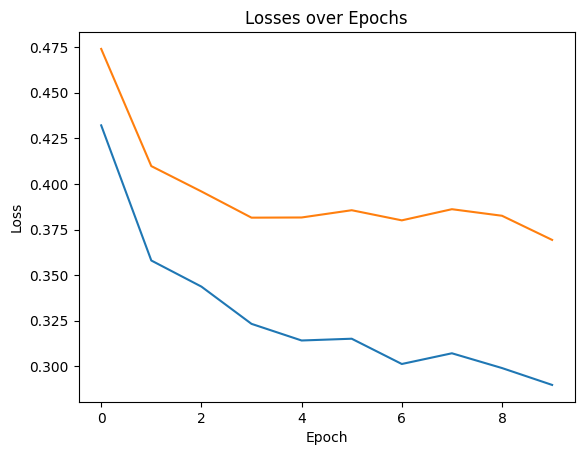

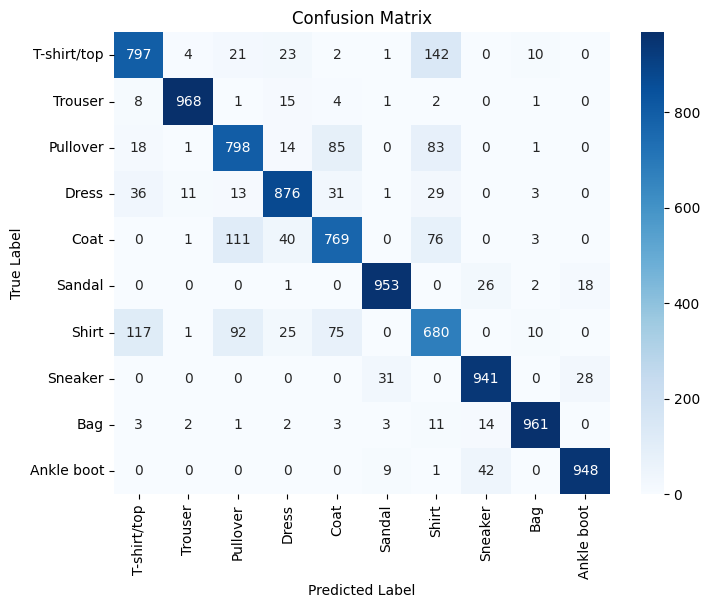

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from sklearn.metrics import confusion_matrix

# Initialize wandb
wandb.init(project="DA6401_A-1_Confusion_matrix", name="confusion_matrix")

# Function to compute predictions for test set
def get_predictions(X_test, trained_params, activation, num_layers, input_dim):
    """
    Compute class predictions for the test set.

    Args:
        X_test (numpy array): Test data.
        trained_params (dict): Trained weights and biases.
        activation (str): Activation function.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.

    Returns:
        numpy array: Predicted class labels.
    """
    predictions = []
    for i in range(X_test.shape[0]):
        input_sample = X_test[i, :].reshape(-1, 1)
        _, _, pred = forward_propagation(input_sample, trained_params, activation, num_layers, input_dim)
        predictions.append(np.argmax(pred))  # Convert probabilities to class labels
    return np.array(predictions)

# Best hyperparameters after tuning with wandb
epochs=10
batch_size=64
learning_rate=0.0001
beta=0.9
beta1=0.9
beta2=0.99
epsilon=0.000001
num_layers=5
num_neurons=128
input_dim=784
output_dim=10
weight_decay=0.0
weight_init='xavier'
activation='relu'

# Initialize the network with random weights based on the chosen weight initialization method
params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)
parameters = rmsprop_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta,weight_decay)

# Get true labels and predicted labels
y_true = np.argmax(Y_test, axis=1)  # Convert one-hot to class labels
y_pred = get_predictions(X_test, parameters, activation, num_layers, input_dim)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Save and log to wandb
plt.savefig("confusion_matrix.png")
wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix.png")})

# Close wandb run
wandb.finish()


### Question-8 : Best Optimizers with Mean Squared error

In [11]:
def mse_loss(y_true, y_pred, params, weight_decay, num_layers):
    """
    Compute Mean Squared Error (MSE) loss with L2 regularization.

    Args:
        y_true (numpy array): One-hot encoded true labels.
        y_pred (numpy array): Predicted probability distribution.
        params (dict): Dictionary containing network weights.
        weight_decay (float): L2 regularization strength.
        num_layers (int): Number of layers.

    Returns:
        float: MSE loss with L2 regularization.
    """
    mse = np.mean(np.sum((y_true - y_pred) ** 2, axis=0))  # Compute standard MSE loss

    # Compute L2 regularization term
    l2_reg = (weight_decay / 2) * sum(np.sum(params[f'W{layer}'] ** 2) for layer in range(1, num_layers + 2))

    return mse + l2_reg


def rmsprop_opt_mse(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta, weight_decay):
    """
    Implements the RMSprop (Root Mean Square Propagation) optimizer for training a neural network using MSE loss.
    """
    train_losses = []
    test_losses = []
    num_samples = X_train.shape[0]

    # Initialize velocity (moving average of squared gradients)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):
        num_processed = 0
        num_batches = 0
        epoch_loss = 0

        # Initialize gradient accumulator
        grad_accu = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):
            num_processed += 1

            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim, weight_decay)

            # Accumulate gradients
            for layer in range(num_layers + 1, 0, -1):
                grad_accu[f'W{layer}'] += gradients[f'W{layer}']
                grad_accu[f'b{layer}'] += gradients[f'b{layer}']

            # Update weights and biases after a full batch
            if num_processed % batch_size == 0:
                num_batches += 1

                for layer in range(1, num_layers + 2):
                    velocity[f'W{layer}'] = beta * prev_v[f'W{layer}'] + (1 - beta) * (grad_accu[f'W{layer}'] ** 2)
                    velocity[f'b{layer}'] = beta * prev_v[f'b{layer}'] + (1 - beta) * (grad_accu[f'b{layer}'] ** 2)

                    params[f'W{layer}'] -= (learning_rate / (np.sqrt(velocity[f'W{layer}'] + epsilon))) * grad_accu[f'W{layer}']
                    params[f'b{layer}'] -= (learning_rate / (np.sqrt(velocity[f'b{layer}'] + epsilon))) * grad_accu[f'b{layer}']

                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

        # Compute accuracy
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)
        test_acc = compute_accuracy(X_test, Y_test, params, activation, num_layers, input_dim)

        # Compute loss using MSE
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = mse_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        train_losses.append(train_loss)

        act, out, test_preds = forward_propagation(X_test.T, params, activation, num_layers, input_dim)
        test_loss = mse_loss(Y_test.T, test_preds, params, weight_decay, num_layers)
        test_losses.append(test_loss)

        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_loss: {train_loss:.4f}, Train_accuracy: {train_acc * 100:.2f}%, Test_loss: {test_loss:.4f}, Test_accuracy: {test_acc * 100:.2f}%")

    # Plot loss curves
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs (MSE)')
    plt.legend()
    plt.show()

    return params

def adam_opt_mse(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay):
    """
    Implements the Adam (Adaptive Moment Estimation) optimizer for training a neural network using mse.
    """

    train_losses = []  # List to store loss values for each epoch
    test_losses = []
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize first moment vector (momentum)
    momentum = {key: np.zeros_like(value) for key, value in params.items()}
    prev_m = {key: np.zeros_like(value) for key, value in params.items()}
    m_hat = {key: np.zeros_like(value) for key, value in params.items()}

    # Initialize second moment vector (velocity - moving average of squared gradients)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}
    v_hat = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate over epochs
        time_step = 0  # Time step counter for bias correction
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize epoch loss

        # Initialize gradient accumulator for batch updates
        gradient_accumulator = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):  # Iterate through all training samples
            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                gradient_accumulator[f'W{layer}'] += gradients[f'W{layer}']
                gradient_accumulator[f'b{layer}'] += gradients[f'b{layer}']

            num_processed += 1  # Increment processed sample counter

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                time_step += 1  # Increment time step for bias correction
                num_batches += 1  # Increment batch count

                # Compute biased first moment estimate (momentum)
                for layer in range(1, num_layers + 2):
                    momentum[f'W{layer}'] = beta1*prev_m[f'W{layer}'] + (1-beta1)*gradient_accumulator[f'W{layer}']
                    momentum[f'b{layer}'] = beta1*prev_m[f'b{layer}'] + (1-beta1)*gradient_accumulator[f'b{layer}']

                # Compute bias-corrected first moment estimate
                    m_hat[f'W{layer}'] = momentum[f'W{layer}'] / (1 - np.power(beta1, time_step))
                    m_hat[f'b{layer}'] = momentum[f'b{layer}'] / (1 - np.power(beta1, time_step))

                    # Update previous momentum values
                    prev_m[f'W{layer}'] = momentum[f'W{layer}']
                    prev_m[f'b{layer}'] = momentum[f'b{layer}']

                # Compute biased second moment estimate (velocity)
                    velocity[f'W{layer}'] = beta2*prev_v[f'W{layer}'] + (1-beta2)*(gradient_accumulator[f'W{layer}']**2)
                    velocity[f'b{layer}'] = beta2*prev_v[f'b{layer}'] + (1-beta2)*(gradient_accumulator[f'b{layer}']**2)

                # Compute bias-corrected second moment estimate
                    v_hat[f'W{layer}'] = velocity[f'W{layer}'] / (1 - np.power(beta2, time_step))
                    v_hat[f'b{layer}'] = velocity[f'b{layer}'] / (1 - np.power(beta2, time_step))

                    # Update previous velocity values
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

                # Apply Adam update rule to parameters
                    params[f'W{layer}'] -= (learning_rate / (np.sqrt(v_hat[f'W{layer}']) + epsilon)) *m_hat[f'W{layer}']
                    params[f'b{layer}'] -= (learning_rate / (np.sqrt(v_hat[f'b{layer}']) + epsilon)) *m_hat[f'b{layer}']

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = mse_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        train_losses.append(train_loss)  # Store loss for visualization

        # Compute test accuracy
        test_acc = compute_accuracy(X_test, Y_test, params, activation, num_layers, input_dim)

        # Compute test loss using cross-entropy
        act, out, test_preds = forward_propagation(X_test.T, params, activation, num_layers, input_dim)
        test_loss = mse_loss(Y_test.T, test_preds, params, weight_decay, num_layers)
        test_losses.append(test_loss)  # Store loss for visualization


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_loss: {train_loss:.4f}, Train_accuracy: {train_acc * 100:.2f}%, Test_loss: {test_loss:.4f}, Test_accuracy: {test_acc * 100:.2f}%")

    # Plot the loss function over epochs
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs')
    plt.show()

    return params

def nadam_opt_mse(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay):
    """
    Implements the Nadam (Nesterov-accelerated Adaptive Moment Estimation) optimization algorithm using mse.
    """
    train_losses = []
    test_losses = []
    num_samples = X_train.shape[0]

    # Initialize velocity and momentum terms for all parameters
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_v = {key: np.zeros_like(value) for key, value in params.items()}
    v_hat = {key: np.zeros_like(value) for key, value in params.items()}

    momentum = {key: np.zeros_like(value) for key, value in params.items()}
    prev_m = {key: np.zeros_like(value) for key, value in params.items()}
    m_hat = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):
        time_step = 0
        num_processed = 0
        num_batches = 0
        epoch_loss = 0
        grad_accu = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):
            # Forward pass for a single training sample
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim,weight_decay)

            # Accumulate gradients over the batch
            for layer in range(num_layers + 1, 0, -1):
                grad_accu[f'W{layer}'] += gradients[f'W{layer}']
                grad_accu[f'b{layer}'] += gradients[f'b{layer}']

            num_processed += 1
            if num_processed % batch_size == 0:
                time_step += 1
                num_batches += 1

                # Compute momentum estimates
                for layer in range(1, num_layers + 2):
                    momentum[f'W{layer}'] = beta1 *prev_m[f'W{layer}'] + (1-beta1)*grad_accu[f'W{layer}']
                    momentum[f'b{layer}'] = beta1 *prev_m[f'b{layer}'] + (1-beta1)*grad_accu[f'b{layer}']

                # Bias-corrected momentum
                    m_hat[f'W{layer}'] = momentum[f'W{layer}'] / (1-np.power(beta1, time_step))
                    m_hat[f'b{layer}'] = momentum[f'b{layer}'] / (1-np.power(beta1, time_step))
                    prev_m[f'W{layer}'] = momentum[f'W{layer}']
                    prev_m[f'b{layer}'] = momentum[f'b{layer}']

                # Compute velocity estimates
                    velocity[f'W{layer}'] = beta2 * prev_v[f'W{layer}'] + (1-beta2) * (grad_accu[f'W{layer}']**2)
                    velocity[f'b{layer}'] = beta2 * prev_v[f'b{layer}'] + (1-beta2) * (grad_accu[f'b{layer}']**2)

                # Bias-corrected velocity
                    v_hat[f'W{layer}'] = velocity[f'W{layer}'] / (1-np.power(beta2, time_step))
                    v_hat[f'b{layer}'] = velocity[f'b{layer}'] / (1-np.power(beta2, time_step))
                    prev_v[f'W{layer}'] = velocity[f'W{layer}']
                    prev_v[f'b{layer}'] = velocity[f'b{layer}']

                # Update parameters using Nadam update rule
                    params[f'W{layer}'] -= (learning_rate/(np.sqrt(v_hat[f'W{layer}'])+epsilon)) * (beta1*m_hat[f'W{layer}'] + (1-beta1)*grad_accu[f'W{layer}']/(1-np.power(beta1, time_step)))
                    params[f'b{layer}'] -= (learning_rate/(np.sqrt(v_hat[f'b{layer}'])+epsilon)) * (beta1*m_hat[f'b{layer}'] + (1-beta1)*grad_accu[f'b{layer}']/(1-np.power(beta1, time_step)))

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        act, out, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = mse_loss(Y_train.T, train_preds, params, weight_decay, num_layers)
        train_losses.append(train_loss)  # Store loss for visualization

        # Compute test accuracy
        test_acc = compute_accuracy(X_test, Y_test, params, activation, num_layers, input_dim)

        # Compute test loss using cross-entropy
        act, out, test_preds = forward_propagation(X_test.T, params, activation, num_layers, input_dim)
        test_loss = mse_loss(Y_test.T, test_preds, params, weight_decay, num_layers)
        test_losses.append(test_loss)  # Store loss for visualization


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_loss: {train_loss:.4f}, Train_accuracy: {train_acc * 100:.2f}%, Test_loss: {test_loss:.4f}, Test_accuracy: {test_acc * 100:.2f}%")


    # Plot the loss function over epochs
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs')
    plt.show()

    return params


In [12]:
# Best hyperparameters after tuning with wandb
epochs=10
batch_size=64
learning_rate=0.0001
beta=0.9
beta1=0.9
beta2=0.99
epsilon=0.000001
num_layers=5
num_neurons=128
input_dim=784
output_dim=10
weight_decay=0.0
weight_init='xavier'
activation='relu'

# Initialize the network with random weights based on the chosen weight initialization method
params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)

Epoch 1, Train_loss: 0.2111, Train_accuracy: 85.26%, Test_loss: 0.2294, Test_accuracy: 83.69%
Epoch 2, Train_loss: 0.1847, Train_accuracy: 87.14%, Test_loss: 0.2071, Test_accuracy: 85.36%
Epoch 3, Train_loss: 0.1746, Train_accuracy: 87.67%, Test_loss: 0.2033, Test_accuracy: 85.78%
Epoch 4, Train_loss: 0.1671, Train_accuracy: 88.29%, Test_loss: 0.1943, Test_accuracy: 86.40%
Epoch 5, Train_loss: 0.1638, Train_accuracy: 88.53%, Test_loss: 0.1952, Test_accuracy: 86.27%
Epoch 6, Train_loss: 0.1635, Train_accuracy: 88.63%, Test_loss: 0.1942, Test_accuracy: 86.35%
Epoch 7, Train_loss: 0.1608, Train_accuracy: 88.63%, Test_loss: 0.1922, Test_accuracy: 86.39%
Epoch 8, Train_loss: 0.1586, Train_accuracy: 88.95%, Test_loss: 0.1918, Test_accuracy: 86.65%
Epoch 9, Train_loss: 0.1582, Train_accuracy: 89.05%, Test_loss: 0.1873, Test_accuracy: 87.00%
Epoch 10, Train_loss: 0.1588, Train_accuracy: 88.81%, Test_loss: 0.1909, Test_accuracy: 86.52%


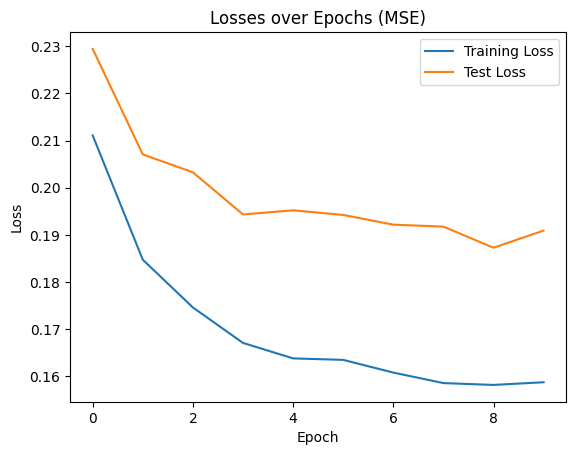

In [42]:
parameters = rmsprop_opt_mse(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta,weight_decay)


Epoch 1, Train_loss: 0.4152, Train_accuracy: 68.88%, Test_loss: 0.4285, Test_accuracy: 68.13%
Epoch 2, Train_loss: 0.3151, Train_accuracy: 76.50%, Test_loss: 0.3258, Test_accuracy: 75.50%
Epoch 3, Train_loss: 0.2910, Train_accuracy: 78.93%, Test_loss: 0.3058, Test_accuracy: 77.94%
Epoch 4, Train_loss: 0.2684, Train_accuracy: 80.95%, Test_loss: 0.2844, Test_accuracy: 79.46%
Epoch 5, Train_loss: 0.2497, Train_accuracy: 81.83%, Test_loss: 0.2661, Test_accuracy: 80.64%
Epoch 6, Train_loss: 0.2688, Train_accuracy: 80.39%, Test_loss: 0.2862, Test_accuracy: 78.95%
Epoch 7, Train_loss: 0.2392, Train_accuracy: 83.46%, Test_loss: 0.2591, Test_accuracy: 81.94%
Epoch 8, Train_loss: 0.2280, Train_accuracy: 83.94%, Test_loss: 0.2486, Test_accuracy: 82.60%
Epoch 9, Train_loss: 0.2390, Train_accuracy: 83.32%, Test_loss: 0.2587, Test_accuracy: 81.72%
Epoch 10, Train_loss: 0.2187, Train_accuracy: 84.68%, Test_loss: 0.2426, Test_accuracy: 83.10%


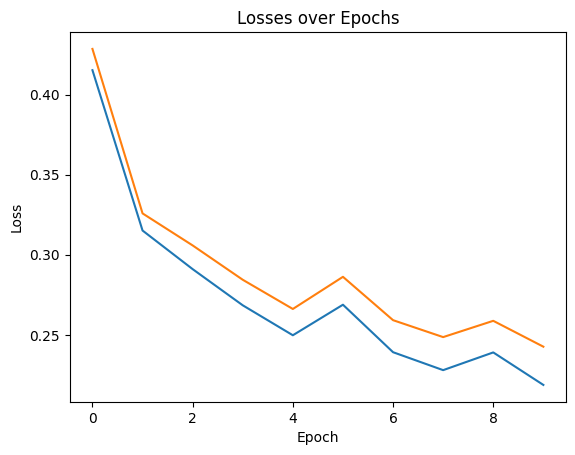

In [13]:
parameters = adam_opt_mse(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay)

Epoch 1, Train_loss: 0.2055, Train_accuracy: 85.50%, Test_loss: 0.2318, Test_accuracy: 83.70%
Epoch 2, Train_loss: 0.2265, Train_accuracy: 84.13%, Test_loss: 0.2520, Test_accuracy: 82.21%
Epoch 3, Train_loss: 0.2033, Train_accuracy: 85.12%, Test_loss: 0.2235, Test_accuracy: 84.01%
Epoch 4, Train_loss: 0.1892, Train_accuracy: 86.84%, Test_loss: 0.2150, Test_accuracy: 84.91%
Epoch 5, Train_loss: 0.2152, Train_accuracy: 84.38%, Test_loss: 0.2405, Test_accuracy: 82.32%
Epoch 6, Train_loss: 0.1903, Train_accuracy: 86.64%, Test_loss: 0.2171, Test_accuracy: 84.40%
Epoch 7, Train_loss: 0.1880, Train_accuracy: 86.49%, Test_loss: 0.2125, Test_accuracy: 84.91%
Epoch 8, Train_loss: 0.1876, Train_accuracy: 86.44%, Test_loss: 0.2132, Test_accuracy: 84.85%
Epoch 9, Train_loss: 0.1813, Train_accuracy: 87.18%, Test_loss: 0.2108, Test_accuracy: 85.03%
Epoch 10, Train_loss: 0.1861, Train_accuracy: 86.80%, Test_loss: 0.2161, Test_accuracy: 84.87%


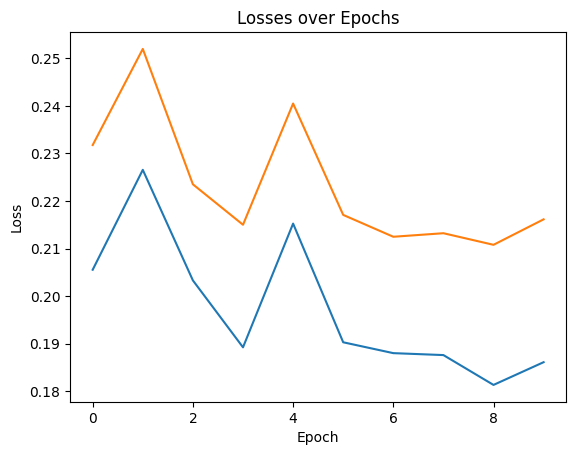

In [14]:
parameters = nadam_opt_mse(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay)

## Question-10 : Best three hyperparameter configurations for the MNSIT dataset

In [38]:
from keras.datasets import mnist

# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten the images (convert 28x28 matrices into 1D arrays of size 784)
# Normalize pixel values to the range [0,1] by dividing by 255
X_train = x_train.reshape(x_train.shape[0], -1) / 255
X_test = x_test.reshape(x_test.shape[0], -1) / 255

def one_hot_encod(arr):
    """ Convert class labels to one-hot encoded vectors.
    Args: arr (numpy array): Array of class labels (e.g., [0, 1, 2, ..., 9])

    Returns: numpy array: One-hot encoded matrix of shape (len(arr), 10)
    """
    mat = np.zeros((len(arr), 10))  # Create a matrix of zeros with shape (num_samples, num_classes)
    for i in range(len(arr)):
        mat[i, arr[i]] = 1  # Set the corresponding class index to 1
    return mat

# Convert labels to one-hot encoding for training, validation, and test sets
Y_train = one_hot_encod(y_train)
Y_test = one_hot_encod(y_test)


NADAM Optimizer

Epoch 1, Train_loss: 0.3039, Train_accuracy: 91.06%, Test_loss: 0.2972, Test_accuracy: 90.72%
Epoch 2, Train_loss: 0.2126, Train_accuracy: 93.97%, Test_loss: 0.2345, Test_accuracy: 93.54%
Epoch 3, Train_loss: 0.1532, Train_accuracy: 95.39%, Test_loss: 0.1818, Test_accuracy: 94.74%
Epoch 4, Train_loss: 0.1346, Train_accuracy: 96.12%, Test_loss: 0.1659, Test_accuracy: 95.21%
Epoch 5, Train_loss: 0.1318, Train_accuracy: 96.27%, Test_loss: 0.1667, Test_accuracy: 95.53%
Epoch 6, Train_loss: 0.1284, Train_accuracy: 96.36%, Test_loss: 0.1783, Test_accuracy: 95.40%
Epoch 7, Train_loss: 0.1207, Train_accuracy: 96.64%, Test_loss: 0.1730, Test_accuracy: 95.52%
Epoch 8, Train_loss: 0.1104, Train_accuracy: 96.94%, Test_loss: 0.1551, Test_accuracy: 95.93%
Epoch 9, Train_loss: 0.1184, Train_accuracy: 96.64%, Test_loss: 0.1698, Test_accuracy: 95.58%
Epoch 10, Train_loss: 0.1133, Train_accuracy: 97.22%, Test_loss: 0.1494, Test_accuracy: 96.28%


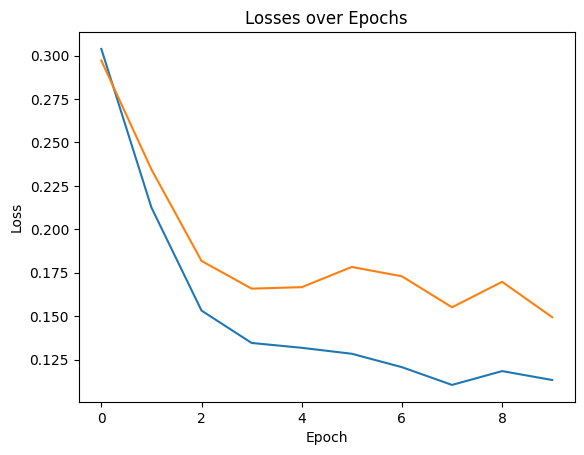

In [39]:
# Best hyperparameters after tuning with wandb
epochs=10
batch_size=32
learning_rate=0.0001
beta=0.9
beta1=0.9
beta2=0.99
epsilon=0.000001
num_layers=4
num_neurons=64
input_dim=784
output_dim=10
weight_decay=0.0
weight_init='xavier'
activation='relu'

# Initialize the network with random weights based on the chosen weight initialization method
params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)

# Nadam optimizer (Adam with Nesterov momentum)
parameters = nadam_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay)

ADAM Optimizer


Epoch 1, Train_loss: 0.4607, Train_accuracy: 86.99%, Test_loss: 0.4532, Test_accuracy: 87.52%
Epoch 2, Train_loss: 0.3084, Train_accuracy: 90.69%, Test_loss: 0.3048, Test_accuracy: 90.60%
Epoch 3, Train_loss: 0.2493, Train_accuracy: 93.07%, Test_loss: 0.2610, Test_accuracy: 92.57%
Epoch 4, Train_loss: 0.1991, Train_accuracy: 94.13%, Test_loss: 0.2125, Test_accuracy: 93.79%
Epoch 5, Train_loss: 0.1652, Train_accuracy: 95.42%, Test_loss: 0.1764, Test_accuracy: 94.98%
Epoch 6, Train_loss: 0.1400, Train_accuracy: 96.09%, Test_loss: 0.1747, Test_accuracy: 95.13%
Epoch 7, Train_loss: 0.1311, Train_accuracy: 96.20%, Test_loss: 0.1630, Test_accuracy: 95.50%
Epoch 8, Train_loss: 0.1443, Train_accuracy: 95.96%, Test_loss: 0.1860, Test_accuracy: 94.94%
Epoch 9, Train_loss: 0.1303, Train_accuracy: 96.70%, Test_loss: 0.1594, Test_accuracy: 95.72%
Epoch 10, Train_loss: 0.1056, Train_accuracy: 97.03%, Test_loss: 0.1370, Test_accuracy: 96.11%


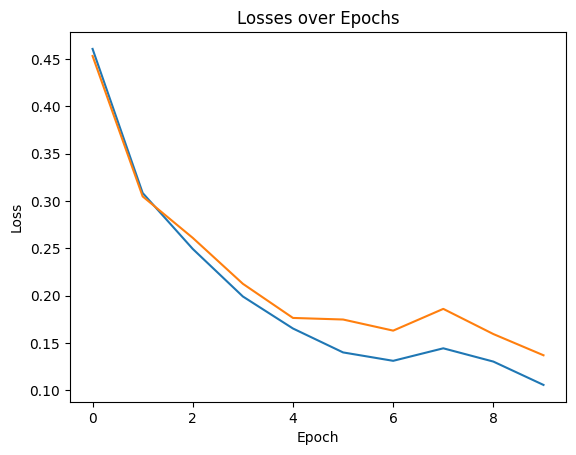

In [40]:
# Best hyperparameters after tuning with wandb
epochs=10
batch_size=64
learning_rate=0.0001
beta=0.9
beta1=0.9
beta2=0.99
epsilon=0.000001
num_layers=5
num_neurons=64
input_dim=784
output_dim=10
weight_decay=0.0
weight_init='xavier'
activation='relu'

# Initialize the network with random weights based on the chosen weight initialization method
params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)
parameters = adam_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1, beta2,weight_decay)

RMSprop Optimizer

Epoch 1, Train_loss: 0.1911, Train_accuracy: 94.21%, Test_loss: 0.1896, Test_accuracy: 94.29%
Epoch 2, Train_loss: 0.1341, Train_accuracy: 95.84%, Test_loss: 0.1588, Test_accuracy: 95.04%
Epoch 3, Train_loss: 0.1119, Train_accuracy: 96.80%, Test_loss: 0.1523, Test_accuracy: 95.83%
Epoch 4, Train_loss: 0.1127, Train_accuracy: 96.54%, Test_loss: 0.1437, Test_accuracy: 95.53%
Epoch 5, Train_loss: 0.1004, Train_accuracy: 97.00%, Test_loss: 0.1385, Test_accuracy: 95.96%
Epoch 6, Train_loss: 0.0877, Train_accuracy: 97.36%, Test_loss: 0.1290, Test_accuracy: 96.38%
Epoch 7, Train_loss: 0.0912, Train_accuracy: 97.29%, Test_loss: 0.1368, Test_accuracy: 96.17%
Epoch 8, Train_loss: 0.0801, Train_accuracy: 97.76%, Test_loss: 0.1236, Test_accuracy: 96.63%
Epoch 9, Train_loss: 0.0857, Train_accuracy: 97.74%, Test_loss: 0.1248, Test_accuracy: 96.50%
Epoch 10, Train_loss: 0.0860, Train_accuracy: 97.63%, Test_loss: 0.1253, Test_accuracy: 96.73%


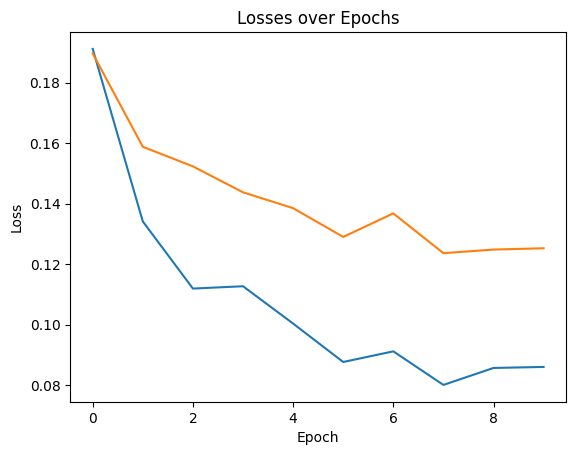

In [41]:
# Best hyperparameters after tuning with wandb
epochs=10
batch_size=64
learning_rate=0.0001
beta=0.9
beta1=0.9
beta2=0.99
epsilon=0.000001
num_layers=5
num_neurons=128
input_dim=784
output_dim=10
weight_decay=0.0
weight_init='xavier'
activation='relu'

# Initialize the network with random weights based on the chosen weight initialization method
params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)
parameters = rmsprop_opt(learning_rate, params, X_train, Y_train, X_test, Y_test, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta,weight_decay)